<a href="https://colab.research.google.com/github/rhh-jhu/ML_FinalProject/blob/main/Final_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Plug-in Image Ensemble Defender (SPIE-D)
Project mentor: Dr. Mark Dredze

Russ Huang rhuang23@jh.edu, Randy Kuang rkuang2@jh.edu, Shaurya Kumar skumar65@jh.edu, Annie Liang jliang28@jh.edu

***Since PDF conversion expands all code cells by default we recomend reading on Google Colaboratory.***

***Link_to_git_repo:*** https://github.com/randy99kuang/ML_FinalProject 

***Saved Data and Models:*** https://drive.google.com/drive/folders/1DpGUPeNIxg7PVTRsdc5vFUIHa2WQKAz4?usp=sharing


# Outline and Deliverables

### Uncompleted Deliverables
1. "Nice to complete #3": Test pipeline on an application dataset to show generalizability of the method. End of semester realities meant we ran out of time, especially due to time needed to generate large sets of adversarial images.


### Completed Deliverables
1. "Must complete #1": Generate adversarial examples (random perturbation, gradient-based, transform based)
 [in "Adversary Generation"](#scrollTo=kSd9WPUnECcf).

2. "Must complete #3": Create our own defender that consists of an adversary classifier & a denoising strategy for each class of adversaries [in "SPIE-D"](#scrollTo=G6lZ0HyJGGze).
3. "Expect to complete #2": Explore performance of PCA versus our adversary classifier for detecting adversarial examples [in "PCA Adversary Detector"](#scrollTo=vWedY_JPyQF9).
4. "Expect to complete #3": Improve upon the defender by creating a weighted combination scheme for the ensemble denoising [in "SPIE-D"](#scrollTo=G6lZ0HyJGGze).
5. "Nice to complete #2": Demonstrate that proposed defender exhibits a strong adversary classifier (Improves robustness with little sacrifice accuracy on non-adversarial data). Achieved an approximatly 1% drops in the baseline classification accuracy on clean images [in "SPIE-D" results](#scrollTo=pBo-QnVteDpn).


### Additional Deliverables
1. "Must complete #2": Train 3 baseline NN classifiers to establish baseline accuracy on Digits. The Digits dataset was replaced by Fashion MNIST for a more interesting task
[in "Baseline Classifiers"](#scrollTo=u9RmUF9D40sr&uniqifier=1).

2. "Expect to complete #1": Adapt RAIN and PixelDefend strategies for Fashion MNIST and comparison. RAIN was adapted, found below [under "RAIN"](#scrollTo=0knGBOA8QzRQ&uniqifier=1), however the published repository for *PixelDefend* was poorly maintained and thus the baseline was replaced by Provably Robust Boosting instead, the original repository link can be found [in "Provably Robust Boosting"](#scrollTo=D7XUHnJ5PF_D&uniqifier=1) and the project adaptaion is available in the [project repository](https://github.com/randy99kuang/ML_FinalProject).

3. "Nice to complete #1": Compare effects of training with defender in place & without a defender in place. Since this is not the application space envisioned by prior works into plug-in defenders adversarial and augmented training were explored instead [in "Adversarial and Augmented Training"](#scrollTo=vRCUxNCaHyDS&uniqifier=1).

4. Generated Jacobian Saliency Map Attack (JSMA) images to further explore ideas about transferability and overfitting [in "JSMA"](#scrollTo=ph5yZe75R0Uo&uniqifier=1).

# Preliminaries

## What problem were you trying to solve or understand?

As machine learning models demonstrate improving and reliable performance they have also become more and more widely used. In particular, image models have driven gains in the performance of machine vision systems over the last 10 or so years due to deep learning. The technical heart of these models however are artificial nueral networks built from even simpler convolutional and fully connected layers. As of late, these image models have been deployed for a variety of security or saftey critical applications such as self-driving vehicles [1], survellance footage, or as part of medical imaging systems. However, this opens the door for a critical question of how robust these models are for the ecosystems which they are deployed, particularily with regards to security. What has become patent is that these classifiers can be attacked in a variety of ways including vulnerability to intentionally crafted white-box and black-box threats but also due to deficiencies in the distribution of the data the classifier was trained on. In practice, questions of robustness directly influence, for example, how hard would it be to fool the object classifier on a self driving car or how reliable is a particular medical image classification system. Robustness can thus also help establish user trust in machine learning systems.

Such questions have thus motivated the exploration of adversarially robust machine learning particularly within the context of classifying image data. Image data in particular also assists with defining the attack-sphere and interpretting the attack images. Aside from application concerns adversarial machine learning has also been looked at as a way to train stronger classifiers (using supervised training) although this problem is typically viewed in the lens of training classifiers invariant to adversarial information and thus can also be looked at in the context of a bias variance trade-off [2]. Such methods however, require retraining models and often demonstrate a drop in performance on clean images both of which are not always desired or practical in application. 

Thus, to avoid retraining deployed models and maintain baseline performance on clean images another paradigm for hardening systems torwards adveraries is the deployment of some sort of additional piece, typically a detector-denoiser method of some sort, which will be termed a plug-in style defender. These plug-in defenders take a variety of forms including data pre-processing frameworks or are themselves data-driven models. By providing robustness to noise, image transforms, or intentional gradient attacks these defenders can thus create more confidence and trust in the reliability of deployed machine learning models for users and could be tailored to the expected disturbances. However, simultaneously the arms-race nature of adversaries and defenders often quickly errodes any successes made on either front, especially when looking at diffulcties with transferability. 


In [ ]:
#@title Save Path { form-width: "20%" }

from google.colab import drive
drive.mount('/content/drive')

# Feel free to create your own path and comment out the other paths when you run
# PATH = "."  # Default path that doesn't save to your drive, 
# use this if you don't want to specify a path
PATH = "/content/drive/My Drive/ML Final Project Files/"  # Shortcut to shared 
# folder with models and generated data.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Imports { form-width: "20%" }

# Imports for file saving
import os.path
import pickle

# Sklearn dataset utilities
from sklearn.model_selection import train_test_split
from skimage import transform

# Math
import numpy as np
from numpy import random as rn
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Torchvision for image transforms
!pip install torchviz
import torch
import torchvision
from torchvision import transforms, utils

# Pytorch Dataset infrastructure
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Sampler

# Torch gradient
from torch.autograd import grad

from functools import partial

import torch.nn as nn
import torch.nn.functional as F


In [ ]:
#@title Data Loading Helper Fcn { form-width: "20%" }

def print_info(labels, counts):
  total = np.sum(counts)
  for d in labels:
    print(f'Class: {d}, with {counts[d]} examples ({np.round(counts[d]/total,3)})')

def clean_images(images_as_np):
  return np.nan_to_num(images_as_np,nan=0.5,posinf=1,neginf=0)

def load_data(X,Y,t_size=0.2,d_size=0.2,show=True):
  labels, counts = np.unique(Y,return_counts=True)
  x_train, x_test, y_train, y_test = train_test_split(X,Y,
                                  test_size=t_size,random_state=rn.randint(101)) 
  x_train, x_dev, y_train, y_dev = train_test_split(x_train,y_train,
                                  test_size=d_size,random_state=rn.randint(42))
  x = [x_train, x_dev, x_test] 
  y = [y_train, y_dev, y_test]

  for i in range(len(y)):
    y[i] = np.squeeze(y[i])
  
  if (show==True):
    print(f'=================== Data Summary =========================== \n'
      + f'Total: {Y.shape[0]} Examples')
    print_info(labels,counts)

    tr_labels, tr_counts = np.unique(y_train,return_counts=True)
    print(f'=================== Training Data =========================== \n'
      + f'Total: {y_train.shape[0]} Examples')
    print_info(tr_labels,tr_counts)

    d_labels, d_counts = np.unique(y_dev,return_counts=True)
    print(f'=================== Validation Data =========================== \n'
      + f'Total: {y_dev.shape[0]} Examples')
    print_info(d_labels,d_counts)
    
    t_labels, t_counts = np.unique(y_test,return_counts=True)
    print(f'=================== Test Data =========================== \n'
      + f'Total: {y_dev.shape[0]} Examples')
    print_info(t_labels,t_counts)
  # end if

  #label_dict = {"all":labels, "train": tr_labels, "dev": d_labels, "test": t_labels}
  count_dict = {"all":counts, "train": tr_counts, "dev": d_counts, "test": t_counts}
  data_dict = {"all":X, "train": x_train, "dev": x_dev, "test": x_test}
  target_dict = {"all":Y, "train": y_train, "dev": y_dev, "test": y_test}

  return count_dict, data_dict, target_dict

class ImageDataset(Dataset):
  def __init__(self, x_list, y_list):
    """
    Args: transform: to be applied on a sample automatically if desired
    """
    self.data = x_list
    self.label = y_list
  def __len__(self):
    return self.data.shape[0]
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    #sample = {'image': np.squeeze(self.data[idx]), 
    #          'label': np.squeeze(self.label[idx])}
    sample = (np.squeeze(self.data[idx]), np.squeeze(self.label[idx]))
    return sample

## Dataset(s)

To explore various plug-in defense methods specifically geared torwards image classification in a controlled setting the Fashion MNIST (F-MNIST) dataset [3] was utilized. Overall, the dataset contains 60,000 training and 10,000 test instances of 28 x 28 grayscale images of articles of clothing divided into 10 classes with pixel intensities encoded as floats from 0 to 1. The classes in numberical (labeled 0 through 9) order are t-shirt/top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. Further, each image can be considered a "best-case" scenario meaning that each image of the clothing is from the direct front with articles scaled to fit the entire image, already revealing a data deficiencies. 

Only a random 20% of the total dataset was used for training and testing in the interests of computational resources. Moreover, of the training portion, 10% was used as validation data. The class proportions were verified to be roughly balanced in the training, development, and test datasets. 

Image from [3]

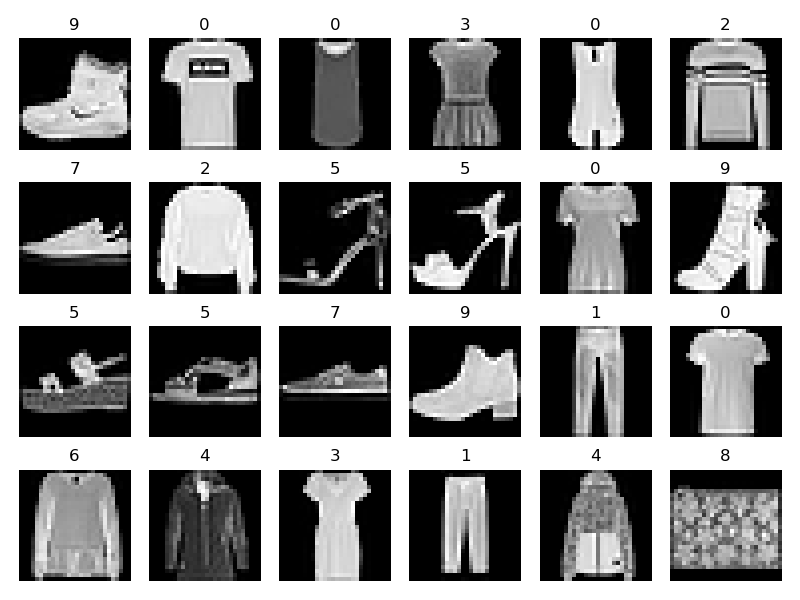


In [ ]:
#@title Load Fashion MNIST using Torch Utils { form-width: "20%" }
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
convert = transforms.Compose(
    [transforms.ToTensor()]
)

SAVE_PATH = PATH + 'train_mnist_x' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    tempx_train = np.load(f) 
  SAVE_PATH = PATH + 'train_mnist_y' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    tempy_train = np.load(f)
  SAVE_PATH = PATH + 'dev_mnist_x' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    tempx_dev = np.load(f)
  SAVE_PATH = PATH + 'dev_mnist_y' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    tempy_dev = np.load(f)
  SAVE_PATH = PATH + 'test_mnist_x' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    tempx_test = np.load(f)
  SAVE_PATH = PATH + 'test_mnist_y' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    tempy_test = np.load(f)
else:

  mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                          download=True, transform=convert)
  total_size = 0.2 # <-------- # Change how much of set we use HERE !
  dev_size = 0.1
  total = len(mnist_trainset)
  ind = np.arange(total)
  rn.shuffle(ind)
  ind = ind[0:int(np.floor(total_size*total))]
  split = int(np.floor(dev_size*total_size*total))
  train_sampler = SubsetRandomSampler(ind[split:])
  dev_sampler = SubsetRandomSampler(ind[0:split])

  mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10,
                                            sampler=train_sampler, num_workers=2)
  mnist_devloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10,
                                            sampler=dev_sampler, num_workers=2)

  mnist_testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=convert)
  total = len(mnist_testset)
  ind = np.arange(total)
  rn.shuffle(ind)
  ind = ind[0:int(np.floor(total_size*total))]
  test_sampler = SubsetRandomSampler(ind)
  mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=10,
                                          sampler=test_sampler, num_workers=2)

  mnist_classes = ('top', 'trouser', 'pullover', 'dress',
            'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot')

  EX, LAB = iter(mnist_trainloader).next()
  tempx_train = np.empty_like(EX[0])
  tempy_train = np.empty_like([0])
  for (i_batch,data) in enumerate(mnist_trainloader,0):
    inputs, labels = data
    for ex,tar in zip(inputs,labels):
      tempx_train = np.append(tempx_train,ex.numpy(),axis=0)
      tar = tar.numpy()
      tempy_train = np.append(tempy_train,[tar],axis=0)

  tempx_dev = np.empty_like(EX[0])
  tempy_dev = np.empty_like([0])
  for (i_batch,data) in enumerate(mnist_devloader,0):
    inputs, labels = data
    for ex,tar in zip(inputs,labels):
      tempx_dev = np.append(tempx_dev,ex.numpy(),axis=0)
      tar = tar.numpy()
      tempy_dev = np.append(tempy_dev,[tar],axis=0)

  tempx_test = np.empty_like(EX[0])
  tempy_test = np.empty_like([0])
  for (i_batch,data) in enumerate(mnist_testloader,0):
    inputs, labels = data
    for ex,tar in zip(inputs,labels):
      tempx_test = np.append(tempx_test,ex.numpy(),axis=0)
      tar = tar.numpy()
      tempy_test = np.append(tempy_test,[tar],axis=0)

  tempx_train = clean_images(tempx_train[1:])
  tempx_dev = clean_images(tempx_dev[1:])
  tempx_test = clean_images(tempx_test[1:])

  tempy_train = tempy_train[1:]
  tempy_dev = tempy_dev[1:]
  tempy_test = tempy_test[1:]

  with open(PATH + 'train_mnist_x' + '.npy', 'wb') as f:
    np.save(f, np.array(tempx_train))
  with open(PATH + 'train_mnist_y' + '.npy', 'wb') as f:
    np.save(f, np.array(tempy_train))
  with open(PATH + 'dev_mnist_x' + '.npy', 'wb') as f:
    np.save(f, np.array(tempx_dev))
  with open(PATH + 'dev_mnist_y' + '.npy', 'wb') as f:
    np.save(f, np.array(tempy_dev))
  with open(PATH + 'test_mnist_x' + '.npy', 'wb') as f:
    np.save(f, np.array(tempx_test))
  with open(PATH + 'test_mnist_y' + '.npy', 'wb') as f:
    np.save(f, np.array(tempy_test))


#############################################################################
mnist_classes = ('top', 'trouser', 'pullover', 'dress',
            'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot')

mnist_x = {'train':tempx_train, 'dev':tempx_dev, 'test':tempx_test}
mnist_y = {'train':tempy_train, 'dev':tempy_dev, 'test':tempy_test}

mnist_trainset = ImageDataset(mnist_x["train"],mnist_y["train"])
mnist_devset = ImageDataset(mnist_x["dev"],mnist_y["dev"])
mnist_testset = ImageDataset(mnist_x["test"],mnist_y["test"])

mnist_trainloader = DataLoader(mnist_trainset,50,shuffle=True)
mnist_devloader = DataLoader(mnist_devset,50,shuffle=True)
mnist_testloader = DataLoader(mnist_testset,50,shuffle=True)

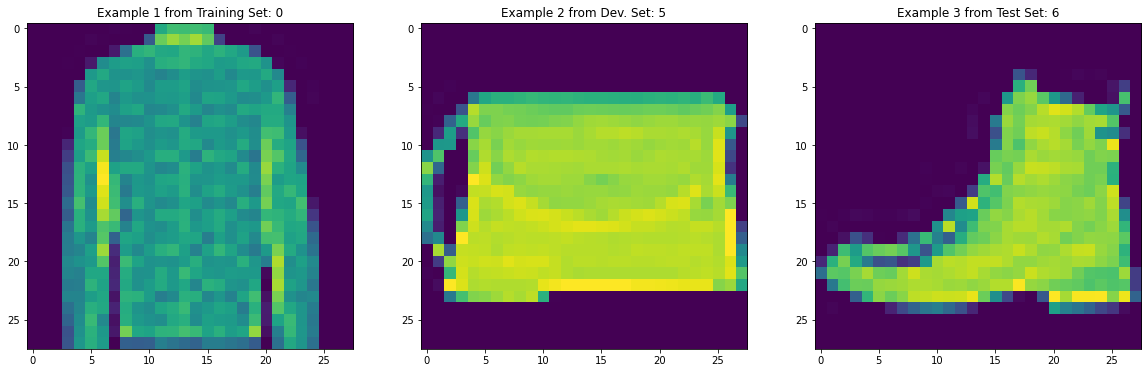

In [ ]:
#@title Show some examples { form-width: "20%" }

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))

ax[0].set_title("Example 1 from Training Set: " + str(mnist_y["train"][100]))
ax[0].imshow(mnist_x["train"][0])
ax[1].set_title("Example 2 from Dev. Set: " + str(mnist_y["dev"][100]))
ax[1].imshow(mnist_x["dev"][0])
ax[2].set_title("Example 3 from Test Set: " + str(mnist_y["test"][100]))
ax[2].imshow(mnist_x["test"][0])


# Pre-processing

Class Balance and Adversarial Attack Generation are Discussed Below

##Balance

A class balance was extracted below under ["Show class balance"](#scrollTo=tw7ON4ECNbFj) for the saved portion of the dataset and is summarized in the below table:

##### Fashion MNIST Sub-Set Summary
|Sub-set|0 (t-shirt/top)|1 (trouser)|2 (pullover)|3 (dress)|4 (coat)|5 (sandal)|6 (shirt)|7 (sneaker)|8 (bag)|9 (ankle boot)|
|:---|:----:|---:|---:|---:|---:|---:|---:|---:|---:|---:|
|Train (10800) %|10.2|10.1|9.9|10.0|9.6|9.9|9.8|10.4|10.0|9.9|          
|Development (1200) %|9.6|10.9|10.8|9.3|10.7|10.8|8.8|10.8|8.8|9.8| 
|Test (2000) %|9.5|10.9|9.1|10.6|10.5|10.5|10.0|9.5|10.7|8.9|10.9|

Note that test proportions were viewed soley to verify the sampling was roughly random. No modifications were made based on this information.

Text(0.5, 0, 'Label Number')

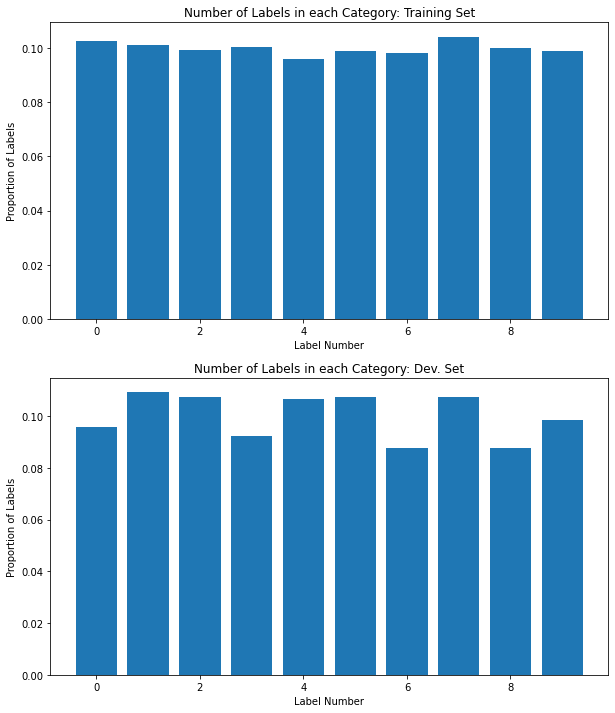

In [ ]:
##Balance
#@title Show class balance { form-width: "20%" }

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10,12))

label_num, train_label_count = np.unique(mnist_y["train"],return_counts=True)
train_total = np.sum(train_label_count)
train_prop = train_label_count/train_total
#print("Train Class (total " + str(train_total) + ") proportions:\n" 
#      + str(train_prop))

label_num, dev_label_count = np.unique(mnist_y["dev"],return_counts=True)
dev_total = np.sum(dev_label_count)
dev_prop = dev_label_count/dev_total
#print("Dev. Class (total " + str(dev_total) + ") proportions:\n" 
#      + str(dev_prop))

ax[0].bar(x=label_num, height=train_prop, label=label_num)
ax[0].set_ylabel("Proportion of Labels")
ax[0].set_title("Number of Labels in each Category: Training Set")
ax[0].set_xlabel("Label Number")

ax[1].bar(x=label_num, height=dev_prop, label=label_num)
ax[1].set_ylabel("Proportion of Labels")
ax[1].set_title("Number of Labels in each Category: Dev. Set")
ax[1].set_xlabel("Label Number")


##Adversarial Data Background

The two primary forms of adverarial attack are distinguished by the level of access they have to the underlying classifier and are thus divided into black-box methods that have no access to the internal weights of the classifier and white-box attacks that do have full access to the classifier. Image transformations are viewed as a way of eploiting any deficiencies in the training data set but do not necessarily require access to classifier weights to generate. A spectrum of several adversarial methods are introduced in the summary figure and will be further explained below. Generally the strength of an attack is defined by the $\epsilon$-sphere budget of the attack which for this project provides a bound to the pixel-wise or dimension-wise $l_2$-norm of addedadversarial information as shown in the summary figure. 

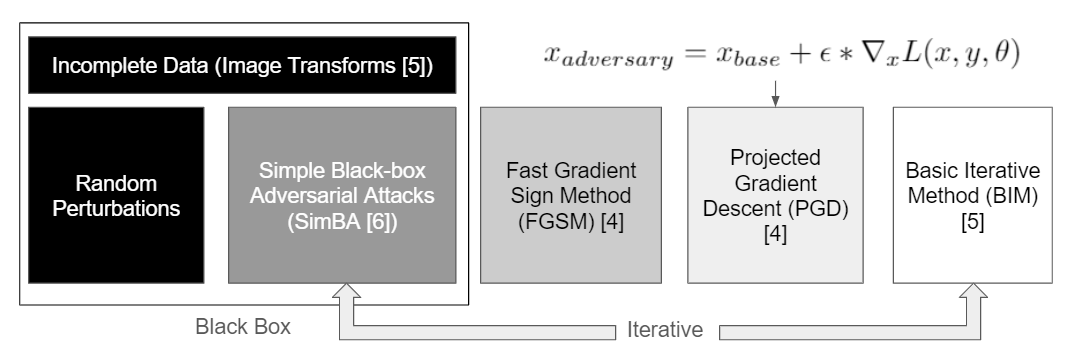



##Adversaries in Detail

Each form of adversary is elaborated on below.

Image Transforms: 
1. Random Rotate (any angle):
$$ x_{base} \rightarrow x_{rotate} $$
2. Random Shift up to 4 pixels ($\frac{1}{8}$ image dimension) in any direction:
$$ x_{base} \rightarrow x_{shift} $$
3. Rando Scale from 80% to 120% of the original image dimension followed by a crop to the original 28 x 28 size:
$$ x_{base} \rightarrow x_{scale} $$
4. Random Affine - composition of items (1-3):
$$ x_{base} \rightarrow x_{affine} $$
5. Random Brightness - Intensity scaling by a factor of 0.2 to 2 followed by saturation to the {0,1} range.
$$ x_{base} \rightarrow x_{brightness} $$
6. Random Gaussian Blur using kernel size of 3 x 3 with a random variance from 0.25 to 1. 
$$ x_{base} \rightarrow x_{blur} $$
7. Random composition of items 4 and 6.
$$ x_{base} \rightarrow x_{affine\ with\ blur} $$

Random Perturbations: 
$$ x_{rp} = x_{base} + \epsilon * x_{random} $$

SimBA :
Here y is the correct label and Q is the image basis typically taken as a set of Kronecker Delta ($\delta_{i,j}$) on each pixel position. Note that the untargetted variant is utilized, focussing on decreasing the probability of correct classification rather than increase the probability of a particular false-target class.

>procedure SimBA($x_{base},y,Q,\epsilon,iterations$) : 
>> while i < iterations do:
>>> $\mathbf{P} = p_h(y|x)$
>>>
>>> pick randomly with replacement: $q \in Q$
>>> 
>>> $\mathbf{P_L} = p_h(y|x-q*\epsilon)$
>>> 
>>> $\mathbf{P_R} = p_h(y|x+q*\epsilon)$
>>> 
>>> if min($\mathbf{P},\mathbf{P_L},\mathbf{P_R}$) is $\mathbf{P_L}$:
>>>>$x \leftarrow x - \epsilon*q$ 
>>>
>>> if min($\mathbf{P},\mathbf{P_L},\mathbf{P_R}$) is $\mathbf{P_R}$:
>>>>$x \leftarrow x + \epsilon*q$
>>> 
>>> $i \leftarrow i+1$
>>
>>return x

FGSM - Where $L(x,y,\theta)$ is the model loss function and $\nabla_x$ the gradient with respect to the inputs :
$$ x_{FGSM} = x_{base} + \epsilon * sign(\nabla_x L(x,y,\theta)) $$

PGD :
$$ x_{PGD} = x_{base} + \epsilon * \frac{\nabla_x L(x,y,\theta)}{||\nabla_x L(x,y,\theta)||_2} $$

BIM :
> procedure BIM($x,L,\delta,iterations$):
>>while i < iterations:
>>>$x \leftarrow x + \frac{\epsilon}{\delta} * \frac{\nabla_x L(x,y,\theta)}{||\nabla_x L(x,y,\theta)||_2}$
>>>
>>> $i \leftarrow i+1$
>>
>>return x

Note that in all above procedures clipping to valid $\epsilon$-budget and $\{0,1\}$ pixel range was applied before function return.

##Baseline Classifiers

To generate the white-box threats baseline classiers must first be trained. To foccuss on nueral networks three simple classifiers weere trained on the training set to perform classification using Binary Cross Entropy Loss for classification and the Adam optimizer for learning rate scheduling on stochastic gradient descent. One classifier is based on fully connected layers (FF), the second is primarly based on convolutional layers (CNN), and finally the third has a slighly more complex network structure with both convlutional and fully connected layers (comp or composite). Bilinear interpolation up-sampling layers are used in the body of the these architectures and the upsampling factor was tuned for improved performance. A certain degree of upsampling allowed for sufficient image sizes for deper and wider networks. The loss and accuracy on development data is graphed against total training batches (50 images) below for the composite architecture. 

**Note that for the code provided here all models will provide training plots when trained but not if loaded from the save path, to force generation of the training plot a model must be deleted from the save path and retrained.**

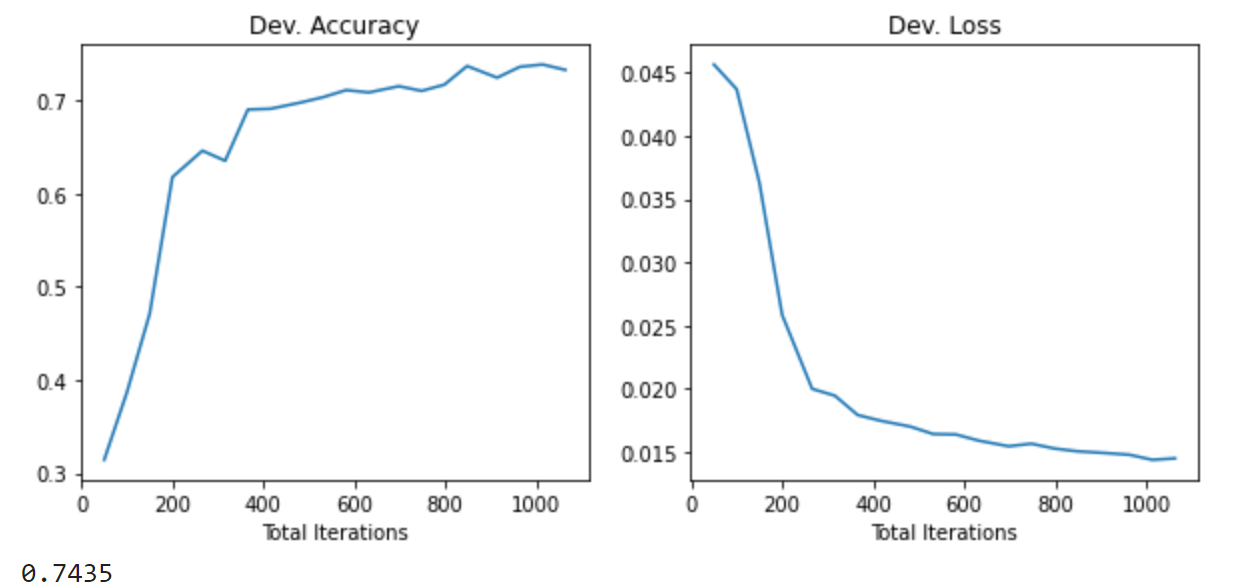


In [ ]:
#@title ANN Based Baseline Classifiers Definitions { form-width: "20%" }

class FF(torch.nn.Module):
  def __init__(self,in_flat_dim,up1,out_dim,h1,h2):
    super(FF, self).__init__()
    self.flat_dim = up1*up1*in_flat_dim
    self.up0 = torch.nn.UpsamplingBilinear2d(scale_factor=up1)
    self.linear1 = torch.nn.Linear(up1*up1*in_flat_dim, h1)
    self.linear2 = torch.nn.Linear(h1,h2)
    self.linear3 = torch.nn.Linear(h2,out_dim)

  def forward(self,x):
    x = self.up0(x)
    x = x.reshape(x.shape[0],self.flat_dim)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    return self.linear3(x) # Need softmax outside (CE loss)
  
class CNN(torch.nn.Module):
  def __init__(self,up1,out_dim,chan1,chan2,chan3,k1,k2,k3,p12,color):
    super(CNN,self).__init__()
    self.up0 = torch.nn.UpsamplingBilinear2d(scale_factor=up1)
    self.conv1 = torch.nn.Conv2d(color,chan1,kernel_size=k1)
    self.conv2 = torch.nn.Conv2d(chan1,chan2,kernel_size=k2)
    self.conv3 = torch.nn.Conv2d(chan2,chan3,k3)
    self.linear4 = torch.nn.Linear(chan3,out_dim)
    self.pool12 = nn.MaxPool2d(p12,p12)
  def forward(self,x):
    x = self.up0(x)
    x = F.relu(self.conv1(x))
    x = self.pool12(x)
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    pool_lin = nn.MaxPool2d(x.shape[2],x.shape[3])
    x = pool_lin(x)
    x = torch.flatten(x,start_dim=1,end_dim=-1)
    x = F.relu(self.linear4(x)) # Need softmax outside (CE loss)
    return x

class composite(torch.nn.Module):
  def __init__(self,up1,out_dim,chan1,chan2,chan3,k1,k2,k3,h4,h5,p12,p23,color):
    super(composite,self).__init__()
    self.up0 = torch.nn.UpsamplingBilinear2d(scale_factor=up1)
    self.conv1 = torch.nn.Conv2d(color,chan1,kernel_size=k1)
    self.conv2 = torch.nn.Conv2d(chan1,chan2,kernel_size=k2)
    self.conv3 = torch.nn.Conv2d(chan2,chan3,kernel_size=k3)
    self.linear4 = torch.nn.Linear(chan3,h4)
    self.linear5 = torch.nn.Linear(h4,h5)
    self.linear6 = torch.nn.Linear(h5,out_dim)

    self.pool12 = nn.MaxPool2d(p12,p12)
    self.pool23 = nn.MaxPool2d(p23,p23)
  
  def forward(self,x):
    x = self.up0(x)
    x = F.relu(self.conv1(x))
    x = self.pool12(x)
    x = F.relu(self.conv2(x))
    x = self.pool23(x)
    x = F.relu(self.conv3(x))
    pool_lin = nn.MaxPool2d(x.shape[2],x.shape[3])
    x = pool_lin(x)
    x = torch.flatten(x,start_dim=1,end_dim=-1)
    x = F.relu(self.linear4(x))
    x = F.relu(self.linear5(x))
    return self.linear6(x) # Need softmax outside (CE loss)


In [ ]:
#@title Trainloader Train/Dev and Test Loop { form-width: "20%" }

def train(model, optimizer, trainloader, name, epoch=2,
          loss_fcn=torch.nn.CrossEntropyLoss(),clip=False, 
          plot=False,devloader=None,denoiser=None):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()

  plot_batch = 50 # save plotting data every 50 mini-batches
  print_batch = 1 # print every 4*50 = 200 mini-batches

  iteration_track = []
  devloss_track = []
  devacc_track = []
  batch_count = 0

  running_loss=0
  for ep in range(epoch):
    print_idx = 0
    for i_batch, data in enumerate(trainloader,0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      inputs = inputs.float()

      if (len(labels.shape)==3):
        labels = torch.unsqueeze(labels,1)

      if (len(inputs.shape)==3):
        inputs = torch.unsqueeze(inputs,1)

      if (denoiser):
        inputs = denoiser(inputs)

      output = model(inputs)


      loss = loss_fcn(output, labels)
      loss.backward()
      if (clip==True):
        torch.nn.utils.clip_grad_value_(model.parameters(),0.00001)
      optimizer.step()
      
      running_loss += loss.item()
      batch_count+=1
      if i_batch % plot_batch == plot_batch-1:  
        if (print_idx % print_batch == print_batch-1):  
          print('[%d, %5d] loss: %.3f' %
            (ep + 1, i_batch + 1, running_loss / plot_batch))
        print_idx += 1
        running_loss = 0.0
        if (plot):
          iteration_track = np.append(iteration_track,batch_count)
          dev_acc, dev_loss = test(model,devloader,loss_fcn=loss_fcn)
          devacc_track = np.append(devacc_track,dev_acc)
          devloss_track = np.append(devloss_track,dev_loss.cpu())

          model.train()
  if (plot):
    fig,a =  plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    a[0].plot(iteration_track,devacc_track)
    a[0].set_title('Dev. Accuracy')
    a[0].set_xlabel("Total Iterations")
    #a[0].set_ylim([0, 1])
    a[1].plot(iteration_track,devloss_track)
    a[1].set_title('Dev. Loss')
    a[1].set_xlabel("Total Iterations")
    plt.show()

  SAVE_PATH = PATH + name + '.pth'
  torch.save(model.state_dict(), SAVE_PATH)

def test(model, testloader,loss_fcn=None,denoiser=None): # Use a loss fcn for dev_set
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data in testloader:
          inputs, labels = data
          inputs = inputs.float()
          try:
            inputs, labels = inputs.to(device), labels.to(device)
          except:
            print("Found String in Data")
            continue
          if (len(labels.shape)==3):
            labels = torch.unsqueeze(labels,1)
          if (len(inputs.shape)==3):
            inputs = torch.unsqueeze(inputs,1)

          if (denoiser):
            inputs = denoiser(inputs)

          output = model(inputs.float())
          if (len(output.shape)<2):
            output = torch.unsqueeze(output,0)

          if (loss_fcn):
            total_loss += loss_fcn(output, labels)

          _, pred = torch.max(output.data, 1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()
    return (correct / total), (total_loss / total)


In [ ]:
#@title Train FF { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_ff = FF(in_flat_dim=28*28*1,up1=3,out_dim=10,h1=1000,h2=100)
mnist_ff.to(device)
optimizer = torch.optim.Adam(mnist_ff.parameters(),lr=0.00001)

SAVE_PATH = PATH + 'mnist_ff.pth'
if os.path.isfile(SAVE_PATH):
  mnist_ff.load_state_dict(torch.load(SAVE_PATH))
else:
  train(mnist_ff,optimizer,mnist_trainloader,"mnist_ff",epoch=5,plot=True,devloader=mnist_devloader)

baseline_ff = test(mnist_ff,mnist_testloader)[0]
print(baseline_ff)


0.797


In [ ]:
#@title Train CNN { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_cnn = CNN(
    up1=3,out_dim=10,chan1=128,chan2=64,chan3=32,k1=17,k2=9,k3=3,p12=2,color=1)
mnist_cnn.to(device)
optimizer = torch.optim.Adam(mnist_cnn.parameters(),lr=0.00001,weight_decay=1e-5)

SAVE_PATH = PATH + 'mnist_cnn.pth'
if os.path.isfile(SAVE_PATH):
  mnist_cnn.load_state_dict(torch.load(SAVE_PATH))
else:
  train(mnist_cnn,optimizer,mnist_trainloader,"mnist_cnn",epoch=10,plot=True,devloader=mnist_devloader)

baseline_cnn = test(mnist_cnn,mnist_testloader)[0]
print(baseline_cnn)


0.4485


In [ ]:
#@title Train Composite { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_comp = composite(up1=8,out_dim=10,chan1=100,chan2=60,chan3=40,k1=25,k2=17,k3=7,
                   h4=100,h5=100,p12=4,p23=3,color=1)
mnist_comp.to(device)
optimizer = torch.optim.Adam(mnist_comp.parameters(),lr=0.00001)

SAVE_PATH = PATH + 'mnist_comp.pth'
if os.path.isfile(SAVE_PATH):
  mnist_comp.load_state_dict(torch.load(SAVE_PATH))
else:
  train(mnist_comp,optimizer,mnist_trainloader,"mnist_comp",epoch=5,plot=True,devloader=mnist_devloader)

baseline_comp = test(mnist_comp,mnist_testloader)[0]
print(baseline_comp)

0.7465


##Adversarial Generation

With Baseline Classifiers in Place and thus their loss functions, attack datasets can be generated. 

###Image Transform Attacks

Generation and visualization

In [ ]:
#@title Image Transform Attacks { form-width: "20%" }

## TODO: Completely untested, all transform parameters (angle, range, etc.
## need to be tuned). USES TORCHVISION

def generic_random_transform(p_transform, data_orig, labels_orig, transform_func):
  x_transformed = np.empty_like(data_orig[0])
  x_transformed = np.expand_dims(x_transformed, axis=0)
  y_transformed = np.empty_like(labels_orig[0])
  #x_orig = np.empty_like(data_orig[0])
  #x_orig = np.expand_dims(x_orig,axis=0)

  for (target,example,idx) in zip(labels_orig,data_orig,range(len(labels_orig))):
    example = torch.from_numpy(example)
    if (len(example.shape)<3):
      example = torch.unsqueeze(example,0)

    if (rn.uniform(0,1)<p_transform):
      #x_orig = np.append(x_orig,example.numpy(),axis=0)
      temp = transform_func(example).numpy()
      x_transformed = np.append(x_transformed,temp,axis=0)
      y_transformed = np.append(y_transformed,target)
  
  return x_transformed[1:], y_transformed[1:]

def brightness(p_transform, data_orig, labels_orig):
  x_transformed = np.empty_like(data_orig[0])
  x_transformed = np.expand_dims(x_transformed, axis=0)
  y_transformed = np.empty_like(labels_orig[0])
  #x_orig = np.empty_like(data_orig[0])
  #x_orig = np.expand_dims(x_orig,axis=0)

  for (target,example,idx) in zip(labels_orig,data_orig,range(len(labels_orig))):
    example = torch.from_numpy(example)
    if (len(example.shape)<3):
      example = torch.unsqueeze(example,0)

    if (rn.uniform(0,1)<p_transform):
      #x_orig = np.append(x_orig,example.numpy(),axis=0)
      #temp = transform_func(example).numpy()
      factor = rn.uniform(0.2,2)
      temp = example.numpy() * factor
      temp = np.clip(temp, 0, 1)
      x_transformed = np.append(x_transformed,temp,axis=0)
      y_transformed = np.append(y_transformed,target)
  
  return x_transformed[1:], y_transformed[1:]

def random_rotate(p_transform, data_orig, labels_orig):
  rotate = transforms.RandomRotation((-180, 180))
  return generic_random_transform(p_transform, data_orig, labels_orig, rotate)

def random_shift(p_transform, data_orig, labels_orig):
  shift = transforms.RandomAffine(degrees=0,translate=(0.125,0.125))
  return generic_random_transform(p_transform, data_orig, labels_orig, shift)

def random_scale(p_transform, data_orig, labels_orig):
  scale = transforms.RandomAffine(degrees=0,scale=(0.8,1.2))
  return generic_random_transform(p_transform, data_orig, labels_orig, scale)

# Doesn't seem to work
def random_crop(p_transform, data_orig, labels_orig):
  crop = transforms.RandomCrop(data_orig[0].shape, pad_if_needed=True)
  return generic_random_transform(p_transform, data_orig, labels_orig, crop)

def random_affine(p_transform, data_orig, labels_orig):
  affine = transforms.RandomAffine(degrees=40,translate=(0.125,0.125),scale=(0.8,1.2))
  return generic_random_transform(p_transform, data_orig, labels_orig, affine)

# Doesn't seem to work
def random_brightness(p_transform, data_orig, labels_orig):
#  brightness = transforms.ColorJitter(brightness=(0.5,1.5))
#  return generic_random_transform(p_transform, data_orig, labels_orig, brightness)
  return brightness(p_transform, data_orig, labels_orig)

# Doesn't seem to work
def random_color(p_transform, data_orig, labels_orig):
  def color(example):
    return rn.uniform(0.8,1.2) * example
  return generic_random_transform(p_transform, data_orig, labels_orig, color)

def random_blur(p_transform, data_orig, labels_orig):
  def blur(example):
    k = rn.randint(data_orig[0].shape[1]/8)
    if (k % 2 == 0):
      k = k + 1
    blur_temp = transforms.GaussianBlur(kernel_size=3,sigma=(0.5,1))
    return blur_temp(example)
  return generic_random_transform(p_transform, data_orig, labels_orig, blur)

def random_composite(p_transform, data_orig, labels_orig):
  def composite(example):
    temp = rn.uniform(0.8,1.2) * example
    affine = transforms.RandomAffine(degrees=40,translate=(0.125,0.125),scale=(1,1.5))
    return affine(temp)
  return generic_random_transform(p_transform, data_orig, labels_orig, composite)

def random_composite_blur(p_transform, data_orig, labels_orig):
  def composite_blur(example):
    #temp = rn.uniform(0.8,1.2) * example
    temp = example
    affine = transforms.RandomAffine(degrees=40,translate=(0.125,0.125),scale=(1,1.5))
    temp = affine(temp)

    k = rn.randint(data_orig[0].shape[1]/8)
    if (k % 2 == 0):
      k = k + 1
    blur_temp = transforms.GaussianBlur(kernel_size=3,sigma=(0.5,1))
    return blur_temp(temp)
  return generic_random_transform(p_transform, data_orig, labels_orig, composite_blur)

In [ ]:
#@title Generate Transforms { form-width: "20%" }

SAVE_PATH = PATH + 'x_rotated' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    x_rotated = np.load(f) 
  SAVE_PATH = PATH + 'y_rotated' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_rotated = np.load(f) 

  SAVE_PATH = PATH + 'x_shifted' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_shifted = np.load(f) 
  SAVE_PATH = PATH + 'y_shifted' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_shifted = np.load(f) 

  SAVE_PATH = PATH + 'x_scaled' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_scaled = np.load(f) 
  SAVE_PATH = PATH + 'y_scaled' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_scaled = np.load(f)

  SAVE_PATH = PATH + 'x_affine' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_affine = np.load(f) 
  SAVE_PATH = PATH + 'y_affine' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_affine = np.load(f)  

  SAVE_PATH = PATH + 'x_brightness' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_brightness = np.load(f) 
  SAVE_PATH = PATH + 'y_brightness' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_brightness = np.load(f) 

  SAVE_PATH = PATH + 'x_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_blur = np.load(f) 
  SAVE_PATH = PATH + 'y_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_blur = np.load(f) 

  SAVE_PATH = PATH + 'x_composite_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_composite_blur = np.load(f) 
  SAVE_PATH = PATH + 'y_composite_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_composite_blur = np.load(f)
    ###########################
  SAVE_PATH = PATH + 'x_train_rotated' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_train_rotated = np.load(f) 
  SAVE_PATH = PATH + 'y_train_rotated' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_train_rotated = np.load(f) 

  SAVE_PATH = PATH + 'x_train_shifted' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_train_shifted = np.load(f) 
  SAVE_PATH = PATH + 'y_train_shifted' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_train_shifted = np.load(f) 

  SAVE_PATH = PATH + 'x_train_scaled' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_train_scaled = np.load(f) 
  SAVE_PATH = PATH + 'y_train_scaled' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_train_scaled = np.load(f)

  SAVE_PATH = PATH + 'x_train_affine' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_train_affine = np.load(f) 
  SAVE_PATH = PATH + 'y_train_affine' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_train_affine = np.load(f)  

  SAVE_PATH = PATH + 'x_train_brightness' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_train_brightness = np.load(f) 
  SAVE_PATH = PATH + 'y_train_brightness' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_train_brightness = np.load(f) 

  SAVE_PATH = PATH + 'x_train_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_train_blur = np.load(f) 
  SAVE_PATH = PATH + 'y_train_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_train_blur = np.load(f) 

  SAVE_PATH = PATH + 'x_train_composite_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_train_composite_blur = np.load(f) 
  SAVE_PATH = PATH + 'y_train_composite_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_train_composite_blur = np.load(f)
else:
  x_rotated, y_rotated = random_rotate(1, mnist_x["dev"],mnist_y["dev"])
  x_shifted, y_shifted = random_shift(1, mnist_x["dev"],mnist_y["dev"])

  x_scaled, y_scaled = random_scale(1, mnist_x["dev"],mnist_y["dev"])
  #x_cropped, y_cropped = random_crop(1, mnist_x["dev"],mnist_y["dev"])

  x_affine, y_affine = random_affine(1, mnist_x["dev"],mnist_y["dev"])
  x_brightness, y_brightness = random_brightness(1, mnist_x["dev"],mnist_y["dev"])

  #x_color, y_color = random_color(1, mnist_x["dev"],mnist_y["dev"])

  x_blur, y_blur = random_blur(1, mnist_x["dev"],mnist_y["dev"])

  #x_composite, y_composite = random_composite(1, mnist_x["dev"],mnist_y["dev"])
  x_composite_blur, y_composite_blur = random_composite_blur(1, mnist_x["dev"],mnist_y["dev"])

  x_train_rotated, y_train_rotated = random_rotate(1, mnist_x["train"],mnist_y["train"])
  x_train_shifted, y_train_shifted = random_shift(1, mnist_x["train"],mnist_y["train"])

  x_train_scaled, y_train_scaled = random_scale(1, mnist_x["train"],mnist_y["train"])

  x_train_affine, y_train_affine = random_affine(1, mnist_x["train"],mnist_y["train"])
  x_train_brightness, y_train_brightness = random_brightness(1, mnist_x["train"],mnist_y["train"])

  x_train_blur, y_train_blur = random_blur(1, mnist_x["train"],mnist_y["train"])

  x_train_composite_blur, y_train_composite_blur = random_composite_blur(1, mnist_x["train"],mnist_y["train"])
  
  with open(PATH + 'x_rotated' + '.npy', 'wb') as f:
    np.save(f, x_rotated)
  with open(PATH + 'y_rotated' + '.npy', 'wb') as f:
    np.save(f, y_rotated)
  with open(PATH + 'x_shifted' + '.npy', 'wb') as f:
    np.save(f, x_shifted)
  with open(PATH + 'y_shifted' + '.npy', 'wb') as f:
    np.save(f, y_shifted)
  with open(PATH + 'x_scaled' + '.npy', 'wb') as f:
    np.save(f, x_scaled)
  with open(PATH + 'y_scaled' + '.npy', 'wb') as f:
    np.save(f, y_scaled)
  with open(PATH + 'x_affine' + '.npy', 'wb') as f:
    np.save(f, x_affine)
  with open(PATH + 'y_affine' + '.npy', 'wb') as f:
    np.save(f, y_affine)
  with open(PATH + 'x_brightness' + '.npy', 'wb') as f:
    np.save(f, x_brightness)
  with open(PATH + 'y_brightness' + '.npy', 'wb') as f:
    np.save(f, y_brightness)
  with open(PATH + 'x_blur' + '.npy', 'wb') as f:
    np.save(f, x_blur)
  with open(PATH + 'y_blur' + '.npy', 'wb') as f:
    np.save(f, y_blur)
  with open(PATH + 'x_composite_blur' + '.npy', 'wb') as f:
    np.save(f, x_composite_blur)
  with open(PATH + 'y_composite_blur' + '.npy', 'wb') as f:
    np.save(f, y_composite_blur)

  with open(PATH + 'x_train_rotated' + '.npy', 'wb') as f:
    np.save(f, x_train_rotated)
  with open(PATH + 'y_train_rotated' + '.npy', 'wb') as f:
    np.save(f, y_train_rotated)
  with open(PATH + 'x_train_shifted' + '.npy', 'wb') as f:
    np.save(f, x_train_shifted)
  with open(PATH + 'y_train_shifted' + '.npy', 'wb') as f:
    np.save(f, y_train_shifted)
  with open(PATH + 'x_train_scaled' + '.npy', 'wb') as f:
    np.save(f, x_train_scaled)
  with open(PATH + 'y_train_scaled' + '.npy', 'wb') as f:
    np.save(f, y_train_scaled)
  with open(PATH + 'x_train_affine' + '.npy', 'wb') as f:
    np.save(f, x_train_affine)
  with open(PATH + 'y_train_affine' + '.npy', 'wb') as f:
    np.save(f, y_train_affine)
  with open(PATH + 'x_train_brightness' + '.npy', 'wb') as f:
    np.save(f, x_train_brightness)
  with open(PATH + 'y_train_brightness' + '.npy', 'wb') as f:
    np.save(f, y_train_brightness)
  with open(PATH + 'x_train_blur' + '.npy', 'wb') as f:
    np.save(f, x_train_blur)
  with open(PATH + 'y_train_blur' + '.npy', 'wb') as f:
    np.save(f, y_train_blur)
  with open(PATH + 'x_train_composite_blur' + '.npy', 'wb') as f:
    np.save(f, x_train_composite_blur)
  with open(PATH + 'y_train_composite_blur' + '.npy', 'wb') as f:
    np.save(f, y_train_composite_blur)


SAVE_PATH = PATH + 'x_test_rotated' + '.npy'
if os.path.isfile(SAVE_PATH):
  SAVE_PATH = PATH + 'x_test_rotated' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_test_rotated = np.load(f) 
  SAVE_PATH = PATH + 'y_test_rotated' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_test_rotated = np.load(f) 

  SAVE_PATH = PATH + 'x_test_shifted' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_test_shifted = np.load(f) 
  SAVE_PATH = PATH + 'y_test_shifted' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_test_shifted = np.load(f) 

  SAVE_PATH = PATH + 'x_test_scaled' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_test_scaled = np.load(f) 
  SAVE_PATH = PATH + 'y_test_scaled' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_test_scaled = np.load(f)

  SAVE_PATH = PATH + 'x_test_affine' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_test_affine = np.load(f) 
  SAVE_PATH = PATH + 'y_test_affine' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_test_affine = np.load(f)  

  SAVE_PATH = PATH + 'x_test_brightness' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_test_brightness = np.load(f) 
  SAVE_PATH = PATH + 'y_test_brightness' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_test_brightness = np.load(f) 

  SAVE_PATH = PATH + 'x_test_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_test_blur = np.load(f) 
  SAVE_PATH = PATH + 'y_test_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_test_blur = np.load(f) 

  SAVE_PATH = PATH + 'x_test_composite_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    x_test_composite_blur = np.load(f) 
  SAVE_PATH = PATH + 'y_test_composite_blur' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    y_test_composite_blur = np.load(f)
else:
  x_test_rotated, y_test_rotated = random_rotate(1, mnist_x["test"],mnist_y["test"])
  x_test_shifted, y_test_shifted = random_shift(1, mnist_x["test"],mnist_y["test"])

  x_test_scaled, y_test_scaled = random_scale(1, mnist_x["test"],mnist_y["test"])

  x_test_affine, y_test_affine = random_affine(1, mnist_x["test"],mnist_y["test"])
  x_test_brightness, y_test_brightness = random_brightness(1, mnist_x["test"],mnist_y["test"])

  x_test_blur, y_test_blur = random_blur(1, mnist_x["test"],mnist_y["test"])

  x_test_composite_blur, y_test_composite_blur = random_composite_blur(1, mnist_x["test"],mnist_y["test"])

  with open(PATH + 'x_test_rotated' + '.npy', 'wb') as f:
    np.save(f, x_test_rotated)
  with open(PATH + 'y_test_rotated' + '.npy', 'wb') as f:
    np.save(f, y_test_rotated)
  with open(PATH + 'x_test_shifted' + '.npy', 'wb') as f:
    np.save(f, x_test_shifted)
  with open(PATH + 'y_test_shifted' + '.npy', 'wb') as f:
    np.save(f, y_test_shifted)
  with open(PATH + 'x_test_scaled' + '.npy', 'wb') as f:
    np.save(f, x_test_scaled)
  with open(PATH + 'y_test_scaled' + '.npy', 'wb') as f:
    np.save(f, y_test_scaled)
  with open(PATH + 'x_test_affine' + '.npy', 'wb') as f:
    np.save(f, x_test_affine)
  with open(PATH + 'y_test_affine' + '.npy', 'wb') as f:
    np.save(f, y_test_affine)
  with open(PATH + 'x_test_brightness' + '.npy', 'wb') as f:
    np.save(f, x_test_brightness)
  with open(PATH + 'y_test_brightness' + '.npy', 'wb') as f:
    np.save(f, y_test_brightness)
  with open(PATH + 'x_test_blur' + '.npy', 'wb') as f:
    np.save(f, x_test_blur)
  with open(PATH + 'y_test_blur' + '.npy', 'wb') as f:
    np.save(f, y_test_blur)
  with open(PATH + 'x_test_composite_blur' + '.npy', 'wb') as f:
    np.save(f, x_test_composite_blur)
  with open(PATH + 'y_test_composite_blur' + '.npy', 'wb') as f:
    np.save(f, y_test_composite_blur)

7
sneaker: 7
0.41176468
0.23381394


<Figure size 432x288 with 0 Axes>

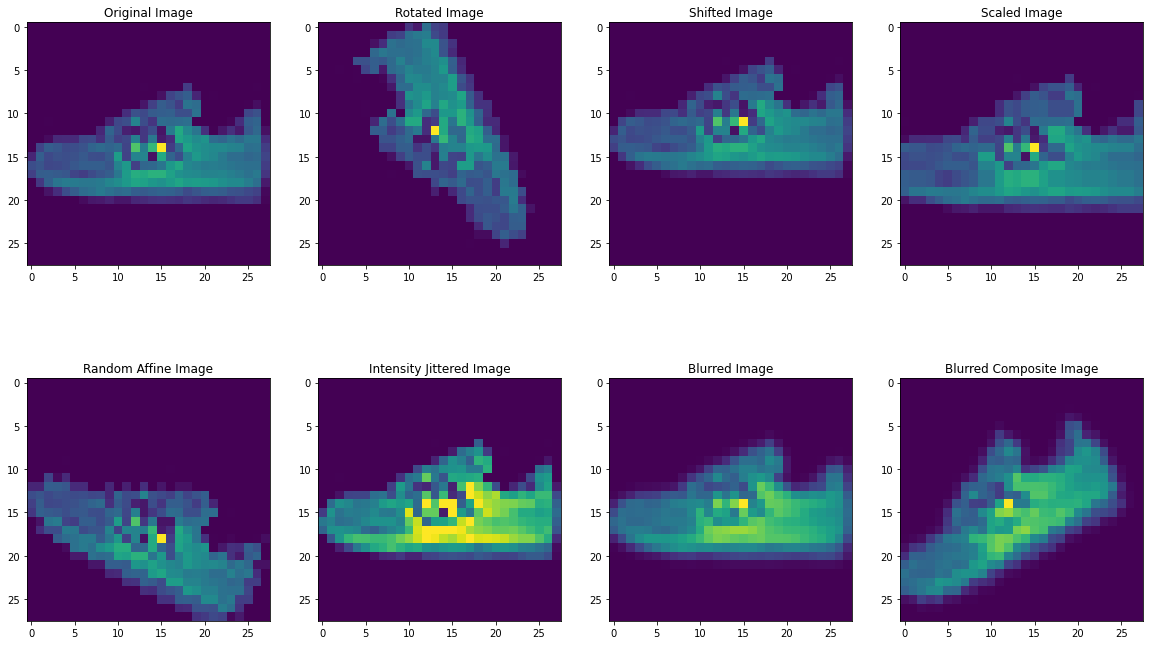

In [ ]:
#@title Visualize Transforms { form-width: "20%" }

idx = 41

print(y_rotated[idx])

fig = plt.figure()
print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))

fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow(mnist_x["dev"][idx])

ax[0][1].set_title("Rotated Image")
ax[0][1].imshow(x_rotated[idx])

ax[0][2].set_title("Shifted Image")
ax[0][2].imshow(x_shifted[idx])

ax[0][3].set_title("Scaled Image")
ax[0][3].imshow(x_scaled[idx])

#ax[0][4].set_title("Cropped Image")
#ax[0][4].imshow(x_cropped[idx])

ax[1][0].set_title("Random Affine Image")
ax[1][0].imshow(x_affine[idx])

ax[1][1].set_title("Intensity Jittered Image")
ax[1][1].imshow(x_brightness[idx])
print(np.max(x_brightness[idx] - mnist_x["dev"][idx]))

#ax[1][1].set_title("Color Jitter Image")
#ax[1][1].imshow(x_color[idx])
#print(np.max(x_color[idx] - mnist_x["dev"][idx]))

ax[1][2].set_title("Blurred Image")
ax[1][2].imshow(x_blur[idx])
print(np.max(x_blur[idx] - mnist_x["dev"][idx]))

#ax[1][3].set_title("Composite Attack Image")
#ax[1][3].imshow(x_composite[idx])

ax[1][3].set_title("Blurred Composite Image")
ax[1][3].imshow(x_composite_blur[idx])



In [ ]:
#@title Make Full Transform Attack Set { form-width: "20%" }
transform_attack_x_devraw = [x_rotated, x_shifted, x_scaled, x_affine,
                      x_brightness, x_blur, x_composite_blur]
transform_attack_x_devraw = np.vstack(transform_attack_x_devraw)
#print(transform_attack_x_devraw.shape)

transform_attack_y_devraw = [y_rotated, y_shifted, y_scaled, y_affine,
                      y_brightness, y_blur, y_composite_blur]
transform_attack_y_devraw = np.hstack(transform_attack_y_devraw)
#print(transform_attack_y_devraw.shape)

transform_attack_im_devraw = [mnist_x["dev"], mnist_x["dev"], mnist_x["dev"], mnist_x["dev"],
                         mnist_x["dev"], mnist_x["dev"], mnist_x["dev"]]
transform_attack_im_devraw = np.vstack(transform_attack_im_devraw)
#print(transform_attack_im_devraw.shape)

transform_attack_devset = ImageDataset(transform_attack_x_devraw,transform_attack_y_devraw)
transform_attack_devloader = DataLoader(transform_attack_devset,50,shuffle=True)

transform_attack_im_devset = ImageDataset(transform_attack_x_devraw,transform_attack_im_devraw)
transform_attack_im_devloader = DataLoader(transform_attack_im_devset,50,shuffle=True)



transform_attack_x_train_raw = [x_train_rotated, x_train_shifted, x_train_scaled, 
                             x_train_affine, x_train_brightness, x_train_blur, 
                             x_train_composite_blur]
transform_attack_x_train_raw = np.vstack(transform_attack_x_train_raw)
#print(transform_attack_x_train_raw.shape)

transform_attack_y_train_raw = [y_train_rotated, y_train_shifted, y_train_scaled,
                               y_train_affine, y_train_brightness, y_train_blur,
                               y_train_composite_blur]
transform_attack_y_train_raw = np.hstack(transform_attack_y_train_raw)
#print(transform_attack_y_train_raw.shape)

transform_attack_im_train_raw = [mnist_x["train"], mnist_x["train"], mnist_x["train"], 
                              mnist_x["train"], mnist_x["train"], mnist_x["train"], 
                              mnist_x["train"]]
transform_attack_im_train_raw = np.vstack(transform_attack_im_train_raw)
#print(transform_attack_im_train_raw.shape)

transform_attack_trainset = ImageDataset(transform_attack_x_train_raw,transform_attack_y_train_raw)
transform_attack_trainloader = DataLoader(transform_attack_trainset,50,shuffle=True)

transform_attack_im_trainset = ImageDataset(transform_attack_x_train_raw,transform_attack_im_train_raw)
transform_attack_im_trainloader = DataLoader(transform_attack_im_trainset,50,shuffle=True)


transform_attack_x_test_raw = [x_test_rotated, x_test_shifted, x_test_scaled, 
                             x_test_affine, x_test_brightness, x_test_blur, 
                             x_test_composite_blur]
transform_attack_x_test_raw = np.vstack(transform_attack_x_test_raw)
with open(PATH + 'transform_attack_x_test_raw' + '.npy', 'wb') as f:
  np.save(f, transform_attack_x_test_raw)
#print(transform_attack_x_test_raw.shape)

transform_attack_y_test_raw = [y_test_rotated, y_test_shifted, y_test_scaled,
                               y_test_affine, y_test_brightness, y_test_blur,
                               y_test_composite_blur]
transform_attack_y_test_raw = np.hstack(transform_attack_y_test_raw)
with open(PATH + 'transform_attack_y_test_raw' + '.npy', 'wb') as f:
  np.save(f, transform_attack_y_test_raw)
#print(transform_attack_y_test_raw.shape)

transform_attack_im_test_raw = [mnist_x["test"], mnist_x["test"], mnist_x["test"], 
                              mnist_x["test"], mnist_x["test"], mnist_x["test"], 
                              mnist_x["test"]]
transform_attack_im_test_raw = np.vstack(transform_attack_im_test_raw)
#print(transform_attack_im_test_raw.shape)

transform_attack_testset = ImageDataset(transform_attack_x_test_raw,transform_attack_y_test_raw)
transform_attack_testloader = DataLoader(transform_attack_testset,50,shuffle=True)

transform_attack_im_testset = ImageDataset(transform_attack_x_test_raw,transform_attack_im_test_raw)
transform_attack_im_testloader = DataLoader(transform_attack_im_testset,50,shuffle=True)

###Random Perturbation Based Attacks (Black-box)

Generation and visualization of RP and SimBA

In [ ]:
#@title Set Params { form-width: "20%" }

idx = 41
delta = 0.1

In [ ]:
#@title RP and SimBA { form-width: "20%" }
# Chop into chunks for faster GPU batching

def make_rand_attacks(name, x,y,model,method,step_size,chunk=50,
                      epsilon=0.1,n_steps=1):
  x_aug = []
  idx = 0
  
  while idx < len(x):
    if (idx + chunk < len(x)):
      x_aug.extend(gen_rand_attack(x[idx:idx+chunk],
                                  y[idx:idx+chunk],
                                  model,method,step_size,
                                  epsilon,n_steps))
    else:
      x_aug.extend(gen_rand_attack(x[idx:len(x)],
                                  y[idx:len(y)],
                                  model,method,step_size,
                                  epsilon,n_steps))
    idx+=chunk
    #print(idx)
  
  output = np.array(x_aug)
  with open(PATH + name + '.npy', 'wb') as f:
    np.save(f, output)
  return output

def gen_rp(x,epsilon):
    r = rn.uniform(-epsilon,epsilon,x.shape)
    return np.clip(x + r, 0, 1) # Pixel range

####################################################################
# Guo, C., Gardner, J., You, Y., Wilson, A. and Weinberger, K., 2019. 
# Simple Black-Box Adversarial Attacks
def get_probs(model, x, y):
  if (len(x.shape)<4):
    x = torch.unsqueeze(x,1)
  output = model(x.float())
  return torch.nn.functional.softmax(output,dim=1)

# (untargeted) SimBA for batch

def simba_single(model, x, y, num_iters=10000, step_size=0.2,epsilon=0.2):
    im = torch.clone(
      torch.from_numpy(x)).detach().requires_grad_(True).to(device)
    im_orig = torch.clone(im).detach().to("cpu")
    for i in range(num_iters):
      last_prob = get_probs(model,im,y)
      x_L = torch.clone(im).detach().to(device)
      x_R = torch.clone(im).detach().to(device)
      for j in range(im.shape[0]):
        dim1 = rn.randint(im[j].shape[0])
        dim2 = rn.randint(im[j].shape[1])
        x_L[j,dim1,dim2] = x_L[j,dim1,dim2] - step_size
        x_R[j,dim1,dim2] = x_R[j,dim1,dim2] + step_size
      x_L = torch.clone(x_L).detach().to("cpu")
      x_L=np.clip(x_L,im_orig-epsilon,im_orig+epsilon)
      x_L = torch.clone(x_L).detach().to(device)
      x_L = x_L.clamp(0,1)
      #################################################
      x_R = torch.clone(x_R).detach().to("cpu")
      x_R=np.clip(x_R,im_orig-epsilon,im_orig+epsilon)
      x_R = torch.clone(x_R).detach().to(device)
      x_R = x_R.clamp(0,1)
      left_prob = get_probs(model,x_L,y)
      right_prob = get_probs(model,x_R,y)
      for j in range(im.shape[0]):
        if left_prob[j,y[j]] < last_prob[j,y[j]]:
          im[j,:,:] = x_L[j,:,:] 
        elif right_prob[j,y[j]] < last_prob[j,y[j]]:
          im[j,:,:] = x_R[j,:,:]
    ret = im.detach().to("cpu").numpy()
    return ret

####################################################################

# Method will either be "RP" or "SimBA"
def gen_rand_attack(x,y,model,method,step_size,epsilon,n_steps):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  if (model):
    model.to(device)
    model.eval()

  if method=="RP":
    augment_x = gen_rp(x,epsilon)
  elif method=="SimBA":
    augment_x = simba_single(model=model,x=x,y=y,num_iters=n_steps,
                             step_size=step_size,epsilon=epsilon)
  else:
    print("Unsupported TYPE (RP or SimBA)")
    return
  augment_x = np.clip(augment_x, x-epsilon,x+epsilon)
  return clean_images(augment_x)



sneaker: 7
Epsilon: 0.1


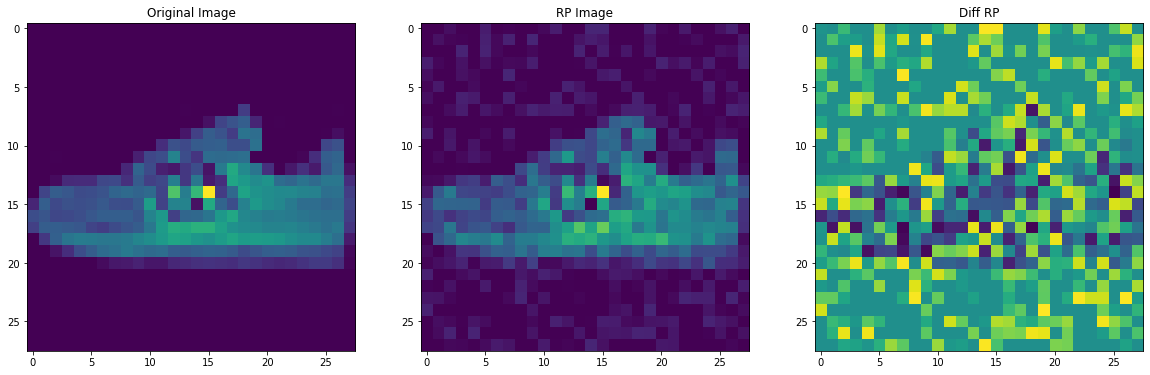

In [ ]:
#@title Generate and visualize RP set, epsilon of 0.1 { form-width: "20%" }

SAVE_PATH = PATH + 'mnist_x_rp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_rp = np.load(f) 
else:
  mnist_x_rp = make_rand_attacks('mnist_x_rp', x=mnist_x["dev"],y=mnist_y["dev"],
                             model=None,method="RP",step_size=None,
                             chunk=50,epsilon=delta,n_steps=None)

# Generate a train-set sized group  
SAVE_PATH = PATH + 'train_mnist_x_rp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_rp = np.load(f) 
else:
  train_mnist_x_rp = make_rand_attacks('train_mnist_x_rp', x=mnist_x["train"],y=mnist_y["train"],
                             model=None,method="RP",step_size=None,
                             chunk=50,epsilon=delta,n_steps=None)
  
SAVE_PATH = PATH + 'test_mnist_x_rp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_rp = np.load(f) 
else:
  test_mnist_x_rp = make_rand_attacks('test_mnist_x_rp', x=mnist_x["test"],y=mnist_y["test"],
                             model=None,method="RP",step_size=None,
                             chunk=50,epsilon=delta,n_steps=None)

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,8))
print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
print("Epsilon: " + str(delta))

ax[0].set_title("Original Image")
ax[0].imshow(mnist_x["dev"][idx])

ax[1].set_title("RP Image")
ax[1].imshow(mnist_x_rp[idx])

ax[2].set_title("Diff RP")
ax[2].imshow(mnist_x_rp[idx]-mnist_x["dev"][idx])

mnist_rp_set = ImageDataset(mnist_x_rp,mnist_y["dev"])
mnist_rp_devloader = DataLoader(mnist_rp_set,50,shuffle=True)

mnist_rp_testset = ImageDataset(test_mnist_x_rp,mnist_y["test"])
mnist_rp_testloader = DataLoader(mnist_rp_testset,50,shuffle=True)

sneaker: 7
Epsilon: 0.30000000000000004
Baselines - FF: 0.797, CNN: 0.4485, Comp.: 0.7465


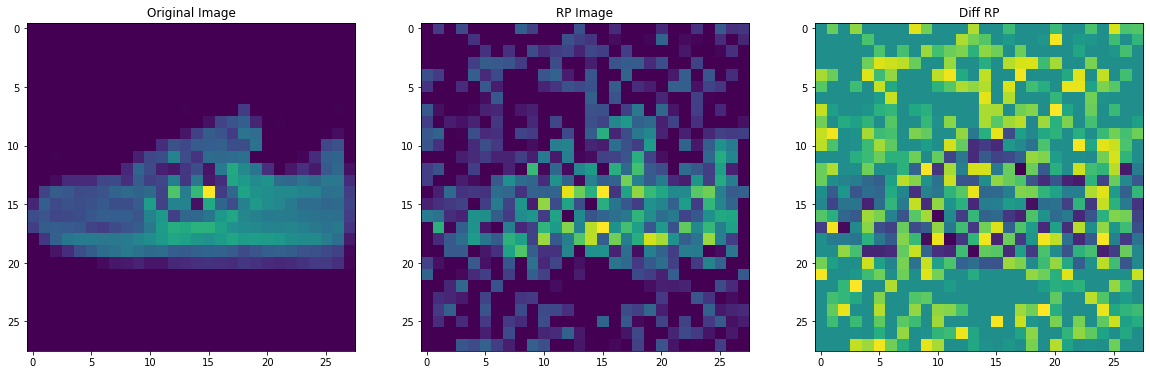

In [ ]:
#@title Generate and visualize a 3 x noisier (epsilon 0.3) RP set { form-width: "20%" }
'''
By default this section has epsilon set to 0.1 in the parameters cell
but to give an idea of a larger epsilon-sphere a random-perturbation attack 
set with 3*epsilon is generated and visualized bellow.
'''

mnist_x_3_rp = make_rand_attacks('mnist_x_rp_3x_epsilon', x=mnist_x["dev"],y=mnist_y["dev"],
                             model=None,method="RP",step_size=None,
                             chunk=50,epsilon=3*delta,n_steps=None)

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,8))
print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
print("Epsilon: " + str(3*delta))

ax[0].set_title("Original Image")
ax[0].imshow(mnist_x["dev"][idx])

ax[1].set_title("RP Image")
ax[1].imshow(mnist_x_3_rp[idx])

ax[2].set_title("Diff RP")
ax[2].imshow(mnist_x_3_rp[idx]-mnist_x["dev"][idx])

mnist_rp_3_set = ImageDataset(mnist_x_3_rp,mnist_y["test"])
mnist_rp_3_devloader = DataLoader(mnist_rp_3_set,50,shuffle=True)

print(f'Baselines - FF: {baseline_ff}, CNN: {baseline_cnn}, Comp.: {baseline_comp}')

In [ ]:
#@title Generate SimBA set { form-width: "20%" }

SAVE_PATH = PATH + 'mnist_x_simba_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_simba_ff = np.load(f) 
else:
  mnist_x_simba_ff = make_rand_attacks('mnist_x_simba_ff', x=mnist_x["dev"],y=mnist_y["dev"],
                             model=mnist_ff,method="SimBA",
                             step_size=1,chunk=50,epsilon=delta,n_steps=200)

SAVE_PATH = PATH + 'mnist_x_simba_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_simba_cnn = np.load(f) 
else:
  mnist_x_simba_cnn = make_rand_attacks('mnist_x_simba_cnn', mnist_x["dev"],mnist_y["dev"],
                             mnist_cnn,"SimBA",1,50,delta,n_steps=200)

SAVE_PATH = PATH + 'mnist_x_simba_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_simba_comp = np.load(f) 
else:
  mnist_x_simba_comp = make_rand_attacks('mnist_x_simba_comp', mnist_x["dev"],mnist_y["dev"],
                             mnist_comp,"SimBA",1,50,delta,n_steps=200)
  
# Generate a train-set sized group  

SAVE_PATH = PATH + 'train_mnist_x_simba_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_simba_ff = np.load(f) 
else:
  train_mnist_x_simba_ff = make_rand_attacks('train_mnist_x_simba_ff', x=mnist_x["train"],y=mnist_y["train"],
                             model=mnist_ff,method="SimBA",
                             step_size=1,chunk=50,epsilon=delta,n_steps=200)

SAVE_PATH = PATH + 'train_mnist_x_simba_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_simba_cnn = np.load(f) 
else:
  train_mnist_x_simba_cnn = make_rand_attacks('train_mnist_x_simba_cnn', mnist_x["train"],mnist_y["train"],
                             mnist_cnn,"SimBA",1,50,delta,n_steps=200)

SAVE_PATH = PATH + 'train_mnist_x_simba_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_simba_comp = np.load(f) 
else:
  train_mnist_x_simba_comp = make_rand_attacks('train_mnist_x_simba_comp', mnist_x["train"],mnist_y["train"],
                             mnist_comp,"SimBA",1,50,delta,n_steps=200)
  

SAVE_PATH = PATH + 'test_mnist_x_simba_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_simba_ff = np.load(f) 
else:
  test_mnist_x_simba_ff = make_rand_attacks('test_mnist_x_simba_ff', x=mnist_x["test"],y=mnist_y["test"],
                             model=mnist_ff,method="SimBA",
                             step_size=1,chunk=50,epsilon=delta,n_steps=200)

SAVE_PATH = PATH + 'test_mnist_x_simba_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_simba_cnn = np.load(f) 
else:
  test_mnist_x_simba_cnn = make_rand_attacks('test_mnist_x_simba_cnn', mnist_x["test"],mnist_y["test"],
                             mnist_cnn,"SimBA",1,50,delta,n_steps=200)

SAVE_PATH = PATH + 'test_mnist_x_simba_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_simba_comp = np.load(f) 
else:
  test_mnist_x_simba_comp = make_rand_attacks('test_mnist_x_simba_comp', mnist_x["test"],mnist_y["test"],
                             mnist_comp,"SimBA",1,50,delta,n_steps=200)

sneaker: 7
Epsilon: 0.1


<Figure size 432x288 with 0 Axes>

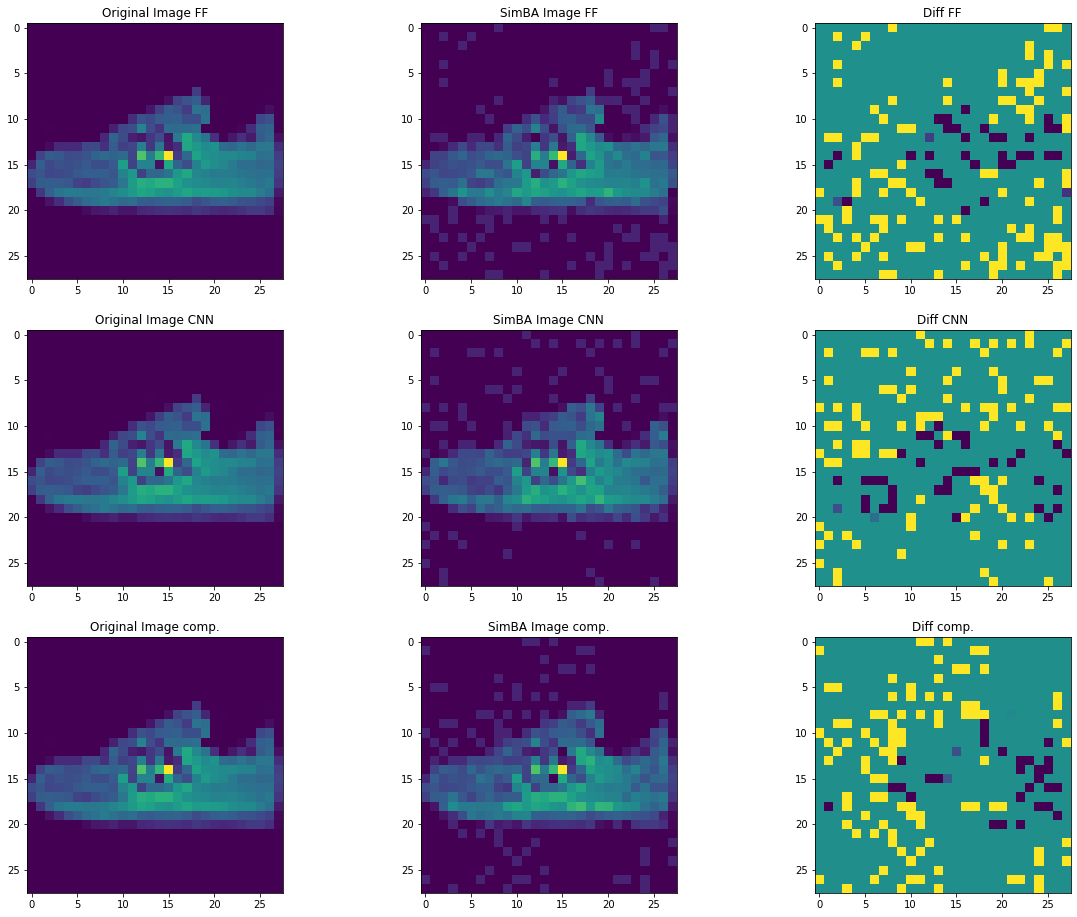

In [ ]:
#@title Visualize SimBA { form-width: "20%" }
fig = plt.figure()
print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(20,16))
print("Epsilon: " + str(delta))

ax[0][0].set_title("Original Image FF")
ax[0][0].imshow(mnist_x["dev"][idx])
ax[0][1].set_title("SimBA Image FF")
ax[0][1].imshow(mnist_x_simba_ff[idx])
ax[0][2].set_title("Diff FF")
ax[0][2].imshow(mnist_x_simba_ff[idx]-mnist_x["dev"][idx])

ax[1][0].set_title("Original Image CNN")
ax[1][0].imshow(mnist_x["dev"][idx])
ax[1][1].set_title("SimBA Image CNN")
ax[1][1].imshow(mnist_x_simba_cnn[idx])
ax[1][2].set_title("Diff CNN")
ax[1][2].imshow(mnist_x_simba_cnn[idx]-mnist_x["dev"][idx])

ax[2][0].set_title("Original Image comp.")
ax[2][0].imshow(mnist_x["dev"][idx])
ax[2][1].set_title("SimBA Image comp.")
ax[2][1].imshow(mnist_x_simba_comp[idx])
ax[2][2].set_title("Diff comp.")
ax[2][2].imshow(mnist_x_simba_comp[idx]-mnist_x["dev"][idx])

mnist_ff_simba_set = ImageDataset(mnist_x_simba_ff,mnist_y["dev"])
mnist_ff_simba_devloader = DataLoader(mnist_ff_simba_set,50,shuffle=True)

mnist_cnn_simba_set = ImageDataset(mnist_x_simba_cnn,mnist_y["dev"])
mnist_cnn_simba_devloader = DataLoader(mnist_cnn_simba_set,50,shuffle=True)

mnist_comp_simba_set = ImageDataset(mnist_x_simba_comp,mnist_y["dev"])
mnist_comp_simba_devloader = DataLoader(mnist_comp_simba_set,50,shuffle=True)

mnist_ff_simba_testset = ImageDataset(test_mnist_x_simba_ff,mnist_y["test"])
mnist_ff_simba_testloader = DataLoader(mnist_ff_simba_testset,50,shuffle=True)

mnist_cnn_simba_testset = ImageDataset(test_mnist_x_simba_cnn,mnist_y["test"])
mnist_cnn_simba_testloader = DataLoader(mnist_cnn_simba_testset,50,shuffle=True)

mnist_comp_simba_testset = ImageDataset(test_mnist_x_simba_comp,mnist_y["test"])
mnist_comp_simba_testloader = DataLoader(mnist_comp_simba_testset,50,shuffle=True)


###Gradient Based Attack

Generation and visualization of attack data for FGSM, PGD, and BIM is presented below.


In [ ]:
#@title Set Params { form-width: "20%" }

delta = 0.2
idx = 41

In [ ]:
#@title Gradient Attacks (PGD,FGSM,BIM) { form-width: "20%" }

## Spits it up into chuncks for efficient mini-batching
def make_grad_attacks(name, x,y,model,loss_fcn,method,step_size,chunk=50,epsilon=0.1,
                      rand=False,n_steps=1):
  x_aug = []
  idx = 0
  
  while idx < len(x):
    if (idx + chunk < len(x)):
      x_aug.extend(gen_grad_attack(x[idx:idx+chunk],
                                  y[idx:idx+chunk],
                                  model,loss_fcn,method,step_size,
                                  epsilon,rand=rand,n_steps=n_steps))
    else:
      x_aug.extend(gen_grad_attack(x[idx:len(x)],
                                  y[idx:len(y)],
                                  model,loss_fcn,method,step_size,
                                  epsilon,rand=rand,n_steps=n_steps))
    idx+=chunk
  
  output = np.array(x_aug)
  with open(PATH + name + '.npy', 'wb') as f:
    np.save(f, output)
  return output

## Get gradient step on CPU as numpy array
def get_grad(x,y,model,loss_fcn,normalize=True):
  target = torch.clone(torch.from_numpy(y)).detach().to(device)
  example_tensor = torch.clone(
      torch.from_numpy(x)).detach().requires_grad_(True).to(device)

  if (len(example_tensor.shape)==3):
    example_tensor = torch.unsqueeze(example_tensor,1)

  if (len(target.shape)==3):
    target = torch.unsqueeze(target,1)

  loss = torch.zeros(1, requires_grad=True)
  output = torch.zeros(example_tensor.shape[0],10,requires_grad=True)

  output = model(example_tensor.float())
  loss = loss_fcn(output,target.long())
  d_loss_dx = grad(outputs=loss, inputs=example_tensor)[0]
  d_loss_dx = d_loss_dx.cpu()

  if (len(d_loss_dx.shape)>3):
    d_loss_dx = np.squeeze(d_loss_dx)

  norm = 1
  if (normalize):
    norm = torch.norm(d_loss_dx,dim=(1,2)).numpy()
    norm[norm==0] = 1
    return d_loss_dx.numpy() / norm[:,None,None]
  else:
    return d_loss_dx.numpy()

## Adapted from Madry et al, ICLR 2018
#######################################################################
# Type must be PGD, FGSM, BIM
def gen_grad_attack(x,y,model,loss_fcn,type,step_size,epsilon,rand,n_steps):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()

  x_orig = x
  if rand:
    x = gen_rp(x,epsilon/4)
  else:
    x = x

  d_loss_dx = get_grad(x,y,model,loss_fcn)
  if type=="PGD":
    augment_x = x + step_size*x*d_loss_dx
  elif type=="FGSM":
    augment_x = x + step_size*np.sign(d_loss_dx)
  elif type=="BIM":
    augment_x = x + step_size*x*d_loss_dx
    for i in range(n_steps-1):
      d_loss_dx = get_grad(augment_x,y,model,loss_fcn)
      augment_x = augment_x + step_size*augment_x*d_loss_dx                                         
  else:
    print("Unsupported TYPE (PGD, FGSM, or BIM)")
    return
  augment_x = np.clip(augment_x, x_orig-epsilon,x_orig+epsilon)
  return clean_images(augment_x)
#####################################################################

In [ ]:
#@title Generate FGSM sets { form-width: "20%" }
loss_fcn = torch.nn.CrossEntropyLoss()

SAVE_PATH = PATH + 'mnist_x_fgsm_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_fgsm_ff = np.load(f) 
else:
  mnist_x_fgsm_ff = make_grad_attacks('mnist_x_fgsm_ff', x=mnist_x["dev"],y=mnist_y["dev"],
                             model=mnist_ff,loss_fcn=loss_fcn,method="FGSM",
                             step_size=0.015,chunk=50,epsilon=delta)

SAVE_PATH = PATH + 'mnist_x_fgsm_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_fgsm_cnn = np.load(f) 
else:
  mnist_x_fgsm_cnn = make_grad_attacks('mnist_x_fgsm_cnn', mnist_x["dev"],mnist_y["dev"],
                             mnist_cnn,loss_fcn,"FGSM",0.02,50,delta)

SAVE_PATH = PATH + 'mnist_x_fgsm_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_fgsm_comp = np.load(f) 
else:
  mnist_x_fgsm_comp = make_grad_attacks('mnist_x_fgsm_comp', mnist_x["dev"],mnist_y["dev"],
                             mnist_comp,loss_fcn,"FGSM",0.02,50,delta)

# Uncomment for a trainset sized attack

SAVE_PATH = PATH + 'train_mnist_x_fgsm_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_fgsm_ff = np.load(f) 
else:
  train_mnist_x_fgsm_ff = make_grad_attacks('train_mnist_x_fgsm_ff', mnist_x["train"],mnist_y["train"],
                             mnist_ff,loss_fcn,"FGSM",0.015,50,delta)
  
SAVE_PATH = PATH + 'train_mnist_x_fgsm_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_fgsm_cnn = np.load(f) 
else:
  train_mnist_x_fgsm_cnn = make_grad_attacks('train_mnist_x_fgsm_cnn', mnist_x["train"],mnist_y["train"],
                             mnist_cnn,loss_fcn,"FGSM",0.02,50,delta)
  
SAVE_PATH = PATH + 'train_mnist_x_fgsm_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_fgsm_comp = np.load(f) 
else:
  train_mnist_x_fgsm_comp = make_grad_attacks('train_mnist_x_fgsm_comp', mnist_x["train"],mnist_y["train"],
                             mnist_comp,loss_fcn,"FGSM",0.02,50,delta)
  

SAVE_PATH = PATH + 'test_mnist_x_fgsm_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_fgsm_ff = np.load(f) 
else:
  test_mnist_x_fgsm_ff = make_grad_attacks('test_mnist_x_fgsm_ff', mnist_x["test"],mnist_y["test"],
                             mnist_ff,loss_fcn,"FGSM",0.015,50,delta)
  
SAVE_PATH = PATH + 'test_mnist_x_fgsm_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_fgsm_cnn = np.load(f) 
else:
  test_mnist_x_fgsm_cnn = make_grad_attacks('test_mnist_x_fgsm_cnn', mnist_x["test"],mnist_y["test"],
                             mnist_cnn,loss_fcn,"FGSM",0.02,50,delta)
  
SAVE_PATH = PATH + 'test_mnist_x_fgsm_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_fgsm_comp = np.load(f) 
else:
  test_mnist_x_fgsm_comp = make_grad_attacks('test_mnist_x_fgsm_comp', mnist_x["test"],mnist_y["test"],
                             mnist_comp,loss_fcn,"FGSM",0.02,50,delta)

mnist_ff_fgsm_testset = ImageDataset(test_mnist_x_fgsm_ff,mnist_y["test"])
mnist_ff_fgsm_testloader = DataLoader(mnist_ff_fgsm_testset,50,shuffle=True)

mnist_cnn_fgsm_testset = ImageDataset(test_mnist_x_fgsm_cnn,mnist_y["test"])
mnist_cnn_fgsm_testloader = DataLoader(mnist_cnn_fgsm_testset,50,shuffle=True)

mnist_comp_fgsm_testset = ImageDataset(test_mnist_x_fgsm_comp,mnist_y["test"])
mnist_comp_fgsm_testloader = DataLoader(mnist_comp_fgsm_testset,50,shuffle=True)


In [ ]:
#@title Generate PGD sets { form-width: "20%" }

SAVE_PATH = PATH + 'mnist_x_pgd_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_pgd_ff = np.load(f) 
else:
  mnist_x_pgd_ff = make_grad_attacks('mnist_x_pgd_ff', x=mnist_x["dev"],y=mnist_y["dev"],
                              model=mnist_ff,loss_fcn=loss_fcn,method="PGD",
                              step_size=2.5,chunk=50,epsilon=delta)
  
SAVE_PATH = PATH + 'mnist_x_pgd_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_pgd_cnn = np.load(f) 
else:
  mnist_x_pgd_cnn = make_grad_attacks('mnist_x_pgd_cnn', mnist_x["dev"],mnist_y["dev"],
                              mnist_cnn,loss_fcn,"PGD",4,50,delta)

SAVE_PATH = PATH + 'mnist_x_pgd_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_pgd_comp = np.load(f) 
else:
  mnist_x_pgd_comp = make_grad_attacks('mnist_x_pgd_comp', mnist_x["dev"],mnist_y["dev"],
                                    mnist_comp,loss_fcn,"PGD",4,50,delta)

# Train set sized attack

SAVE_PATH = PATH + 'train_mnist_x_pgd_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_pgd_ff = np.load(f) 
else:
  train_mnist_x_pgd_ff = make_grad_attacks('train_mnist_x_pgd_ff', mnist_x["train"],mnist_y["train"],
                                    mnist_ff,loss_fcn,"PGD",2.5,50,delta)
  
SAVE_PATH = PATH + 'train_mnist_x_pgd_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_pgd_cnn = np.load(f) 
else:
  train_mnist_x_pdg_cnn = make_grad_attacks('train_mnist_x_pgd_cnn', mnist_x["train"],mnist_y["train"],
                                    mnist_cnn,loss_fcn,"PGD",4,50,delta)
  
SAVE_PATH = PATH + 'train_mnist_x_pgd_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_pgd_comp = np.load(f) 
else:
  train_mnist_x_pdg_comp = make_grad_attacks('train_mnist_x_pgd_comp', mnist_x["train"],mnist_y["train"],
                                    mnist_comp,loss_fcn,"PGD",4,50,delta)
  

SAVE_PATH = PATH + 'test_mnist_x_pgd_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_pgd_ff = np.load(f) 
else:
  test_mnist_x_pgd_ff = make_grad_attacks('test_mnist_x_pgd_ff', mnist_x["test"],mnist_y["test"],
                                    mnist_ff,loss_fcn,"PGD",2.5,50,delta)
  
SAVE_PATH = PATH + 'test_mnist_x_pgd_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_pgd_cnn = np.load(f) 
else:
  test_mnist_x_pdg_cnn = make_grad_attacks('test_mnist_x_pgd_cnn', mnist_x["test"],mnist_y["test"],
                                    mnist_cnn,loss_fcn,"PGD",4,50,delta)
  
SAVE_PATH = PATH + 'test_mnist_x_pgd_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_pgd_comp = np.load(f) 
else:
  test_mnist_x_pdg_comp = make_grad_attacks('test_mnist_x_pgd_comp', mnist_x["test"],mnist_y["test"],
                                    mnist_comp,loss_fcn,"PGD",4,50,delta)

mnist_ff_pgd_testset = ImageDataset(test_mnist_x_pgd_ff,mnist_y["test"])
mnist_ff_pgd_testloader = DataLoader(mnist_ff_pgd_testset,50,shuffle=True)

mnist_cnn_pgd_testset = ImageDataset(test_mnist_x_pgd_cnn,mnist_y["test"])
mnist_cnn_pgd_testloader = DataLoader(mnist_cnn_pgd_testset,50,shuffle=True)

mnist_comp_pgd_testset = ImageDataset(test_mnist_x_pgd_comp,mnist_y["test"])
mnist_comp_pgd_testloader = DataLoader(mnist_comp_pgd_testset,50,shuffle=True)


In [ ]:
#@title Generate BIM sets { form-width: "20%" }

SAVE_PATH = PATH + 'mnist_x_bim_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_bim_ff = np.load(f) 
else:
  mnist_x_bim_ff = make_grad_attacks('mnist_x_bim_ff', x=mnist_x["dev"],y=mnist_y["dev"],
                             model=mnist_ff,loss_fcn=loss_fcn,method="BIM",
                             step_size=0.2,chunk=50,epsilon=delta,n_steps=50)

SAVE_PATH = PATH + 'mnist_x_bim_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_bim_cnn = np.load(f) 
else:
  mnist_x_bim_cnn = make_grad_attacks('mnist_x_bim_cnn', mnist_x["dev"],mnist_y["dev"],
                             mnist_cnn,loss_fcn,"BIM",0.2,50,delta,n_steps=50)

SAVE_PATH = PATH + 'mnist_x_bim_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_bim_comp = np.load(f) 
else:
  mnist_x_bim_comp = make_grad_attacks('mnist_x_bim_comp', mnist_x["dev"],mnist_y["dev"],
                                     mnist_comp,loss_fcn,"BIM",
                                     0.2,50,delta,n_steps=50)
  
# Trainset sized attack

SAVE_PATH = PATH + 'train_mnist_x_bim_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_bim_ff = np.load(f) 
else:
  train_mnist_x_bim_ff = make_grad_attacks('train_mnist_x_bim_ff', x=mnist_x["train"],y=mnist_y["train"],
                             model=mnist_ff,loss_fcn=loss_fcn,method="BIM",
                             step_size=0.2,chunk=50,epsilon=delta,n_steps=50)

SAVE_PATH = PATH + 'train_mnist_x_bim_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_bim_cnn = np.load(f) 
else:
  train_mnist_x_bim_cnn = make_grad_attacks('train_mnist_x_bim_cnn', mnist_x["train"],mnist_y["train"],
                             mnist_cnn,loss_fcn,"BIM",0.2,50,delta,n_steps=50)

SAVE_PATH = PATH + 'train_mnist_x_bim_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_bim_comp = np.load(f) 
else:
  train_mnist_x_bim_comp = make_grad_attacks('train_mnist_x_bim_comp', mnist_x["train"],mnist_y["train"],
                                     mnist_comp,loss_fcn,"BIM",
                                     0.2,50,delta,n_steps=50)
  

SAVE_PATH = PATH + 'test_mnist_x_bim_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_bim_ff = np.load(f) 
else:
  test_mnist_x_bim_ff = make_grad_attacks('test_mnist_x_bim_ff', x=mnist_x["test"],y=mnist_y["test"],
                             model=mnist_ff,loss_fcn=loss_fcn,method="BIM",
                             step_size=0.2,chunk=50,epsilon=delta,n_steps=50)

SAVE_PATH = PATH + 'test_mnist_x_bim_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_bim_cnn = np.load(f) 
else:
  test_mnist_x_bim_cnn = make_grad_attacks('test_mnist_x_bim_cnn', mnist_x["test"],mnist_y["test"],
                             mnist_cnn,loss_fcn,"BIM",0.2,50,delta,n_steps=50)

SAVE_PATH = PATH + 'test_mnist_x_bim_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_bim_comp = np.load(f) 
else:
  test_mnist_x_bim_comp = make_grad_attacks('test_mnist_x_bim_comp', mnist_x["test"],mnist_y["test"],
                                     mnist_comp,loss_fcn,"BIM",
                                     0.2,50,delta,n_steps=50)

mnist_ff_bim_testset = ImageDataset(test_mnist_x_bim_ff,mnist_y["test"])
mnist_ff_bim_testloader = DataLoader(mnist_ff_bim_testset,50,shuffle=True)

mnist_cnn_bim_testset = ImageDataset(test_mnist_x_bim_cnn,mnist_y["test"])
mnist_cnn_bim_testloader = DataLoader(mnist_cnn_bim_testset,50,shuffle=True)

mnist_comp_bim_testset = ImageDataset(test_mnist_x_bim_comp,mnist_y["test"])
mnist_comp_bim_testloader = DataLoader(mnist_comp_bim_testset,50,shuffle=True)


sneaker: 7
Epsilon: 0.2


<Figure size 432x288 with 0 Axes>

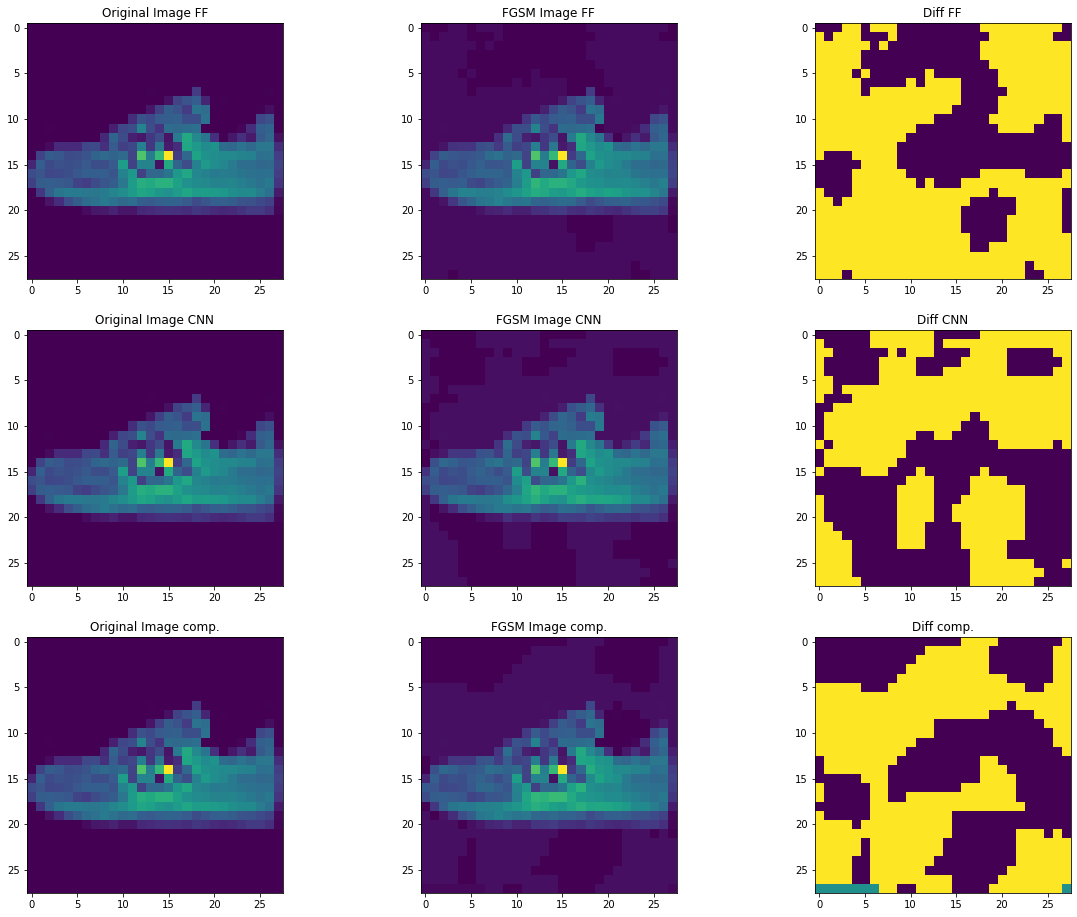

In [ ]:
#@title Visualize FGSM { form-width: "20%" }
fig = plt.figure()
print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(20,16))
print("Epsilon: " + str(delta))

ax[0][0].set_title("Original Image FF")
ax[0][0].imshow(mnist_x["dev"][idx])
ax[0][1].set_title("FGSM Image FF")
ax[0][1].imshow(mnist_x_fgsm_ff[idx])
ax[0][2].set_title("Diff FF")
ax[0][2].imshow(mnist_x_fgsm_ff[idx]-mnist_x["dev"][idx])

ax[1][0].set_title("Original Image CNN")
ax[1][0].imshow(mnist_x["dev"][idx])
ax[1][1].set_title("FGSM Image CNN")
ax[1][1].imshow(mnist_x_fgsm_cnn[idx])
ax[1][2].set_title("Diff CNN")
ax[1][2].imshow(mnist_x_fgsm_cnn[idx]-mnist_x["dev"][idx])

ax[2][0].set_title("Original Image comp.")
ax[2][0].imshow(mnist_x["dev"][idx])
ax[2][1].set_title("FGSM Image comp.")
ax[2][1].imshow(mnist_x_fgsm_comp[idx])
ax[2][2].set_title("Diff comp.")
ax[2][2].imshow(mnist_x_fgsm_comp[idx]-mnist_x["dev"][idx])

mnist_ff_fgsm_set = ImageDataset(mnist_x_fgsm_ff,mnist_y["dev"])
mnist_ff_fgsm_devloader = DataLoader(mnist_ff_fgsm_set,50,shuffle=True)

mnist_cnn_fgsm_set = ImageDataset(mnist_x_fgsm_cnn,mnist_y["dev"])
mnist_cnn_fgsm_devloader = DataLoader(mnist_cnn_fgsm_set,50,shuffle=True)

mnist_comp_fgsm_set = ImageDataset(mnist_x_fgsm_comp,mnist_y["dev"])
mnist_comp_fgsm_devloader = DataLoader(mnist_comp_fgsm_set,50,shuffle=True)


sneaker: 7
Epsilon: 0.2


<Figure size 432x288 with 0 Axes>

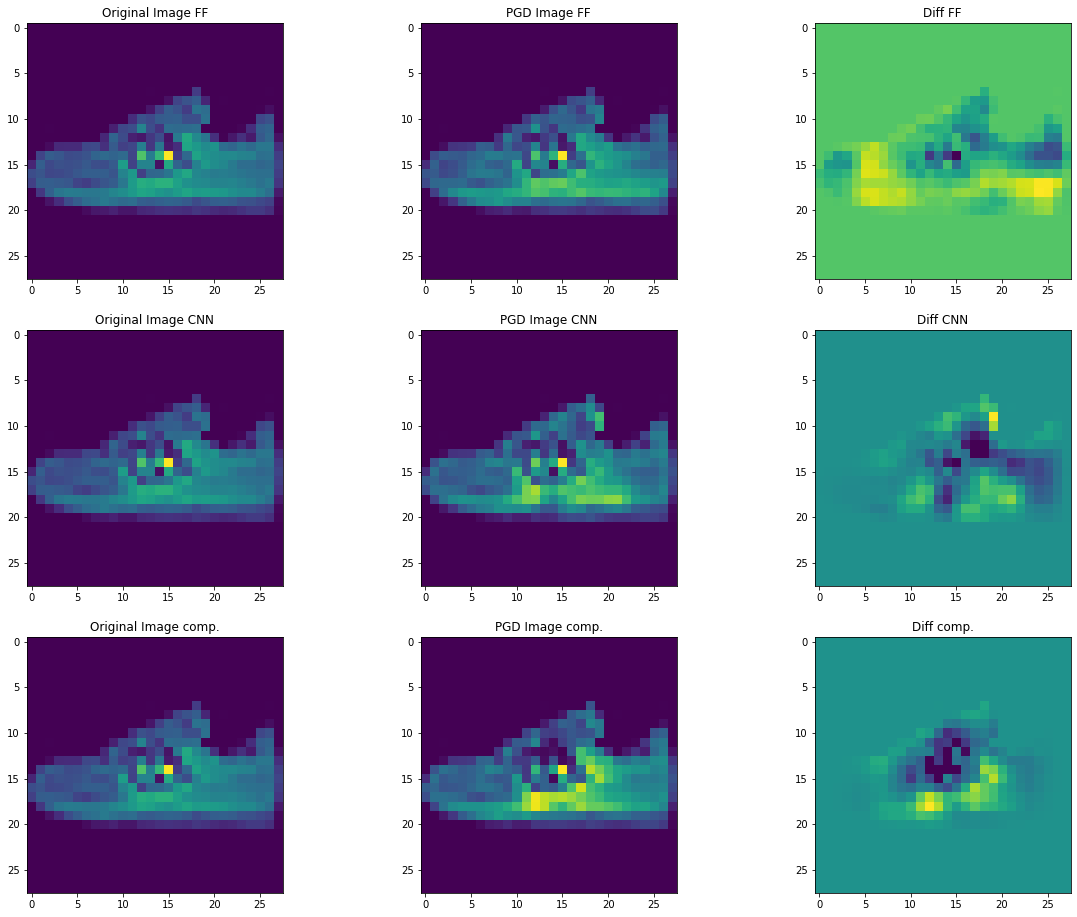

In [ ]:
#@title Visualize PGD { form-width: "20%" }
fig = plt.figure()
print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(20,16))
print("Epsilon: " + str(delta))

ax[0][0].set_title("Original Image FF")
ax[0][0].imshow(mnist_x["dev"][idx])
ax[0][1].set_title("PGD Image FF")
ax[0][1].imshow(mnist_x_pgd_ff[idx])
ax[0][2].set_title("Diff FF")
ax[0][2].imshow(mnist_x_pgd_ff[idx]-mnist_x["dev"][idx])

ax[1][0].set_title("Original Image CNN")
ax[1][0].imshow(mnist_x["dev"][idx])
ax[1][1].set_title("PGD Image CNN")
ax[1][1].imshow(mnist_x_pgd_cnn[idx])
ax[1][2].set_title("Diff CNN")
ax[1][2].imshow(mnist_x_pgd_cnn[idx]-mnist_x["dev"][idx])

ax[2][0].set_title("Original Image comp.")
ax[2][0].imshow(mnist_x["dev"][idx])
ax[2][1].set_title("PGD Image comp.")
ax[2][1].imshow(mnist_x_pgd_comp[idx])
ax[2][2].set_title("Diff comp.")
ax[2][2].imshow(mnist_x_pgd_comp[idx]-mnist_x["dev"][idx])

mnist_ff_pgd_set = ImageDataset(mnist_x_pgd_ff,mnist_y["dev"])
mnist_ff_pgd_devloader = DataLoader(mnist_ff_pgd_set,50,shuffle=True)

mnist_cnn_pgd_set = ImageDataset(mnist_x_pgd_cnn,mnist_y["dev"])
mnist_cnn_pgd_devloader = DataLoader(mnist_cnn_pgd_set,50,shuffle=True)

mnist_comp_pgd_set = ImageDataset(mnist_x_pgd_comp,mnist_y["dev"])
mnist_comp_pgd_devloader = DataLoader(mnist_comp_pgd_set,50,shuffle=True)


sneaker: 7
Epsilon: 0.2


<Figure size 432x288 with 0 Axes>

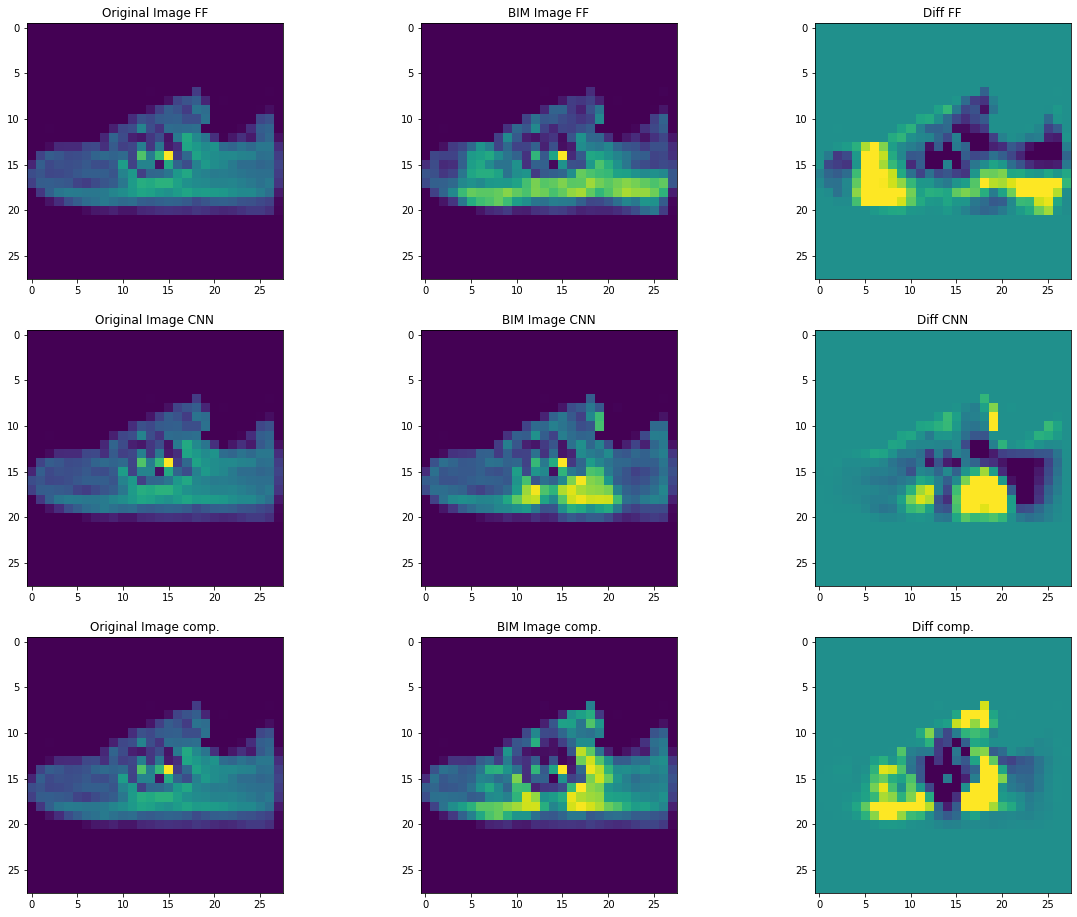

In [ ]:
#@title Visualize BIM { form-width: "20%" }
fig = plt.figure()
print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(20,16))
print("Epsilon: " + str(delta))

ax[0][0].set_title("Original Image FF")
ax[0][0].imshow(mnist_x["dev"][idx])
ax[0][1].set_title("BIM Image FF")
ax[0][1].imshow(mnist_x_bim_ff[idx])
ax[0][2].set_title("Diff FF")
ax[0][2].imshow(mnist_x_bim_ff[idx]-mnist_x["dev"][idx])

ax[1][0].set_title("Original Image CNN")
ax[1][0].imshow(mnist_x["dev"][idx])
ax[1][1].set_title("BIM Image CNN")
ax[1][1].imshow(mnist_x_bim_cnn[idx])
ax[1][2].set_title("Diff CNN")
ax[1][2].imshow(mnist_x_bim_cnn[idx]-mnist_x["dev"][idx])

ax[2][0].set_title("Original Image comp.")
ax[2][0].imshow(mnist_x["dev"][idx])
ax[2][1].set_title("BIM Image comp.")
ax[2][1].imshow(mnist_x_bim_comp[idx])
ax[2][2].set_title("Diff comp.")
ax[2][2].imshow(mnist_x_bim_comp[idx]-mnist_x["dev"][idx])

mnist_ff_bim_set = ImageDataset(mnist_x_bim_ff,mnist_y["dev"])
mnist_ff_bim_devloader = DataLoader(mnist_ff_bim_set,50,shuffle=True)

mnist_cnn_bim_set = ImageDataset(mnist_x_bim_cnn,mnist_y["dev"])
mnist_cnn_bim_devloader = DataLoader(mnist_cnn_bim_set,50,shuffle=True)

mnist_comp_bim_set = ImageDataset(mnist_x_bim_comp,mnist_y["dev"])
mnist_comp_bim_devloader = DataLoader(mnist_comp_bim_set,50,shuffle=True)


# Models and Evaluation

## Experimental Setup

An arbitrary 10% proportion of the training data was split off for development to provide a method for validation throughout the process while the test data itself was introduced only for attack and defense evaluation but never for training nor was anything tuned on the attack sets. 

The evaluation was measured on raw accuracy of the classifer-defender models on various attack sets. In application, particularily in safety critical applications, failure by the classifier on even a single adversarial example can have major ramifications. However, such stringent standards have yet to be achieved and for methodological development the accuracy of classifiers on various sets of attack images is commonly used to provide sufficient evaluation of the success of various defense strategies. 

First, the three baseline classifiers were attacked using image transforms, $\epsilon$ of 0.1 black-box methods, and finally $\epsilon$ of 0.2 white-box methods without any mitigation strategy in place to gauge a baseline for the strength of the attacks. Note the larger $\epsilon$ on white-box methods was deemed reasonable as white-box images are to a human observer much less obviously perturbed than black-box images. Then, the developed Simple Plug-in Image Ensemble Defender (SPIE-D) is applied to the classifiers to gauge if the drop from baseline accuracy decreased. Two other defense strategies, RAIN (A Simple Approach For Robust And Accurate Image Classification) [7] and PRB (Probably Robust Boosting) [8] were also attacked with the generated images to provide a comparison. 




## Baselines 

Generally well crafted adversarial examples can show drops in classifier accuracy near 100% of baseline, also refered to as near 100% adversarial success. However, these are typically on larger color images such as the CiFar10 or CiFar100 datasets or even on much large datasets such as Image Net which is high resolution and uses 20000 classes that can produce much more brittle features. Due to the reduced complexity and fewer number of classes present in Fashion-MNIST significantly lower adversarial success was expected from the attacks performed below. A summary of the drops in accuracy as a percentage of baseline can be seen below in ["Undefended Results"](#scrollTo=_e0m9xTAeHya).


In [ ]:
#@title Various Transforms { form-width: "20%" }

print(f'FF test accuracy: {test(mnist_ff,transform_attack_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,transform_attack_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,transform_attack_testloader)[0]}')

FF test accuracy: 0.5247142857142857
CNN test accuracy: 0.3387142857142857
Composite test accuracy: 0.5611428571428572


In [ ]:
#@title RP Attack, epsilon of 0.1 { form-width: "20%" }

print(f'FF test accuracy: {test(mnist_ff,mnist_rp_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_rp_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_rp_testloader)[0]}')

FF test accuracy: 0.7885
CNN test accuracy: 0.4325
Composite test accuracy: 0.735


In [ ]:
#@title RP Attack, epsilon of 0.1 { form-width: "20%" }

print(f'FF test accuracy: {test(mnist_ff,mnist_rp_3_devloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_rp_3_devloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_rp_3_devloader)[0]}')

FF test accuracy: 0.08833333333333333
CNN test accuracy: 0.08416666666666667
Composite test accuracy: 0.08666666666666667


In [ ]:
#@title SimBA Attack { form-width: "20%" }

print(f'FF test accuracy: {test(mnist_ff,mnist_ff_simba_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_simba_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_simba_testloader)[0]}')

FF test accuracy: 0.5855
CNN test accuracy: 0.294
Composite test accuracy: 0.6625


In [ ]:
#@title Combined Random Attack { form-width: "20%" }

x_temp = [mnist_x_rp,
          mnist_x_simba_ff,mnist_x_simba_cnn,mnist_x_simba_comp]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["dev"],
          mnist_y["dev"],mnist_y["dev"],mnist_y["dev"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["dev"],
           mnist_x["dev"],mnist_x["dev"],mnist_x["dev"]]
im_temp = np.vstack(im_temp)

rand_attack_x_devraw = x_temp
rand_attack_im_devraw = im_temp
rand_attack_y_devraw = y_temp

rand_attack_devset = ImageDataset(x_temp,y_temp)
rand_attack_devloader = DataLoader(rand_attack_devset,50,shuffle=True)

rand_attack_im_devset = ImageDataset(x_temp,im_temp)
rand_attack_im_devloader = DataLoader(rand_attack_im_devset,50,shuffle=True)


x_temp = [train_mnist_x_rp,
          train_mnist_x_simba_ff,train_mnist_x_simba_cnn,train_mnist_x_simba_comp]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["train"],
          mnist_y["train"],mnist_y["train"],mnist_y["train"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["train"],
           mnist_x["train"],mnist_x["train"],mnist_x["train"]]
im_temp = np.vstack(im_temp)

rand_attack_x_train_raw = x_temp
rand_attack_im_train_raw = im_temp
rand_attack_y_train_raw = y_temp

#print(rand_attack_x_train_raw.shape)
#print(rand_attack_y_train_raw.shape)

rand_attack_trainset = ImageDataset(x_temp,y_temp)
rand_attack_trainloader = DataLoader(rand_attack_trainset,50,shuffle=True)

rand_attack_im_trainset = ImageDataset(x_temp,im_temp)
rand_attack_im_trainloader = DataLoader(rand_attack_im_trainset,50,shuffle=True)

x_temp = [test_mnist_x_rp,
          test_mnist_x_simba_ff,test_mnist_x_simba_cnn,test_mnist_x_simba_comp]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["test"],
          mnist_y["test"],mnist_y["test"],mnist_y["test"]]
y_temp = np.hstack(y_temp)

rand_attack_x_test_raw = x_temp
rand_attack_im_test_raw = im_temp
rand_attack_y_test_raw = y_temp

rand_attack_testset = ImageDataset(x_temp,y_temp)
rand_attack_testloader = DataLoader(rand_attack_testset,50,shuffle=True)

rand_attack_im_testset = ImageDataset(x_temp,im_temp)
rand_attack_im_testloader = DataLoader(rand_attack_im_testset,50,shuffle=True)

print(f'Baselines - FF: {baseline_ff}, CNN: {baseline_cnn}, Comp.: {baseline_comp}')
print(f'FF test accuracy: {test(mnist_ff,rand_attack_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,rand_attack_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,rand_attack_testloader)[0]}')

Baselines - FF: 0.797, CNN: 0.4485, Comp.: 0.7465
FF test accuracy: 0.716
CNN test accuracy: 0.39175
Composite test accuracy: 0.69475


In [ ]:
#@title FGSM Attack { form-width: "20%" }

print(f'FF test accuracy: {test(mnist_ff,mnist_ff_fgsm_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_fgsm_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_fgsm_testloader)[0]}')

FF test accuracy: 0.702
CNN test accuracy: 0.3595
Composite test accuracy: 0.712


In [ ]:
#@title PGD Attack { form-width: "20%" }

print(f'FF test accuracy: {test(mnist_ff,mnist_ff_pgd_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_pgd_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_pgd_testloader)[0]}')

FF test accuracy: 0.5995
CNN test accuracy: 0.2235
Composite test accuracy: 0.5235


In [ ]:
#@title BIM Attack { form-width: "20%" }

print(f'FF test accuracy: {test(mnist_ff,mnist_ff_bim_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_bim_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_bim_testloader)[0]}')

FF test accuracy: 0.298
CNN test accuracy: 0.157
Composite test accuracy: 0.4095


In [ ]:
#@title Combined Gradient Attack { form-width: "20%" }

x_temp = [mnist_x_fgsm_ff,mnist_x_fgsm_cnn,mnist_x_fgsm_comp,
          mnist_x_pgd_ff,mnist_x_pgd_cnn,mnist_x_pgd_comp,
          mnist_x_bim_ff,mnist_x_bim_cnn,mnist_x_bim_comp]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["dev"],mnist_y["dev"],mnist_y["dev"],
          mnist_y["dev"],mnist_y["dev"],mnist_y["dev"],
          mnist_y["dev"],mnist_y["dev"],mnist_y["dev"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["dev"],mnist_x["dev"],mnist_x["dev"],
           mnist_x["dev"],mnist_x["dev"],mnist_x["dev"],
           mnist_x["dev"],mnist_x["dev"],mnist_x["dev"]]
im_temp = np.vstack(im_temp)

grad_attack_x_devraw = x_temp
grad_attack_im_devraw = im_temp
grad_attack_y_devraw = y_temp

grad_attack_devset = ImageDataset(x_temp,y_temp)
grad_attack_devloader = DataLoader(grad_attack_devset,50,shuffle=True)

grad_attack_im_devset = ImageDataset(x_temp,im_temp)
grad_attack_im_devloader = DataLoader(grad_attack_im_devset,50,shuffle=True)

x_temp = [train_mnist_x_fgsm_ff,train_mnist_x_fgsm_cnn,train_mnist_x_fgsm_comp,
          train_mnist_x_pgd_ff,train_mnist_x_pgd_cnn,train_mnist_x_pgd_comp,
          train_mnist_x_bim_ff,train_mnist_x_bim_cnn,train_mnist_x_bim_comp]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["train"],mnist_y["train"],mnist_y["train"],
          mnist_y["train"],mnist_y["train"],mnist_y["train"],
          mnist_y["train"],mnist_y["train"],mnist_y["train"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["train"],mnist_x["train"],mnist_x["train"],
           mnist_x["train"],mnist_x["train"],mnist_x["train"],
           mnist_x["train"],mnist_x["train"],mnist_x["train"]]
im_temp = np.vstack(im_temp)

grad_attack_x_train_raw = x_temp
grad_attack_im_train_raw = im_temp
grad_attack_y_train_raw = y_temp

#print(grad_attack_x_train_raw.shape)
#print(grad_attack_y_train_raw.shape)

grad_attack_trainset = ImageDataset(x_temp,y_temp)
grad_attack_trainloader = DataLoader(grad_attack_trainset,50,shuffle=True)

grad_attack_im_trainset = ImageDataset(x_temp,im_temp)
grad_attack_im_trainloader = DataLoader(grad_attack_im_trainset,50,shuffle=True)

x_temp = [test_mnist_x_fgsm_ff,test_mnist_x_fgsm_cnn,test_mnist_x_fgsm_comp,
          test_mnist_x_pgd_ff,test_mnist_x_pgd_cnn,test_mnist_x_pgd_comp,
          test_mnist_x_bim_ff,test_mnist_x_bim_cnn,test_mnist_x_bim_comp]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["test"],mnist_y["test"],mnist_y["test"],
          mnist_y["test"],mnist_y["test"],mnist_y["test"],
          mnist_y["test"],mnist_y["test"],mnist_y["test"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["test"],mnist_x["test"],mnist_x["test"],
           mnist_x["test"],mnist_x["test"],mnist_x["test"],
           mnist_x["test"],mnist_x["test"],mnist_x["test"]]
im_temp = np.vstack(im_temp)

grad_attack_x_test_raw = x_temp
grad_attack_im_test_raw = im_temp
grad_attack_y_test_raw = y_temp

#print(grad_attack_x_test_raw.shape)
#print(grad_attack_y_test_raw.shape)

grad_attack_testset = ImageDataset(x_temp,y_temp)
grad_attack_testloader = DataLoader(grad_attack_testset,50,shuffle=True)

grad_attack_im_testset = ImageDataset(x_temp,im_temp)
grad_attack_im_testloader = DataLoader(grad_attack_im_testset,50,shuffle=True)


print(f'Baselines - FF: {baseline_ff}, CNN: {baseline_cnn}, Comp.: {baseline_comp}')
print(f'FF test accuracy: {test(mnist_ff,grad_attack_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,grad_attack_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,grad_attack_testloader)[0]}')

Baselines - FF: 0.797, CNN: 0.4485, Comp.: 0.7465
FF test accuracy: 0.6636666666666666
CNN test accuracy: 0.35788888888888887
Composite test accuracy: 0.6168333333333333


## Methods

When conidering the design of SPIE-D several factors informed the concept. The first goal is to avoid retraining the baseline classifier. This allows for a more clear evaluation metric as the behavior of the baseline classifier does not change and somewhat dis-entangles the challenges of adverarial robustness and development of better baseline classifiers. Several presented defense strategies follow this approach such as *PixelDefend* [9] which focus on using an additional detector-denoiser model in addition to the baseline classifier which can help maintain classification accuracy on clean data by avoiding denoising non-adversarial images. 

Data pre-processing models such as RAIN also hold this advantage. However, pre-processing frameworks must be careful that the images are changed in a way that avoids domain shift and allows the supported classifier to maintain baseline performance. In RAIN's published implementation for Image Net this is largely the case as underlying CNN based architectures are invariant to the random shifting done by the RAIN framework and a well trained super-resolution framework using the Enhanced Deep Residual Networks for Super Resolution [10] is in place. However, this project's implementation of RAIN suffered from difficulties with the natively small image sizes and showed significant drops in baseline accuracies.

We have also looked into other papers on chaning architecture to achieve robust models, such as Provably Robust Boosting [citation], due to the fact that the Github Repository was not well maintained for PixelDefend. This model uses an
ensemble of trees and leverages adervsarial training to obtain its robustness.
When trained on just the regular FMNIST test set, it acheives an accuracy of 
86.35%. Further results on adversarial attacks will be provided later in the
report.


## Adversary Detector 

Beginning with adversary detection a convolutional nueral network is trained using Binary Cross Entropy Loss, stochastic gradient descent, and the Adam learning rate scheduler. The goal of the adversary detector was to classify input images into four classes: images affected by random perturbation, images affected by gradient based attacks, blurred images, and all other images. Note that this last category includes both unattacked images as well as images affected by all other image transform attacks. Hyperparameter tuning was done to optimize the adversary detector's recall scores. Recall was chosen as the primary evaluation metric because there is a high cost associated with misclassification since misclassified images will be sent to the incorrect denoiser later in the pipeline. 

**PCA Adversary Detector:**
First however, a more common way that adversarial detection is done is by using Principle Component Analysis (PCA), and thus this approach was also explored. The premise behind using PCA as an adversary detector was based on Hendrycks & Gimpel, ICLR 2017, [11] where it was shown adversary examples placed larger weights (i.e. higher variance) on larger principal components compared to normal images. Thus, by analyzing the weights on the larger principal components, we can detect if an image is an adversarial image or a natural image. Compared to other methods of adversary detection, such as training another network to detect normal vs adversary examples, PCA offers a relatively simple and efficient way to detect adversaries as Python packages, such as sklearn, often have implementations of PCA. Furthermore, due to the vulnerability of neural networks to adversarial attacks, it is desirable to create a method to detect adversarial examples that is independent of network architectures.  


### PCA Adversarial Detector

Methods: To evaluate the efficacy in using PCA to detect adversarial examples, we flattened our images from (28x28) to (784x1) and performed PCA to obtain the principal components. To determine the weights on each principal component, we calculated the component scores $S(1), ..., S(784)$ for each image, $X_i$, using the following method: $$ S(j) = \frac{1}{N} \sum_{i=1}^N |PCA(X_i)_j|$$, where $PCA(X_i)_j$ is the principal component score for the $j$th principal component and $N$ is the total number of images. Next, component scores for each adversarial image was also calculated using the principal components obtained above. Lastly, to test the ability of PCA to differentiate between adversarial images and natural images, we compared the components scores. Images were classified as an adversary example if the average of the last 50 component scores differed from that of the training set by a 0.008. The threshold value was determined via a gridsearch, where the accuracy of the method in detecting adversarial images was compared to its accuracy in recognizing natural images at each threshold value. If the threshold value was too small, then the method would be biased towards classifying images as adversarial images. If the threshold value was too large, then the method would be biased towards classifying images as natural. 

In [ ]:
#@title PCA Detector Function { form-width: "10%" }


import sklearn.decomposition 

def pca_adv_detector(x_train, input, threshold): 
  train_reshaped = np.reshape(x_train, (-1, 28*28))
  input_reshaped = np.reshape(input, (-1, 28*28))
  pca = sklearn.decomposition.PCA()
  pca.fit(train_reshaped)
  pca.fit(train_reshaped)

  pca_score_train = pca.transform(train_reshaped)
  pca_score_input = pca.transform(input_reshaped)
  #print(pca_score_train.shape)
  #print(pca_score_input.shape)

  avg_score_train = np.mean(np.abs(pca_score_train), axis = 0)
  #print(avg_score_train.shape)
  score_input = np.abs(pca_score_input)
  #print(score_input.shape)
  adv_tag = threshold_detect(avg_score_train, score_input, 0.008)
  return adv_tag

def threshold_detect(train_score, input_score, thresh):
  train_score_high_pc = train_score[-51:-1].reshape((1, 50))
  #print(train_score_high_pc.shape)
  input_score_high_pc = input_score[:, -51:-1]
  #print(input_score_high_pc.shape)
  diff = np.mean(input_score_high_pc - train_score_high_pc, axis=1)
  tag = (diff > thresh).astype(int)
  return tag



In [ ]:
#@title Testing Adversarial Detector (Example of using threshold value that is too large) { form-width: "10%" }

x_train = mnist_x["train"]
print('Example of using a threshold value that is too large')
print(f'Accuracy on detecting dev set examples: {1- np.mean(pca_adv_detector(x_train, mnist_x["dev"], 0.05))}')

print(f'Accuracy on detecting simba (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_simba_ff, 0.05))}')
print(f'Accuracy on detecting simba (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_simba_cnn, 0.05))}')
print(f'Accuracy on detecting simba (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_simba_comp, 0.05))}')

print(f'Accuracy on detecting random perturbation adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_rp, 0.05))}')

print(f'Accuracy on detecting pgd (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_pgd_ff, 0.05))}')
print(f'Accuracy on detecting pgd (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_pgd_cnn, 0.05))}')
print(f'Accuracy on detecting pgd (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_pgd_comp, 0.05))}')

print(f'Accuracy on detecting fgsm (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_fgsm_ff, 0.05))}')
print(f'Accuracy on detecting fgsm (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_fgsm_cnn, 0.05))}')
print(f'Accuracy on detecting fgsm (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_fgsm_comp, 0.05))}')

print(f'Accuracy on detecting bim (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_bim_ff, 0.05))}')
print(f'Accuracy on detecting bim (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_bim_cnn, 0.05))}')
print(f'Accuracy on detecting bim (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_bim_comp, 0.05))}')

Example of using a threshold value that is too large
Accuracy on detecting dev set examples: 0.9033333333333333
Accuracy on detecting simba (ff) adversarial examples: 0.9433333333333334
Accuracy on detecting simba (cnn) adversarial examples: 0.805
Accuracy on detecting simba (comp) adversarial examples: 0.8741666666666666
Accuracy on detecting random perturbation adversarial examples: 1.0
Accuracy on detecting pgd (ff) adversarial examples: 0.08833333333333333
Accuracy on detecting pgd (cnn) adversarial examples: 0.09583333333333334
Accuracy on detecting pgd (comp) adversarial examples: 0.09583333333333334
Accuracy on detecting fgsm (ff) adversarial examples: 0.17333333333333334
Accuracy on detecting fgsm (cnn) adversarial examples: 0.2725
Accuracy on detecting fgsm (comp) adversarial examples: 0.27166666666666667
Accuracy on detecting bim (ff) adversarial examples: 0.09
Accuracy on detecting bim (cnn) adversarial examples: 0.09916666666666667
Accuracy on detecting bim (comp) adversari

As shown above, choosing a threshold value that is too large results in low accuracy in detecting adversarial images but high accuracy in detecting natural images (dev set images). 

In [ ]:
#@title Testing Adversarial Detector (Example of using threshold value that is too small) { form-width: "10%" }

x_train = mnist_x["train"]
print('Example of using a threshold value that is too small')
print(f'Accuracy on detecting dev set examples: {1- np.mean(pca_adv_detector(x_train, mnist_x["dev"], 0.00000001))}')

print(f'Accuracy on detecting simba (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_simba_ff, 0.00000001))}')
print(f'Accuracy on detecting simba (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_simba_cnn, 0.00000001))}')
print(f'Accuracy on detecting simba (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_simba_comp, 0.00000001))}')

print(f'Accuracy on detecting random perturbation adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_rp, 0.00000001))}')

print(f'Accuracy on detecting pgd (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_pgd_ff, 0.00000001))}')
print(f'Accuracy on detecting pgd (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_pgd_cnn, 0.00000001))}')
print(f'Accuracy on detecting pgd (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_pgd_comp, 0.00000001))}')

print(f'Accuracy on detecting fgsm (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_fgsm_ff, 0.00000001))}')
print(f'Accuracy on detecting fgsm (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_fgsm_cnn, 0.00000001))}')
print(f'Accuracy on detecting fgsm (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_fgsm_comp, 0.00000001))}')

print(f'Accuracy on detecting bim (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_bim_ff, 0.00000001))}')
print(f'Accuracy on detecting bim (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_bim_cnn, 0.00000001))}')
print(f'Accuracy on detecting bim (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_bim_comp, 0.00000001))}')

Example of using a threshold value that is too small
Accuracy on detecting dev set examples: 0.9033333333333333
Accuracy on detecting simba (ff) adversarial examples: 0.9433333333333334
Accuracy on detecting simba (cnn) adversarial examples: 0.805
Accuracy on detecting simba (comp) adversarial examples: 0.8741666666666666
Accuracy on detecting random perturbation adversarial examples: 1.0
Accuracy on detecting pgd (ff) adversarial examples: 0.08833333333333333
Accuracy on detecting pgd (cnn) adversarial examples: 0.09583333333333334
Accuracy on detecting pgd (comp) adversarial examples: 0.09583333333333334
Accuracy on detecting fgsm (ff) adversarial examples: 0.17333333333333334
Accuracy on detecting fgsm (cnn) adversarial examples: 0.2725
Accuracy on detecting fgsm (comp) adversarial examples: 0.27166666666666667
Accuracy on detecting bim (ff) adversarial examples: 0.09
Accuracy on detecting bim (cnn) adversarial examples: 0.09916666666666667
Accuracy on detecting bim (comp) adversari

As shown above, using a threshold value that is too small leads to increased accuracy in detecting adversarial examples but lower accuracy in detecting natural images. In particular, the method is able to detect black box attacks with 98.25% accuracy. While the accuracy in detecting white box attacks has increased, the accuracy in detecting pgd and bim generated attacks is still low. In part, this is due to the fact that these white-box attacks (in particular pgd and bim) are better at creating adversarial images that look similar to the training images. Below, we show the averaged component scores of the training set, dev set, and each of the adversary classes. In general, we found that the white-box attacks had similar scores compared to the training and dev set, while the black-box attacks did not, which explains the poor performance of the PCA method in detecting against white-box attacks. 

Text(0.5, 1.0, 'Component Scores of FGSM Attack')

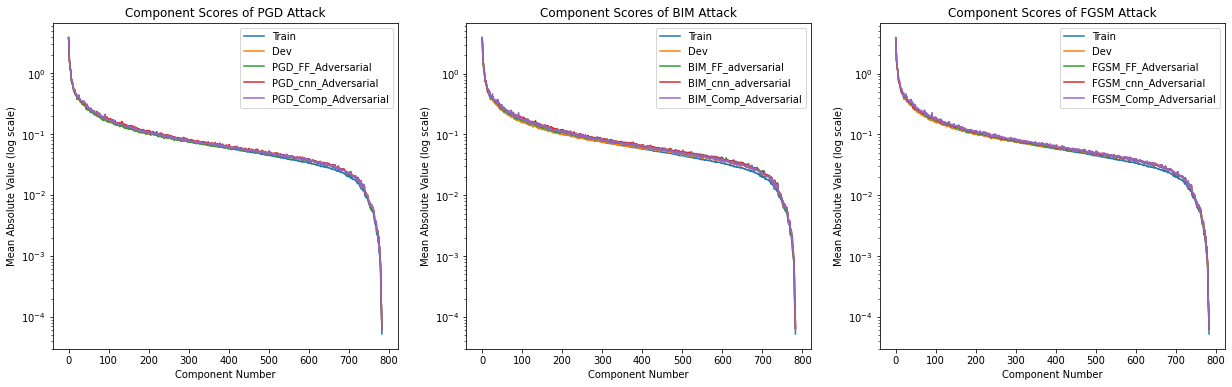

In [ ]:
#@title Component Scores of White Box Attack Images Compared to Training and Dev Set 
mnist_train_reshaped = np.reshape(mnist_x["train"], (-1, 28*28))
#print(pca_input.shape)

#print(mnist_train_reshaped.shape)
pca = sklearn.decomposition.PCA()
pca.fit(mnist_train_reshaped)
score_train = pca.transform(np.reshape(mnist_x["train"], (-1, 28*28)))
#print(score_train.shape)
score_dev = pca.transform(np.reshape(mnist_x["dev"], (-1, 28*28)))

PGD_FF_adv = pca.transform(mnist_x_pgd_ff.reshape(-1, 28*28))
#print(mnist_x_pgd_cnn.shape)
PGD_cnn_adv = pca.transform(mnist_x_pgd_cnn.reshape(-1, 28*28))
PGD_comp_adv = pca.transform(mnist_x_pgd_comp.reshape(-1, 28*28))
BIM_FF_adv = pca.transform(mnist_x_bim_ff.reshape(-1, 28*28))
BIM_cnn_adv = pca.transform(mnist_x_bim_cnn.reshape(-1, 28*28))
BIM_comp_adv = pca.transform(mnist_x_bim_comp.reshape(-1, 28*28))
FGSM_FF_adv = pca.transform(mnist_x_fgsm_ff.reshape(-1, 28*28))
FGSM_cnn_adv = pca.transform(mnist_x_fgsm_cnn.reshape(-1, 28*28))
FGSM_comp_adv = pca.transform(mnist_x_fgsm_comp.reshape(-1, 28*28))


fig = plt.figure(figsize=(21,6))
plt.xlabel('Component Number')
plt.ylabel('Mean Absolute Value (log scale)')
plt.subplot(1,3,1)
plt.title('Component Scores of PGD Attack')
plt.semilogy(range(score_train.shape[1]),np.mean(np.abs(score_train),axis=0),label='Train')
plt.semilogy(range(score_dev.shape[1]),np.mean(np.abs(score_dev),axis=0),label='Dev')
plt.semilogy(range(PGD_FF_adv.shape[1]),np.mean(np.abs(PGD_FF_adv),axis=0), label='PGD_FF_Adversarial')
plt.semilogy(range(PGD_cnn_adv.shape[1]),np.mean(np.abs(PGD_cnn_adv),axis=0), label='PGD_cnn_Adversarial')
plt.semilogy(range(PGD_comp_adv.shape[1]),np.mean(np.abs(PGD_comp_adv),axis=0), label='PGD_Comp_Adversarial')
plt.legend()
plt.xlabel('Component Number')
plt.ylabel('Mean Absolute Value (log scale)')
plt.subplot(1,3,2)
plt.title('Component Scores of BIM Attack')
plt.semilogy(range(score_train.shape[1]),np.mean(np.abs(score_train),axis=0),label='Train')
plt.semilogy(range(score_dev.shape[1]),np.mean(np.abs(score_dev),axis=0),label='Dev')
plt.semilogy(range(BIM_FF_adv.shape[1]),np.mean(np.abs(BIM_FF_adv),axis=0), label='BIM_FF_adversarial')
plt.semilogy(range(BIM_cnn_adv.shape[1]),np.mean(np.abs(BIM_cnn_adv),axis=0), label='BIM_cnn_adversarial')
plt.semilogy(range(BIM_comp_adv.shape[1]),np.mean(np.abs(BIM_comp_adv),axis=0), label='BIM_Comp_Adversarial')
plt.legend()
plt.xlabel('Component Number')
plt.ylabel('Mean Absolute Value (log scale)')
plt.subplot(1,3,3)
plt.semilogy(range(score_train.shape[1]),np.mean(np.abs(score_train),axis=0),label='Train')
plt.semilogy(range(score_dev.shape[1]),np.mean(np.abs(score_dev),axis=0),label='Dev')
plt.semilogy(range(FGSM_FF_adv.shape[1]),np.mean(np.abs(PGD_comp_adv),axis=0), label='FGSM_FF_Adversarial')
plt.semilogy(range(FGSM_cnn_adv.shape[1]),np.mean(np.abs(PGD_cnn_adv),axis=0), label='FGSM_cnn_Adversarial')
plt.semilogy(range(FGSM_comp_adv.shape[1]),np.mean(np.abs(BIM_comp_adv),axis=0), label='FGSM_Comp_Adversarial')
plt.legend()
plt.xlabel('Component Number')
plt.ylabel('Mean Absolute Value (log scale)')
plt.title('Component Scores of FGSM Attack')


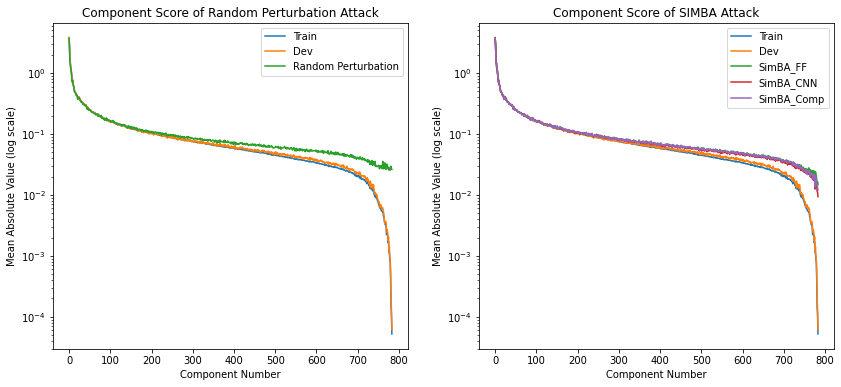

In [ ]:
#@title Component Scores of Black Box Attack Images Compared to Training and Dev Set
RP_adv = pca.transform(mnist_x_rp.reshape(-1, 28*28))
SimBA_FF_adv = pca.transform(mnist_x_simba_ff.reshape(-1, 28*28))
SimBA_CNN_adv = pca.transform(mnist_x_simba_cnn.reshape(-1, 28*28))
SimBA_comp_adv = pca.transform(mnist_x_simba_comp.reshape(-1, 28*28))

fig = plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.xlabel('Component Number')
plt.ylabel('Mean Absolute Value (log scale)')
plt.semilogy(range(score_train.shape[1]),np.mean(np.abs(score_train),axis=0),label='Train')
plt.semilogy(range(score_dev.shape[1]),np.mean(np.abs(score_dev),axis=0),label='Dev')
plt.semilogy(range(RP_adv.shape[1]),np.mean(np.abs(RP_adv),axis=0), label='Random Perturbation')
plt.title('Component Score of Random Perturbation Attack')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Component Number')
plt.ylabel('Mean Absolute Value (log scale)')
plt.title('Component Score of SIMBA Attack')
plt.semilogy(range(score_train.shape[1]),np.mean(np.abs(score_train),axis=0),label='Train')
plt.semilogy(range(score_dev.shape[1]),np.mean(np.abs(score_dev),axis=0),label='Dev')
plt.semilogy(range(SimBA_FF_adv.shape[1]),np.mean(np.abs(SimBA_FF_adv),axis=0), label='SimBA_FF')
plt.semilogy(range(SimBA_CNN_adv.shape[1]),np.mean(np.abs(SimBA_CNN_adv),axis=0), label='SimBA_CNN')
plt.semilogy(range(SimBA_comp_adv.shape[1]),np.mean(np.abs(SimBA_comp_adv),axis=0), label='SimBA_Comp')
plt.legend()

In [ ]:
#@title Testing Adversarial Detector (Using Optimal Threshold) { form-width: "10%" }

x_train = mnist_x["train"]
print('Using Optimal Threshold')
print(f'Accuracy on detecting dev set examples: {1- np.mean(pca_adv_detector(x_train, mnist_x["dev"], 0.008))}')

print(f'Accuracy on detecting simba (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_simba_ff, 0.008))}')
print(f'Accuracy on detecting simba (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_simba_cnn, 0.008))}')
print(f'Accuracy on detecting simba (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_simba_comp, 0.008))}')

print(f'Accuracy on detecting random perturbation adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_rp, 0.008))}')

print(f'Accuracy on detecting pgd (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_pgd_ff, 0.008))}')
print(f'Accuracy on detecting pgd (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_pgd_cnn, 0.008))}')
print(f'Accuracy on detecting pgd (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_pgd_comp, 0.008))}')

print(f'Accuracy on detecting fgsm (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_fgsm_ff, 0.008))}')
print(f'Accuracy on detecting fgsm (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_fgsm_cnn, 0.008))}')
print(f'Accuracy on detecting fgsm (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_fgsm_comp, 0.008))}')

print(f'Accuracy on detecting bim (ff) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_bim_ff, 0.008))}')
print(f'Accuracy on detecting bim (cnn) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_bim_cnn, 0.008))}')
print(f'Accuracy on detecting bim (comp) adversarial examples: {np.mean(pca_adv_detector(x_train, mnist_x_bim_comp, 0.008))}')

Using Optimal Threshold
Accuracy on detecting dev set examples: 0.9033333333333333
Accuracy on detecting simba (ff) adversarial examples: 0.9433333333333334
Accuracy on detecting simba (cnn) adversarial examples: 0.805
Accuracy on detecting simba (comp) adversarial examples: 0.8741666666666666
Accuracy on detecting random perturbation adversarial examples: 1.0
Accuracy on detecting pgd (ff) adversarial examples: 0.08833333333333333
Accuracy on detecting pgd (cnn) adversarial examples: 0.09583333333333334
Accuracy on detecting pgd (comp) adversarial examples: 0.09583333333333334
Accuracy on detecting fgsm (ff) adversarial examples: 0.17333333333333334
Accuracy on detecting fgsm (cnn) adversarial examples: 0.2725
Accuracy on detecting fgsm (comp) adversarial examples: 0.27166666666666667
Accuracy on detecting bim (ff) adversarial examples: 0.09
Accuracy on detecting bim (cnn) adversarial examples: 0.09916666666666667
Accuracy on detecting bim (comp) adversarial examples: 0.09333333333333

With the optimal threshold value, the method is able to detect both black-box adversarial images and also natural images (dev set) with high accuracy. However, it is still unable to recognize adversarial images generated via white box attacks, which is a limitation of the method. Furthermore, another limiation of the PCA detector is that it is unable to differentiate whether a particular adversarial image was generated via black box or white box attack methods. This is undesirable for our particular defense strategy of creating a denoiser for every class of adversarial attacks, because the PCA detector would not be able to differentiate between the different types. Therefore, for our own pipeline, we decided to use a different approach to detect adversaries. 

### SPIE-D's Adversary Detector 

Nueral-Network Based

In [ ]:
#@title Form the Adversary Class set { form-width: "20%" }
# Copy, shuffle, and sample

def cosham(x,y,target,frac_size,dest_x,dest_y):
  size = frac_size * (x.shape)[0]
  size = int(np.floor(size))
  temp = np.copy(x)
  rn.shuffle(temp)
  dest_x = np.append(dest_x,temp[0:size],axis=0)
  temp_y = target * np.ones_like(y)
  dest_y = np.append(dest_y,temp_y[0:size],axis=0)
  return dest_x, dest_y

# Clean Dev data
temp_x = mnist_x["dev"]
temp_y = np.zeros_like(mnist_y["dev"])

# Random Rotates
temp_x, temp_y = cosham(x=x_rotated,y=y_rotated,target=0,
                        frac_size=1,dest_x=temp_x,dest_y=temp_y)
# Random Shifts
temp_x, temp_y = cosham(x=x_shifted,y=y_shifted,target=0,
                        frac_size=1,dest_x=temp_x,dest_y=temp_y)
# Random Crops
# temp_x, temp_y = cosham(x=x_cropped,y=y_cropped,target=0,
#                         frac_size=1,dest_x=temp_x,dest_y=temp_y)
# Random Scale
temp_x, temp_y = cosham(x=x_scaled,y=y_scaled,target=0,
                        frac_size=1,dest_x=temp_x,dest_y=temp_y)
# Random Affine
temp_x, temp_y = cosham(x=x_affine,y=y_affine,target=0,
                        frac_size=1,dest_x=temp_x,dest_y=temp_y)
# Random Brightness
temp_x, temp_y = cosham(x=x_brightness,y=y_brightness,target=0,
                        frac_size=1,dest_x=temp_x,dest_y=temp_y)
# Random Blur
temp_x, temp_y = cosham(x=x_blur,y=y_blur,target=0,
                        frac_size=1,dest_x=temp_x,dest_y=temp_y)

# Random Composite Transforms, both w & w/o blur
# temp_x, temp_y = cosham(x=x_composite,y=y_composite,target=0,
#                         frac_size=1/2,dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=x_composite_blur,y=y_composite_blur,target=0,
                        frac_size=1/2,dest_x=temp_x,dest_y=temp_y)

# Downsample non-adversarial examples to balance classes
down_ind = int(np.floor(0.15 * (temp_x.shape)[0]))
down_index_all = np.arange(down_ind)
rn.shuffle(down_index_all)
temp_x = temp_x[down_index_all]
temp_y = temp_y[down_index_all]

# Gradient Attacks
temp_x, temp_y = cosham(x=mnist_x_fgsm_ff,y=mnist_y["dev"],target=1,
                        frac_size=(1/9),dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_fgsm_cnn,y=mnist_y["dev"],target=1,
                        frac_size=(1/9),dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_fgsm_comp,y=mnist_y["dev"],target=1,
                        frac_size=(1/9),dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_pgd_ff,y=mnist_y["dev"],target=1,
                        frac_size=(1/9),dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_pgd_cnn,y=mnist_y["dev"],target=1,
                        frac_size=(1/9),dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_pgd_comp,y=mnist_y["dev"],target=1,
                        frac_size=(1/9),dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_bim_ff,y=mnist_y["dev"],target=1,
                        frac_size=(1/9),dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_bim_cnn,y=mnist_y["dev"],target=1,
                        frac_size=(1/9),dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_bim_comp,y=mnist_y["dev"],target=1,
                        frac_size=(1/9),dest_x=temp_x,dest_y=temp_y)
# Random Attacks
temp_x, temp_y = cosham(x=mnist_x_rp,y=mnist_y["dev"],target=2,
                        frac_size=1/2,dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_simba_ff,y=mnist_y["dev"],target=2,
                        frac_size=1/6,dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_simba_cnn,y=mnist_y["dev"],target=2,
                        frac_size=1/6,dest_x=temp_x,dest_y=temp_y)
temp_x, temp_y = cosham(x=mnist_x_simba_comp,y=mnist_y["dev"],target=2,
                        frac_size=1/6,dest_x=temp_x,dest_y=temp_y)

# Random Blur
temp_x, temp_y = cosham(x=x_blur,y=y_blur,target=3,
                        frac_size=1,dest_x=temp_x,dest_y=temp_y)

# Size dev_set here v
dev_ind = int(np.floor(0.2 * (temp_x.shape)[0]))
index_all = np.arange((temp_x.shape)[0])
rn.shuffle(index_all)
dev_temp_x = temp_x[index_all[0:dev_ind]]
dev_temp_y = temp_y[index_all[0:dev_ind]]
train_temp_x = temp_x[index_all[dev_ind:]]
train_temp_y = temp_y[index_all[dev_ind:]]

adversary_x_raw = temp_x
adversary_y_raw = temp_y

mnist_adversary_trainset = ImageDataset(train_temp_x,train_temp_y)
mnist_adversary_trainloader = DataLoader(mnist_adversary_trainset,50,shuffle=True)

mnist_adversary_devset = ImageDataset(dev_temp_x,dev_temp_y)
mnist_adversary_devloader = DataLoader(mnist_adversary_devset,50,shuffle=True)


In [ ]:
#@title Train detector net { form-width: "20%" }

class detector(torch.nn.Module):
  def __init__(self,up1,out_dim,chan1,chan2,chan3,chan4,chan5,k1,k2,k3,k4,k5,
               h6,h7,h8,p23,p34,color):
    super(detector,self).__init__()
    self.up0 = torch.nn.UpsamplingBilinear2d(scale_factor=up1)

    self.conv1 = torch.nn.Conv2d(color,chan1,kernel_size=k1)
    self.bn1 = torch.nn.BatchNorm2d(chan1)
    self.LR1 = torch.nn.LeakyReLU(0.1)

    self.conv2 = torch.nn.Conv2d(chan1,chan2,kernel_size=k2)
    self.bn2 = torch.nn.BatchNorm2d(chan2)
    self.LR2 = torch.nn.LeakyReLU(0.1)

    self.conv3 = torch.nn.Conv2d(chan2,chan3,kernel_size=k3)
    self.bn3 = torch.nn.BatchNorm2d(chan3)
    self.LR3 = torch.nn.LeakyReLU(0.1)

    self.conv4 = torch.nn.Conv2d(chan3,chan4,kernel_size=k4)
    self.bn4 = torch.nn.BatchNorm2d(chan4)
    self.LR4 = torch.nn.LeakyReLU(0.1)

    self.conv5 = torch.nn.Conv2d(chan4,chan5,kernel_size=k5)
    self.bn5 = torch.nn.BatchNorm2d(chan5)
    self.LR5 = torch.nn.LeakyReLU(0.1)

    self.linear6 = torch.nn.Linear(chan5,h6)
    self.linear7 = torch.nn.Linear(h6,h7)
    self.linear8 = torch.nn.Linear(h7,h8)
    self.linear9 = torch.nn.Linear(h8,out_dim)

    self.pool23 = nn.MaxPool2d(p23,p23)
    self.pool34 = nn.MaxPool2d(p34,p34)
  
  def forward(self,x):
    x = x.float()
    if (len(x.shape)<4):
      x = torch.unsqueeze(x,1)
    x = self.up0(x)
    #x = self.LR1(self.bn1(self.conv1(x)))
    x = self.LR1(self.conv1(x))
    #x = self.LR2(self.bn2(self.conv2(x)))
    x = self.LR2(self.conv2(x))
    x = self.pool23(x)
    #x = self.LR3(self.bn3(self.conv3(x)))
    x = self.LR3(self.conv3(x))
    x = self.pool34(x)
    #x = self.LR4(self.bn4(self.conv4(x)))
    x = self.LR4(self.conv4(x))
    #x = self.LR5(self.bn5(self.conv5(x)))
    x = self.LR5(self.conv5(x))
    pool_lin = nn.MaxPool2d(x.shape[2],x.shape[3])
    x = pool_lin(x)
    x = torch.squeeze(x)
    x = F.relu(self.linear6(x))
    x = F.relu(self.linear7(x))
    x = F.relu(self.linear8(x))
    return self.linear9(x)  # Need softmax outside (CE loss) 
    
# This is Pytorch's example for reference. 57% on Cifar-10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def test_by_class(model, testloader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()
  num_classes = 4
  predictions = [0] * num_classes
  total = [0] * num_classes
  recall = [0] * num_classes
  precision = [0] * num_classes
  with torch.no_grad():
    for data in testloader:
      inputs, labels = data
      try:
        inputs, labels = inputs.to(device), labels.to(device)
      except:
        print("Found String in Data")
        continue
      
      if (len(labels.shape)==3):
        labels = torch.unsqueeze(labels,1)

      if (len(inputs.shape)==3):
        inputs = torch.unsqueeze(inputs,1)

      output = model(inputs.float())
      if (len(output.shape)<2):
        output = torch.unsqueeze(output,0)
      _, pred = torch.max(output.data, 1)

      for i in range(labels.size(0)):
        predictions[pred[i]] = predictions[pred[i]] + 1
        total[labels[i]] = total[labels[i]] + 1
        if pred[i] == labels[i]:
          recall[pred[i]] += 1
    
  print('Predicted labels:', predictions)
  print('Correct labels:', total)

  for i in range(num_classes):
    precision[i] = recall[i] / predictions[i]
  print('Precision by class:', precision)

  for i in range(num_classes):
    recall[i] = recall[i] / total[i]
  print('Recall by class:', recall)
  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#detector = detector(up1=4,out_dim=11,chan1=200,chan2=128,chan3=64,chan4=32,
#                    chan5=16,k1=13,k2=9,k3=5,k4=3,k5=3,h6=256,h7=128,h8=70,
#                    p23=4,p34=2,color=1)
detector = composite(up1=4,out_dim=4,chan1=40,chan2=28,chan3=12,k1=11,k2=7,k3=3,
                     h4=128,h5=64,p12=2,p23=2,color=1)
detector.to(device)
# optimizer = torch.optim.Adam(detector.parameters(),lr=0.00001,weight_decay=1e-5)
# train(detector,optimizer,mnist_adversary_trainloader,"detector",epoch=20)
optimizer = torch.optim.Adam(detector.parameters(),lr=0.0005,weight_decay=1e-4)

SAVE_PATH = PATH + 'detector.pth'
if os.path.isfile(SAVE_PATH):
  detector.load_state_dict(torch.load(SAVE_PATH))
else:
  train(detector,optimizer,mnist_adversary_trainloader,"detector",epoch=70)

print(test(detector,mnist_adversary_devloader)[0])
test_by_class(detector, mnist_adversary_devloader)


0.9140546006066734
Predicted labels: [319, 182, 258, 230]
Correct labels: [271, 232, 256, 230]
Precision by class: [0.799373040752351, 0.9505494505494505, 0.9534883720930233, 1.0]
Recall by class: [0.940959409594096, 0.7456896551724138, 0.9609375, 1.0]


## Denoisers

Recall the approach of RAIN, focussing on data-preprocessing using random sampling, shifting, and super-resolution reconstruction to remove adversarial information. Yet the pre-processing pipeline is applied to all images without concern for baseline accuracy drops. This concern motivates using the adversarial detection network to select which images to denoise. In-line with the approach taken by *PixelDefend* only detected adversaries recieve denoising. The intuition from RAIN is that denoising is often more effective when crafted with knowledge of the noise that needs to be removed, which in RAIN's case was high-frequency adversarial information, random shifts, and significant edge-distortions. However, the challenge more broadly is that the threat model may not be known and though it may be difficult to craft a single general-purpose denoiser ensembling ideas can be leveraged such as with PRB. Taking these ideas a tailor made denoiser can be applied to each type of adversarial attack: randomly perturbed black-box threats and gradient based attacks and recombined using either a ones-hot or weighted sum scheme. 

There is also the question of whether or not denoisers can be appied to image transformations such as shifts and scales and to explore this question image transform denoisers were trained and evaluated to inform which denoisers would be used in SPIE-D and thus which adversary classes the detector must classify. In gneral though blurred images showed some improvement most image transforms were not well recovered.

Two models were evaluated for the image denoisers themselves. The first is the use of a convolutional autencoders such as the one in shown below, the idea of these models is the learn latent representations of the underlying image free from adversarial information. These methods were trained using pixel-wise $l_2$ loss using the Robust-Backpropogation [12] optimizer (Rprop). Rprop was chosen as initial stochastic gradient descent based methods such as Adam were observed to oscillate wildly between training epochs. The authors of [12] note that this phenomena is especially prevelant in the training of approximation approaches which accuratly reflects the goals of the gradient denoiser, that is, to learn the gradient of the classifier loss functions and descend them. 

More intuitively however, removing adversarial noise from the images is a task where most of the image information is preserved, therefore it is advantageous to explore an architecture that takes advantage of the input residual. Thus, Enhanded Deep Residual Network for Super Resolution (EDSR) was also trained. The network was also trained using pixel-wise $l_2$ loss and Rprop. The residual architecture is also shown below. 

Evaluation of denoiser performance is taken as the recovered accuracy the baseline classifiers achieved on recovered images versus undefended performance.

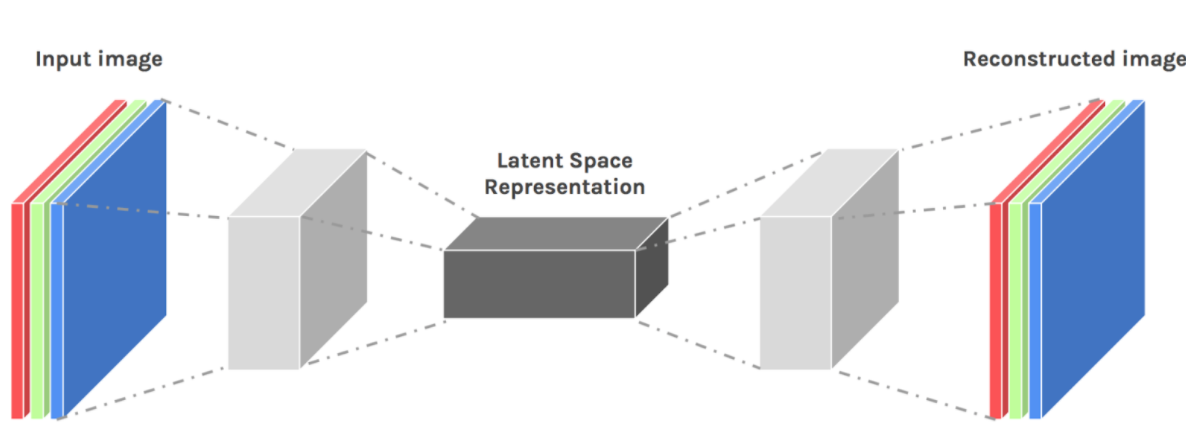

Convolutional Auto-Encoder

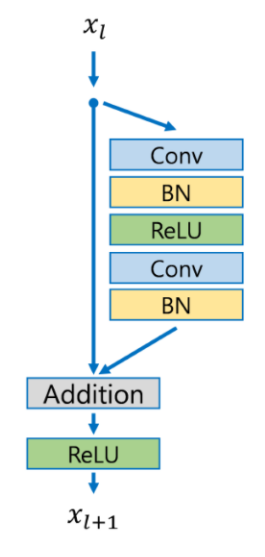

Residual Structure of EDSR

### Sample Training Plots

**Note that for the code provided here all models will provide training plots when trained but not if loaded from the save path, to force generation of the training plot a model must be deleted from the save path and retrained.**

***Note that accuracy has no meaning in this context but the loss is overall decreasing.***

Conv.
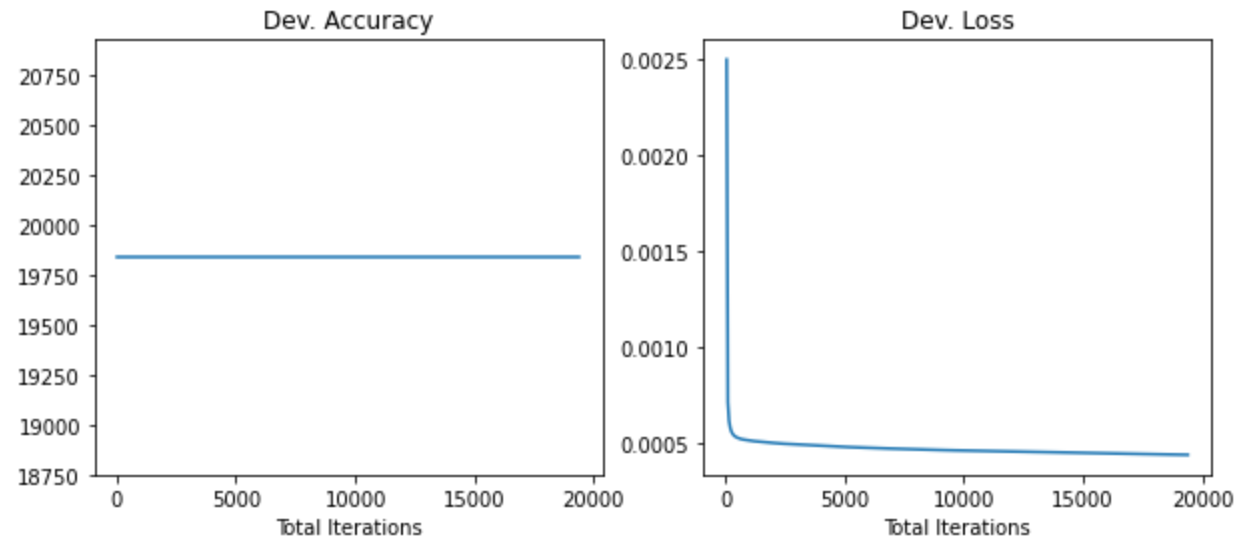

EDSR 

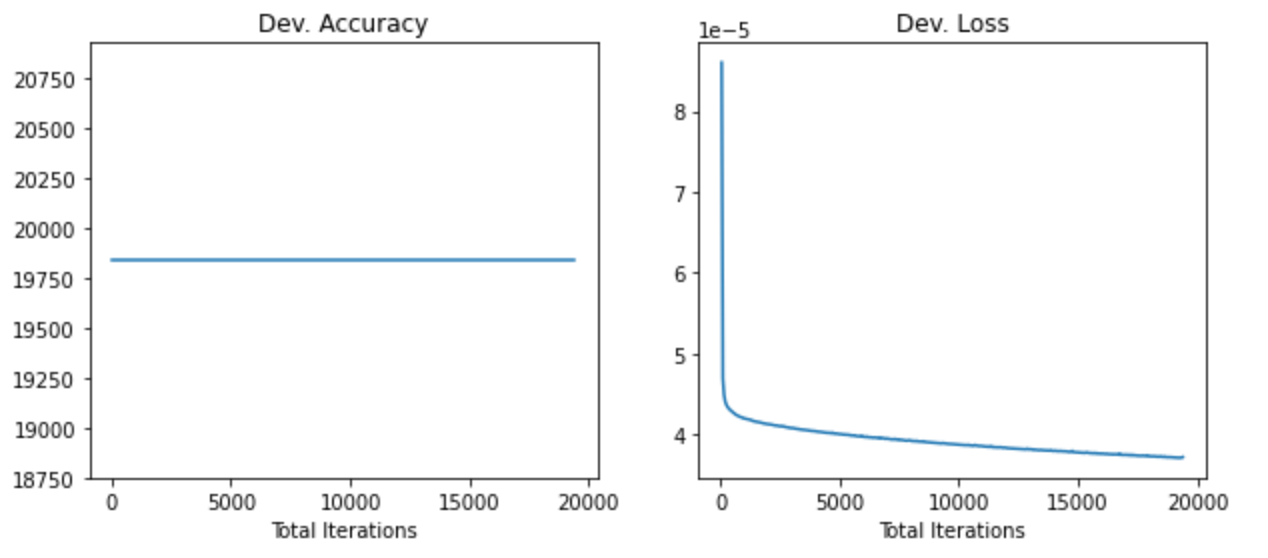


In [ ]:
#@title Make Trainloader for each adversary class { form-width: "20%" }
# Copy, shuffle, and sample

#####################################################################
temp_x = x_train_rotated
temp_y = mnist_x["train"]

rotate_trainset = ImageDataset(temp_x,temp_y)
rotate_trainloader = DataLoader(rotate_trainset,50,shuffle=True)
#####################################################################
temp_x = x_train_shifted
temp_y = mnist_x["train"]

shift_trainset = ImageDataset(temp_x,temp_y)
shift_trainloader = DataLoader(shift_trainset,50,shuffle=True)
#####################################################################
#temp_x = x_train_cropped
#temp_y = mnist_x["train"]

#crop_trainset = ImageDataset(temp_x,temp_y)
#crop_trainloader = DataLoader(crop_trainset,50,shuffle=True)
#####################################################################
temp_x = x_train_scaled
temp_y = mnist_x["train"]

scale_trainset = ImageDataset(temp_x,temp_y)
scale_trainloader = DataLoader(scale_trainset,50,shuffle=True)
#####################################################################
temp_x = x_train_affine
temp_y = mnist_x["train"]

affine_trainset = ImageDataset(temp_x,temp_y)
affine_trainloader = DataLoader(affine_trainset,50,shuffle=True)
#####################################################################
temp_x = x_train_brightness
temp_y = mnist_x["train"]

brightness_trainset = ImageDataset(temp_x,temp_y)
brightness_trainloader = DataLoader(brightness_trainset,50,shuffle=True)

#####################################################################
temp_x = x_train_blur
temp_y = mnist_x["train"]

blur_trainset = ImageDataset(temp_x,temp_y)
blur_trainloader = DataLoader(blur_trainset,50,shuffle=True)
#####################################################################
temp_x = x_train_composite_blur
#temp_x = np.append(temp_x,x_train_composite_blur,axis=0)

temp_y = mnist_x["train"]
#temp_y = np.append(temp_y,mnist_x["train"],axis=0)

composite_blur_trainset = ImageDataset(temp_x,temp_y)
composite_blur_trainloader = DataLoader(composite_blur_trainset,50,shuffle=True)
#####################################################################
temp_x = x_rotated
temp_y = mnist_x["dev"]

rotate_devset = ImageDataset(temp_x,temp_y)
rotate_devloader = DataLoader(rotate_devset,50,shuffle=True)
#####################################################################
temp_x = x_shifted
temp_y = mnist_x["dev"]

shift_devset = ImageDataset(temp_x,temp_y)
shift_devloader = DataLoader(shift_devset,50,shuffle=True)
#####################################################################
#temp_x = x_cropped
#temp_y = mnist_x["dev"]

#crop_devset = ImageDataset(temp_x,temp_y)
#crop_devloader = DataLoader(crop_devset,50,shuffle=True)
#####################################################################
temp_x = x_scaled
temp_y = mnist_x["dev"]

scale_devset = ImageDataset(temp_x,temp_y)
scale_devloader = DataLoader(scale_devset,50,shuffle=True)
#####################################################################
temp_x = x_affine
temp_y = mnist_x["dev"]

affine_devset = ImageDataset(temp_x,temp_y)
affine_devloader = DataLoader(affine_devset,50,shuffle=True)
#####################################################################
temp_x = x_brightness
temp_y = mnist_x["dev"]

brightness_devset = ImageDataset(temp_x,temp_y)
brightness_devloader = DataLoader(brightness_devset,50,shuffle=True)

#####################################################################
temp_x = x_blur
temp_y = mnist_x["dev"]

blur_devset = ImageDataset(temp_x,temp_y)
blur_devloader = DataLoader(blur_devset,50,shuffle=True)
#####################################################################
temp_x = x_composite_blur
#temp_x = np.append(temp_x,x_composite_blur,axis=0)

temp_y = mnist_x["dev"]
#temp_y = np.append(temp_y,mnist_x["dev"],axis=0)

composite_blur_devset = ImageDataset(temp_x,temp_y)
composite_blur_devloader = DataLoader(composite_blur_devset,50,shuffle=True)
#####################################################################
temp_x = x_test_rotated
temp_y = mnist_x["test"]

rotate_testset = ImageDataset(temp_x,temp_y)
rotate_testloader = DataLoader(rotate_testset,50,shuffle=True)
#####################################################################
temp_x = x_test_shifted
temp_y = mnist_x["test"]

shift_testset = ImageDataset(temp_x,temp_y)
shift_testloader = DataLoader(shift_testset,50,shuffle=True)
#####################################################################
#temp_x = x_cropped
#temp_y = mnist_x["dev"]

#crop_devset = ImageDataset(temp_x,temp_y)
#crop_devloader = DataLoader(crop_devset,50,shuffle=True)
#####################################################################
temp_x = x_test_scaled
temp_y = mnist_x["test"]

scale_testset = ImageDataset(temp_x,temp_y)
scale_testloader = DataLoader(scale_testset,50,shuffle=True)
#####################################################################
temp_x = x_test_affine
temp_y = mnist_x["test"]

affine_testset = ImageDataset(temp_x,temp_y)
affine_testloader = DataLoader(affine_testset,50,shuffle=True)
#####################################################################
temp_x = x_test_brightness
temp_y = mnist_x["test"]

brightness_testset = ImageDataset(temp_x,temp_y)
brightness_testloader = DataLoader(brightness_testset,50,shuffle=True)

#####################################################################
temp_x = x_test_blur
temp_y = mnist_x["test"]

blur_testset = ImageDataset(temp_x,temp_y)
blur_testloader = DataLoader(blur_testset,50,shuffle=True)
#####################################################################
temp_x = x_test_composite_blur
#temp_x = np.append(temp_x,train_x_composite_blur,axis=0)

temp_y = mnist_x["test"]
#temp_y = np.append(temp_y,mnist_x["train"],axis=0)

composite_blur_testset = ImageDataset(temp_x,temp_y)
composite_blur_testloader = DataLoader(composite_blur_testset,50,shuffle=True)


In [ ]:
#@title Define Auto-encoder { form-width: "20%" }
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
       
    self.LR = nn.LeakyReLU(0.1)   

    #Encoder
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1 = nn.Conv2d(1, 128, 3, padding=1)  
    self.BN1 = torch.nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
    self.BN2 = torch.nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64,32,3,padding=1)
    self.BN3 = torch.nn.BatchNorm2d(32)

    #Decoder
    self.t_conv1 = nn.ConvTranspose2d(32, 64, 2, stride=2,output_padding=1)
    self.t_conv2 = nn.ConvTranspose2d(64, 128, 2, stride=2)
    self.t_conv3 = nn.ConvTranspose2d(128,128,2, stride=2)

    #Clean up
    self.final1 = nn.Conv2d(128,64,3,padding=1)
    self.final2 = nn.Conv2d(64,1,3,padding=1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.t_conv1(x))
    x = F.relu(self.t_conv2(x))
    x = self.t_conv3(x)
    x = self.final1(x)
    x = self.final2(x)
    x = torch.sigmoid(x)
    return x # Pixels range 0 to 1

In [ ]:
#@title Define EDSR { form-width: "20%" }

#B. Lim, S. Son, H. Kim, S. Nah, and K. M. Lee, 
#“Enhanced Deep Residual Networks for Single Image Super-Resolution,” 
#arXiv:1707.02921 [cs], Jul. 2017, Accessed: Nov. 29, 2020. [Online]. 
#Available: https://arxiv.org/abs/1707.02921.

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class MeanShift(nn.Conv2d):
    def __init__(
        self, rgb_range,
        rgb_mean=(0.5,), rgb_std=(1.0,), sign=-1):

        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(1).view(1, 1, 1, 1) / std.view(1, 1, 1, 1)
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean) / std
        for p in self.parameters():
            p.requires_grad = False

class BasicBlock(nn.Sequential):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=True, act=nn.ReLU(True)):

        m = [conv(in_channels, out_channels, kernel_size, bias=bias)]
        if bn:
            m.append(nn.BatchNorm2d(out_channels))
        if act is not None:
            m.append(act)

        super(BasicBlock, self).__init__(*m)

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feats, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feats, n_feats, kernel_size, bias=bias))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if i == 0:
                m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feats, bn=False, act=False, bias=True):

        m = []
        if scale == 1:
            m.append(conv(n_feats, n_feats, 3, bias))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if act == 'relu':
                m.append(nn.ReLU(True))
            elif act == 'prelu':
                m.append(nn.PReLU(n_feats))

        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feats, 4 * n_feats, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn:
                    m.append(nn.BatchNorm2d(n_feats))
                if act == 'relu':
                    m.append(nn.ReLU(True))
                elif act == 'prelu':
                    m.append(nn.PReLU(n_feats))

        elif scale == 3:
            m.append(conv(n_feats, 9 * n_feats, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if act == 'relu':
                m.append(nn.ReLU(True))
            elif act == 'prelu':
                m.append(nn.PReLU(n_feats))
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

class EDSR(nn.Module):
    def __init__(self, scale=2, conv=default_conv, n_resblocks=2):
        super(EDSR, self).__init__()

        n_feats = 64
        kernel_size = 3 
        act = nn.ReLU(True)
        rgb_range = 1
        res_scale = 1
        n_colors = 1
        # self.url = url['r{}f{}x{}'.format(n_resblocks, n_feats, scale)]
        self.sub_mean = MeanShift(rgb_range)
        self.add_mean = MeanShift(rgb_range, sign=1)

        # define head module
        m_head = [conv(n_colors, n_feats, kernel_size)]

        # define body module
        m_body = [
            ResBlock(
                conv, n_feats, kernel_size, act=act, res_scale=res_scale
            ) for _ in range(n_resblocks)
        ]
        m_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        m_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, n_colors, kernel_size)
        ]

        self.head = nn.Sequential(*m_head)
        self.body = nn.Sequential(*m_body)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        x = self.add_mean(x)
        x = torch.sigmoid(x)
        return x 


In [ ]:
#@title Conv. Auto. Denoiser { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

grad_denoiser_conv = ConvAutoencoder()
grad_denoiser_conv.to(device)
optimizer = torch.optim.Rprop(grad_denoiser_conv.parameters(),lr=0.00000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'grad_denoiser_conv.pth'
if os.path.isfile(SAVE_PATH):
  grad_denoiser_conv.load_state_dict(torch.load(SAVE_PATH))
else:
  train(grad_denoiser_conv,optimizer,grad_attack_im_trainloader,
        "grad_denoiser_conv",epoch=10,loss_fcn=criterion,clip=True,
        plot=True,devloader=grad_attack_im_devloader)


In [ ]:
#@title EDSR Denoiser { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

grad_denoiser_edsr = EDSR(scale=1)
grad_denoiser_edsr.to(device)
optimizer = torch.optim.Rprop(grad_denoiser_edsr.parameters(), lr=0.000000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'grad_denoiser_edsr.pth'
if os.path.isfile(SAVE_PATH):
  grad_denoiser_edsr.load_state_dict(torch.load(SAVE_PATH))
else:
  train(grad_denoiser_edsr,optimizer,grad_attack_im_trainloader,"grad_denoiser_edsr",
        epoch=10,loss_fcn=criterion,clip=True,plot=True,
        devloader=grad_attack_im_devloader)


sneaker: 7
1.0
0.985
0.511953
0.88348806
0.046811834


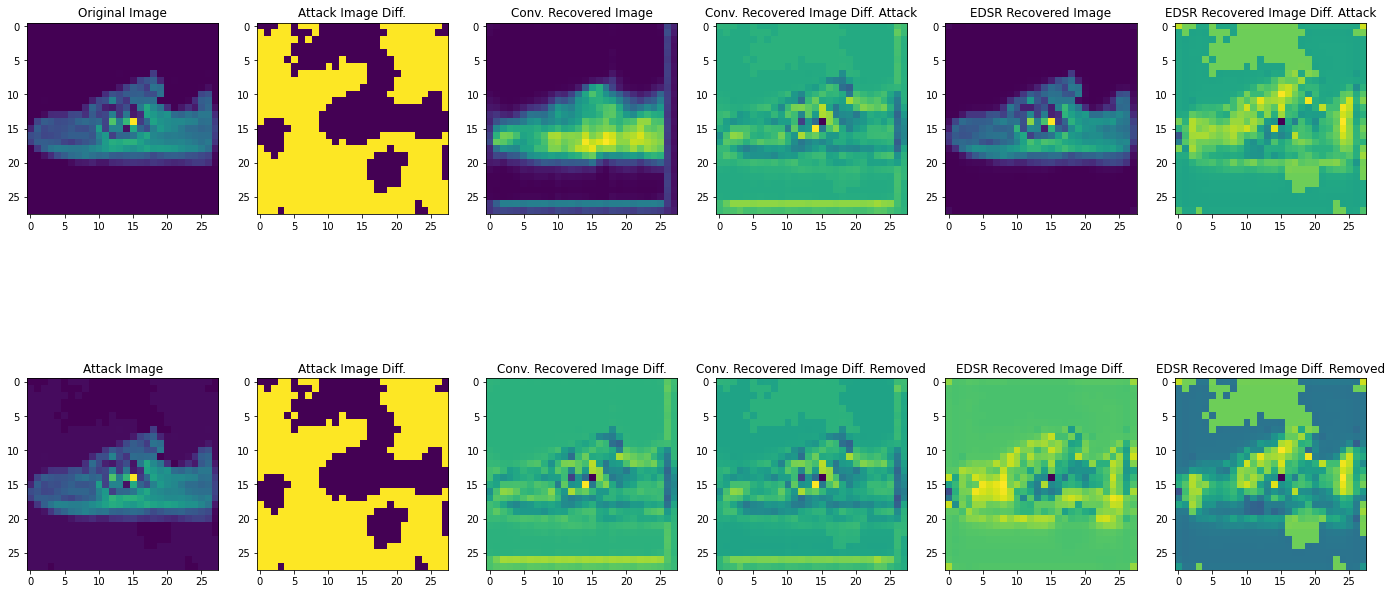

In [ ]:
#@title Plot a Few examples { form-width: "20%" }

idx = 41

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=6,figsize=(24,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow((grad_attack_im_devset.label[idx]))
print(np.max(grad_attack_im_devset.label[idx]))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((grad_attack_im_devset.data[idx]))
print(np.max(grad_attack_im_devset.data[idx]))

example = torch.from_numpy(grad_attack_im_devset.data[idx])
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("Attack Image Diff.")
ax[0][1].imshow(grad_attack_im_devset.data[idx]- grad_attack_im_devset.label[idx])

ax[1][1].set_title("Attack Image Diff.")
ax[1][1].imshow(grad_attack_im_devset.data[idx]- grad_attack_im_devset.label[idx])

ax[0][2].set_title("Conv. Recovered Image")
temp = grad_denoiser_conv(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][2].imshow(temp)
print(np.max(temp))

ax[1][2].set_title("Conv. Recovered Image Diff.")
ax[1][2].imshow(temp - grad_attack_im_devset.label[idx])

ax[0][3].set_title("Conv. Recovered Image Diff. Attack")
ax[0][3].imshow(temp - grad_attack_im_devset.data[idx])

ax[1][3].set_title("Conv. Recovered Image Diff. Removed")
ax[1][3].imshow((temp - grad_attack_im_devset.data[idx]) - (grad_attack_im_devset.data[idx]- grad_attack_im_devset.label[idx]))

ax[0][4].set_title("EDSR Recovered Image")
temp = grad_denoiser_edsr(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][4].imshow(temp)
print(np.max(temp))

ax[1][4].set_title("EDSR Recovered Image Diff.")
ax[1][4].imshow(temp - grad_attack_im_devset.label[idx])
print(np.max(temp - grad_attack_im_devset.label[idx]))

ax[0][5].set_title("EDSR Recovered Image Diff. Attack")
ax[0][5].imshow(temp - grad_attack_im_devset.data[idx])

ax[1][5].set_title("EDSR Recovered Image Diff. Removed")
ax[1][5].imshow((temp - grad_attack_im_devset.data[idx]) - (grad_attack_im_devset.data[idx]- grad_attack_im_devset.label[idx]))

In [ ]:
#@title Test EDSR Gradient Denoiser { form-width: "20%" }

print("FGSM")
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_fgsm_devloader,denoiser=grad_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_fgsm_devloader,denoiser=grad_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_fgsm_devloader,denoiser=grad_denoiser_edsr)[0]}')

print("\nPGD")
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_pgd_devloader,denoiser=grad_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_pgd_devloader,denoiser=grad_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_pgd_devloader,denoiser=grad_denoiser_edsr)[0]}')

print("\nBIM")
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_bim_devloader,denoiser=grad_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_bim_devloader,denoiser=grad_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_bim_devloader,denoiser=grad_denoiser_edsr)[0]}')

print("\nShuffled")
print(f'FF test accuracy: {test(mnist_ff,grad_attack_devloader,denoiser=grad_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,grad_attack_devloader,denoiser=grad_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,grad_attack_devloader,denoiser=grad_denoiser_edsr)[0]}')

FGSM
FF test accuracy: 0.7533333333333333
CNN test accuracy: 0.3925
Composite test accuracy: 0.7208333333333333

PGD
FF test accuracy: 0.6883333333333334
CNN test accuracy: 0.30083333333333334
Composite test accuracy: 0.6458333333333334

BIM
FF test accuracy: 0.4891666666666667
CNN test accuracy: 0.2675
Composite test accuracy: 0.5833333333333334

Shuffled
FF test accuracy: 0.7203703703703703
CNN test accuracy: 0.3869444444444444
Composite test accuracy: 0.6827777777777778


In [ ]:
#@title Test Conv Gradient Denoiser { form-width: "20%" }

print("FGSM")
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_fgsm_devloader,denoiser=grad_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_fgsm_devloader,denoiser=grad_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_fgsm_devloader,denoiser=grad_denoiser_conv)[0]}')

print("\nPGD")
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_pgd_devloader,denoiser=grad_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_pgd_devloader,denoiser=grad_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_pgd_devloader,denoiser=grad_denoiser_conv)[0]}')

print("\nBIM")
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_bim_devloader,denoiser=grad_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_bim_devloader,denoiser=grad_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_bim_devloader,denoiser=grad_denoiser_conv)[0]}')

print("\nShuffled")
print(f'FF test accuracy: {test(mnist_ff,grad_attack_devloader,denoiser=grad_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,grad_attack_devloader,denoiser=grad_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,grad_attack_devloader,denoiser=grad_denoiser_conv)[0]}')

FGSM
FF test accuracy: 0.705
CNN test accuracy: 0.4125
Composite test accuracy: 0.6758333333333333

PGD
FF test accuracy: 0.6775
CNN test accuracy: 0.38083333333333336
Composite test accuracy: 0.6208333333333333

BIM
FF test accuracy: 0.5458333333333333
CNN test accuracy: 0.34833333333333333
Composite test accuracy: 0.5933333333333334

Shuffled
FF test accuracy: 0.6822222222222222
CNN test accuracy: 0.4064814814814815
Composite test accuracy: 0.6500925925925926


In [ ]:
#@title Conv. Rand Denoiser { form-width: "20%" }
rand_denoiser_conv = ConvAutoencoder()
rand_denoiser_conv.to(device)
optimizer = torch.optim.Rprop(rand_denoiser_conv.parameters(),lr=0.00000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'rand_denoiser_conv.pth'
if os.path.isfile(SAVE_PATH):
  rand_denoiser_conv.load_state_dict(torch.load(SAVE_PATH))
else:
  train(rand_denoiser_conv,optimizer,rand_attack_im_trainloader,"rand_denoiser_conv",
      epoch=10,loss_fcn=criterion,clip=True,plot=True,devloader=rand_attack_im_devloader)

In [ ]:
#@title EDSR Rand Denoiser { form-width: "20%" }
rand_denoiser_edsr = EDSR(scale=1)
rand_denoiser_edsr.to(device)
optimizer = torch.optim.Rprop(rand_denoiser_edsr.parameters(),lr=0.00000000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'rand_denoiser_edsr.pth'
if os.path.isfile(SAVE_PATH):
  rand_denoiser_edsr.load_state_dict(torch.load(SAVE_PATH))
else:
  train(rand_denoiser_edsr,optimizer,rand_attack_im_trainloader,"rand_denoiser_edsr",
      epoch=5,loss_fcn=criterion,clip=True,plot=True,devloader=rand_attack_im_devloader)

sneaker: 7
1.0
0.9529849563807593
0.52989507
0.9388093
0.106606856


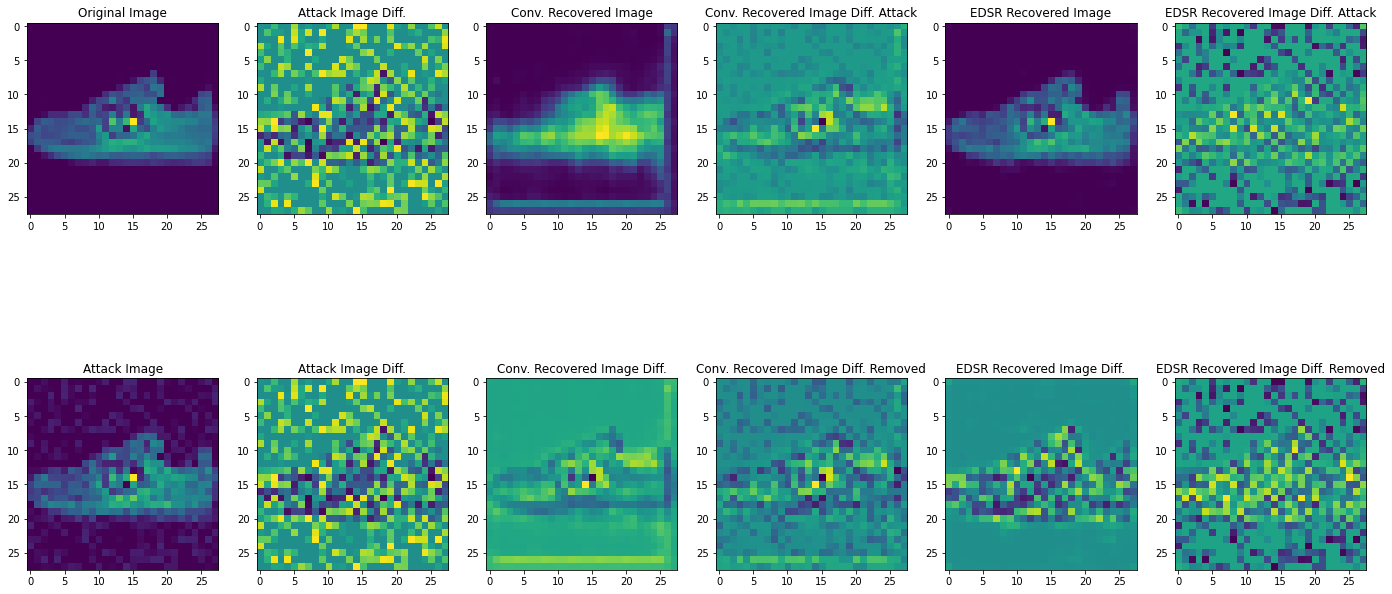

In [ ]:
#@title Plot a Few examples { form-width: "20%" }

idx = 41

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=6,figsize=(24,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow((rand_attack_im_devset.label[idx]))
print(np.max(rand_attack_im_devset.label[idx]))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((rand_attack_im_devset.data[idx]))
print(np.max(rand_attack_im_devset.data[idx]))

example = torch.from_numpy(rand_attack_im_devset.data[idx])
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("Attack Image Diff.")
ax[0][1].imshow(rand_attack_im_devset.data[idx]- rand_attack_im_devset.label[idx])

ax[1][1].set_title("Attack Image Diff.")
ax[1][1].imshow(rand_attack_im_devset.data[idx]- rand_attack_im_devset.label[idx])

ax[0][2].set_title("Conv. Recovered Image")
temp = rand_denoiser_conv(example.to(device).float())
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][2].imshow(temp)
print(np.max(temp))

ax[1][2].set_title("Conv. Recovered Image Diff.")
ax[1][2].imshow(temp - rand_attack_im_devset.label[idx])

ax[0][3].set_title("Conv. Recovered Image Diff. Attack")
ax[0][3].imshow(temp - rand_attack_im_devset.data[idx])

ax[1][3].set_title("Conv. Recovered Image Diff. Removed")
ax[1][3].imshow((temp - rand_attack_im_devset.data[idx]) - (rand_attack_im_devset.data[idx]- rand_attack_im_devset.label[idx]))

ax[0][4].set_title("EDSR Recovered Image")
temp = rand_denoiser_edsr(example.to(device).float())
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][4].imshow(temp)
print(np.max(temp))

ax[1][4].set_title("EDSR Recovered Image Diff.")
ax[1][4].imshow(temp - rand_attack_im_devset.label[idx])
print(np.max(temp - rand_attack_im_devset.label[idx]))

ax[0][5].set_title("EDSR Recovered Image Diff. Attack")
ax[0][5].imshow(temp - rand_attack_im_devset.data[idx])

ax[1][5].set_title("EDSR Recovered Image Diff. Removed")
ax[1][5].imshow((temp - rand_attack_im_devset.data[idx]) - (rand_attack_im_devset.data[idx]- rand_attack_im_devset.label[idx]))

In [ ]:
#@title Test Conv. Rand. Denoiser { form-width: "20%" }

print("RP")
print(f'FF test accuracy: {test(mnist_ff,mnist_rp_devloader,denoiser=rand_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_rp_devloader,denoiser=rand_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_rp_devloader,denoiser=rand_denoiser_conv)[0]}')

print("\nSimBA")
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_simba_devloader,denoiser=rand_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_simba_devloader,denoiser=rand_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_simba_devloader,denoiser=rand_denoiser_conv)[0]}')

print("\nShuffled")
print(f'FF test accuracy: {test(mnist_ff,rand_attack_devloader,denoiser=rand_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,rand_attack_devloader,denoiser=rand_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,rand_attack_devloader,denoiser=rand_denoiser_conv)[0]}')

RP
FF test accuracy: 0.7433333333333333
CNN test accuracy: 0.43
Composite test accuracy: 0.6858333333333333

SimBA
FF test accuracy: 0.6958333333333333
CNN test accuracy: 0.40166666666666667
Composite test accuracy: 0.675

Shuffled
FF test accuracy: 0.725
CNN test accuracy: 0.41875
Composite test accuracy: 0.6791666666666667


In [ ]:
#@title Test EDSR Rand. Denoiser { form-width: "20%" }

print("RP")
print(f'FF test accuracy: {test(mnist_ff,mnist_rp_devloader,denoiser=rand_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_rp_devloader,denoiser=rand_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_rp_devloader,denoiser=rand_denoiser_edsr)[0]}')

print("\nSimBA")
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_simba_devloader,denoiser=rand_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_simba_devloader,denoiser=rand_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_simba_devloader,denoiser=rand_denoiser_edsr)[0]}')

print("\nShuffled")
print(f'FF test accuracy: {test(mnist_ff,rand_attack_devloader,denoiser=rand_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,rand_attack_devloader,denoiser=rand_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,rand_attack_devloader,denoiser=rand_denoiser_edsr)[0]}')

RP
FF test accuracy: 0.7891666666666667
CNN test accuracy: 0.43833333333333335
Composite test accuracy: 0.7325

SimBA
FF test accuracy: 0.735
CNN test accuracy: 0.3675
Composite test accuracy: 0.7116666666666667

Shuffled
FF test accuracy: 0.769375
CNN test accuracy: 0.415625
Composite test accuracy: 0.719375


In [ ]:
#@title Rotate Denoiser { form-width: "20%" }

rotate_denoiser_conv = ConvAutoencoder()
rotate_denoiser_conv.to(device)
optimizer = torch.optim.Rprop(rotate_denoiser_conv.parameters(),lr=0.00000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'rotate_denoiser_conv.pth'
if os.path.isfile(SAVE_PATH):
  rotate_denoiser_conv.load_state_dict(torch.load(SAVE_PATH))
else:
  train(rotate_denoiser_conv,optimizer,rotate_trainloader,"rotate_denoiser_conv",
        epoch=10,loss_fcn=criterion,clip=True,plot=True,devloader=rotate_devloader)


In [ ]:
#@title Test Rotate Denoiser { form-width: "20%" }

mnist_rotate_testset = ImageDataset(x_test_rotated,mnist_y["test"])
mnist_rotate_testloader = DataLoader(mnist_rotate_testset,50,shuffle=True)

print("Undefended")
print(f'FF test accuracy: {test(mnist_ff,mnist_rotate_testloader,denoiser=None)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_rotate_testloader,denoiser=None)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_rotate_testloader,denoiser=None)[0]}')

print("\nRotate Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_rotate_testloader,denoiser=rotate_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_rotate_testloader,denoiser=rotate_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_rotate_testloader,denoiser=rotate_denoiser_conv)[0]}')

Undefended
FF test accuracy: 0.1835
CNN test accuracy: 0.164
Composite test accuracy: 0.2395

Rotate Defended
FF test accuracy: 0.125
CNN test accuracy: 0.109
Composite test accuracy: 0.1245


sneaker: 7
1.0
1.0
0.4179926
0.3341583


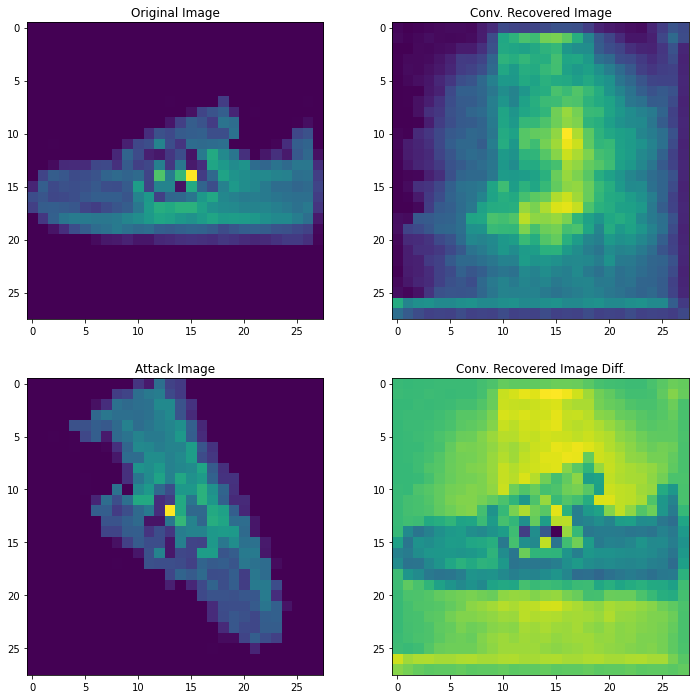

In [ ]:
#@title Plot a Few examples, Rotate { form-width: "20%" }

idx = 41

orig = mnist_x["dev"][idx]
attack = x_rotated[idx]

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow(orig)
print(np.max(orig))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((attack))
print(np.max(attack))

example = torch.from_numpy(attack).float()
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("Conv. Recovered Image")
temp = rotate_denoiser_conv(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][1].imshow(temp)
print(np.max(temp))

ax[1][1].set_title("Conv. Recovered Image Diff.")
ax[1][1].imshow(temp-orig)
print(np.max(temp-orig))


In [ ]:
#@title Shift Denoiser { form-width: "20%" }

shift_denoiser_conv = ConvAutoencoder()
shift_denoiser_conv.to(device)
optimizer = torch.optim.Rprop(shift_denoiser_conv.parameters(),lr=0.00001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'shift_denoiser_conv.pth'
if os.path.isfile(SAVE_PATH):
  shift_denoiser_conv.load_state_dict(torch.load(SAVE_PATH))
else:
  train(shift_denoiser_conv,optimizer,shift_trainloader,"shift_denoiser_conv",
        epoch=10,loss_fcn=criterion,clip=True,plot=True,devloader=shift_devloader)

In [ ]:
#@title Test Shift Denoiser { form-width: "20%" }

mnist_shift_testset = ImageDataset(x_test_shifted,mnist_y["test"])
mnist_shift_testloader = DataLoader(mnist_shift_testset,50,shuffle=True)

print("Undefended")
print(f'FF test accuracy: {test(mnist_ff,mnist_shift_testloader,denoiser=None)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_shift_testloader,denoiser=None)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_shift_testloader,denoiser=None)[0]}')

print("\nShifted Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_shift_testloader,denoiser=shift_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_shift_testloader,denoiser=shift_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_shift_testloader,denoiser=shift_denoiser_conv)[0]}')

Undefended
FF test accuracy: 0.524
CNN test accuracy: 0.384
Composite test accuracy: 0.637

Shifted Defended
FF test accuracy: 0.5385
CNN test accuracy: 0.327
Composite test accuracy: 0.486


sneaker: 7
1.0
1.0
0.5550005
0.4307299


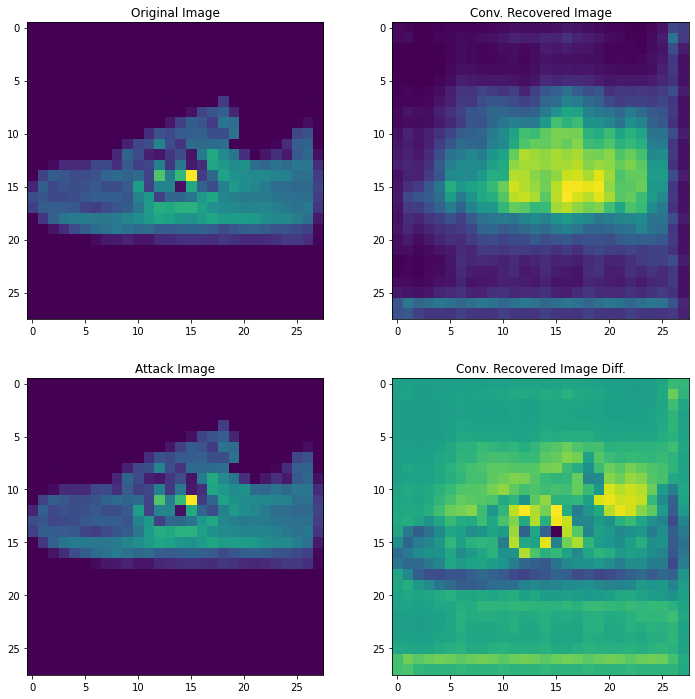

In [ ]:
#@title Plot a Few examples, Shift { form-width: "20%" }

idx = 41

orig = mnist_x["dev"][idx]
attack = x_shifted[idx]

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow(orig)
print(np.max(orig))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((attack))
print(np.max(attack))

example = torch.from_numpy(attack).float()
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("Conv. Recovered Image")
temp = shift_denoiser_conv(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][1].imshow(temp)
print(np.max(temp))

ax[1][1].set_title("Conv. Recovered Image Diff.")
ax[1][1].imshow(temp-orig)
print(np.max(temp-orig))


In [ ]:
#@title Scale Denoiser { form-width: "20%" }

scale_denoiser_conv = ConvAutoencoder()
scale_denoiser_conv.to(device)
optimizer = torch.optim.Rprop(scale_denoiser_conv.parameters(),lr=0.00001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'scale_denoiser_conv.pth'
if os.path.isfile(SAVE_PATH):
  scale_denoiser_conv.load_state_dict(torch.load(SAVE_PATH))
else:
  train(scale_denoiser_conv,optimizer,scale_trainloader,"scale_denoiser_conv",
        epoch=10,loss_fcn=criterion,clip=True,plot=True,devloader=scale_devloader)

In [ ]:
#@title Test Scale Denoiser { form-width: "20%" }

mnist_scale_testset = ImageDataset(x_test_scaled,mnist_y["test"])
mnist_scale_testloader = DataLoader(mnist_scale_testset,50,shuffle=True)

print("Undefended")
print(f'FF test accuracy: {test(mnist_ff,mnist_scale_testloader,denoiser=None)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_scale_testloader,denoiser=None)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_scale_testloader,denoiser=None)[0]}')

print("\nScale Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_scale_testloader,denoiser=scale_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_scale_testloader,denoiser=scale_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_scale_testloader,denoiser=scale_denoiser_conv)[0]}')

Undefended
FF test accuracy: 0.7085
CNN test accuracy: 0.4065
Composite test accuracy: 0.709

Scale Defended
FF test accuracy: 0.6675
CNN test accuracy: 0.392
Composite test accuracy: 0.6585


sneaker: 7
1.0
1.0
0.593861
0.426404


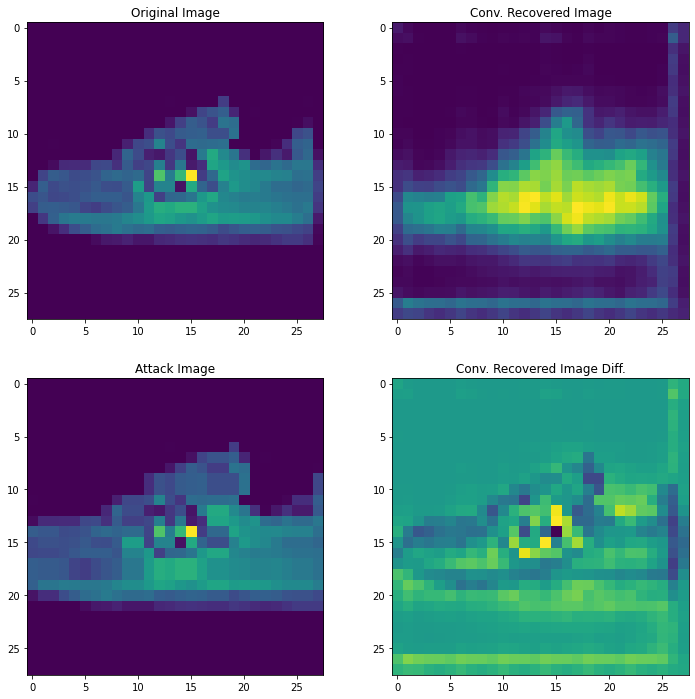

In [ ]:
#@title Plot a Few examples, Scale { form-width: "20%" }

idx = 41

orig = mnist_x["dev"][idx]
attack = x_scaled[idx]

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow(orig)
print(np.max(orig))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((attack))
print(np.max(attack))

example = torch.from_numpy(attack).float()
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("Conv. Recovered Image")
temp = scale_denoiser_conv(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][1].imshow(temp)
print(np.max(temp))

ax[1][1].set_title("Conv. Recovered Image Diff.")
ax[1][1].imshow(temp-orig)
print(np.max(temp-orig))


In [ ]:
#@title Affine Denoiser { form-width: "20%" }

affine_denoiser_conv = ConvAutoencoder()
affine_denoiser_conv.to(device)
optimizer = torch.optim.Rprop(affine_denoiser_conv.parameters(),lr=0.00001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'affine_denoiser_conv.pth'
if os.path.isfile(SAVE_PATH):
  affine_denoiser_conv.load_state_dict(torch.load(SAVE_PATH))
else:
  train(affine_denoiser_conv,optimizer,affine_trainloader,"affine_denoiser_conv",
        epoch=10,loss_fcn=criterion,clip=True,plot=True,devloader=affine_devloader)

In [ ]:
#@title Test Affine Denoiser { form-width: "20%" }

mnist_affine_testset = ImageDataset(x_test_affine,mnist_y["test"])
mnist_affine_testloader = DataLoader(mnist_affine_testset,50,shuffle=True)

print("Undefended")
print(f'FF test accuracy: {test(mnist_ff,mnist_affine_testloader,denoiser=None)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_affine_testloader,denoiser=None)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_affine_testloader,denoiser=None)[0]}')

print("\nAffine Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_affine_testloader,denoiser=affine_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_affine_testloader,denoiser=affine_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_affine_testloader,denoiser=affine_denoiser_conv)[0]}')

Undefended
FF test accuracy: 0.35
CNN test accuracy: 0.277
Composite test accuracy: 0.452

Affine Defended
FF test accuracy: 0.2995
CNN test accuracy: 0.196
Composite test accuracy: 0.275


sneaker: 7
1.0
1.0
0.43436483
0.36064672


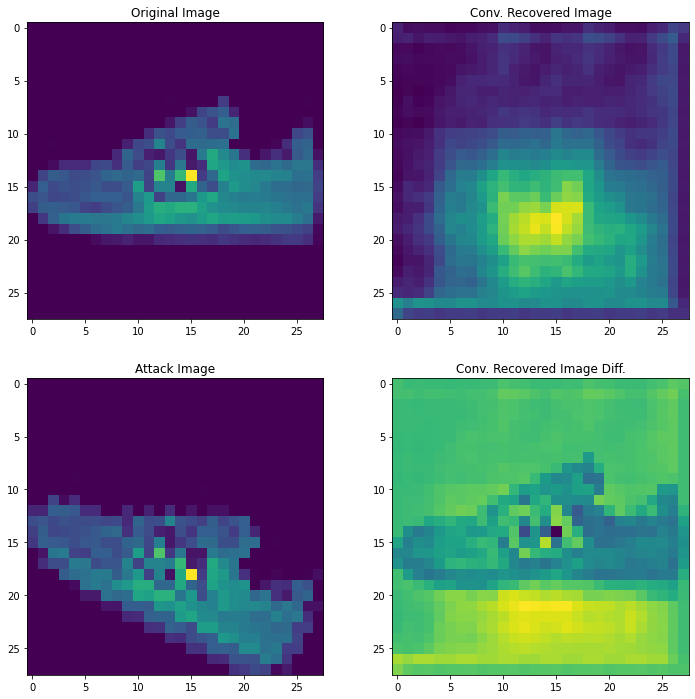

In [ ]:
#@title Plot a Few examples, Affine { form-width: "20%" }

idx = 41

orig = mnist_x["dev"][idx]
attack = x_affine[idx]

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow(orig)
print(np.max(orig))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((attack))
print(np.max(attack))

example = torch.from_numpy(attack).float()
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("Conv. Recovered Image")
temp = affine_denoiser_conv(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][1].imshow(temp)
print(np.max(temp))

ax[1][1].set_title("Conv. Recovered Image Diff.")
ax[1][1].imshow(temp-orig)
print(np.max(temp-orig))


In [ ]:
#@title Brightness Denoiser Conv. { form-width: "20%" }

brightness_denoiser_conv = ConvAutoencoder()
brightness_denoiser_conv.to(device)
optimizer = torch.optim.Rprop(brightness_denoiser_conv.parameters(),lr=0.00001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'brightness_denoiser_conv.pth'
if os.path.isfile(SAVE_PATH):
  brightness_denoiser_conv.load_state_dict(torch.load(SAVE_PATH))
else:
  train(brightness_denoiser_conv,optimizer,brightness_trainloader,"brightness_denoiser_conv",
        epoch=40,loss_fcn=criterion,clip=True,plot=True,devloader=brightness_devloader)

In [ ]:
#@title Brightness Denoiser EDSR { form-width: "20%" }

brightness_denoiser_edsr = EDSR(scale=1)
brightness_denoiser_edsr.to(device)
optimizer = torch.optim.Rprop(brightness_denoiser_edsr.parameters(),lr=0.000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'brightness_denoiser_edsr.pth'
if os.path.isfile(SAVE_PATH):
  brightness_denoiser_edsr.load_state_dict(torch.load(SAVE_PATH))
else:
  train(brightness_denoiser_edsr,optimizer,brightness_trainloader,"brightness_denoiser_edsr",
        epoch=150,loss_fcn=criterion,clip=True,plot=True,devloader=brightness_devloader)

In [ ]:
#@title Test Brightness Denoiser { form-width: "20%" }

mnist_brightness_testset = ImageDataset(x_test_brightness,mnist_y["test"])
mnist_brightness_testloader = DataLoader(mnist_brightness_testset,50,shuffle=True)

print("Undefended")
print(f'FF test accuracy: {test(mnist_ff,mnist_brightness_testloader,denoiser=None)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_brightness_testloader,denoiser=None)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_brightness_testloader,denoiser=None)[0]}')

print("\nBrightness Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_brightness_testloader,denoiser=brightness_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_brightness_testloader,denoiser=brightness_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_brightness_testloader,denoiser=brightness_denoiser_conv)[0]}')

print("\nEDSR Brightness Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_brightness_testloader,denoiser=brightness_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_brightness_testloader,denoiser=brightness_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_brightness_testloader,denoiser=brightness_denoiser_edsr)[0]}')

Undefended
FF test accuracy: 0.795
CNN test accuracy: 0.4485
Composite test accuracy: 0.7475

Brightness Defended
FF test accuracy: 0.7405
CNN test accuracy: 0.425
Composite test accuracy: 0.7015

EDSR Brightness Defended
FF test accuracy: 0.7935
CNN test accuracy: 0.4425
Composite test accuracy: 0.7195


sneaker: 7
1.0
1.0
0.83176446
0.53415835
0.90848273
0.4005185


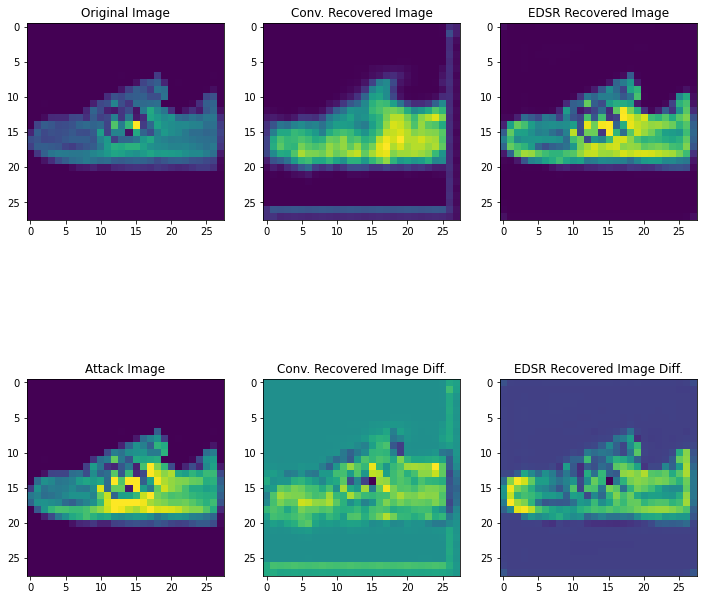

In [ ]:
#@title Plot a Few examples, Brightness { form-width: "20%" }

idx = 41

orig = mnist_x["dev"][idx]
attack = x_brightness[idx]

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(12,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow(orig)
print(np.max(orig))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((attack))
print(np.max(attack))

example = torch.from_numpy(attack).float()
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("Conv. Recovered Image")
temp = brightness_denoiser_conv(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][1].imshow(temp)
print(np.max(temp))

ax[1][1].set_title("Conv. Recovered Image Diff.")
ax[1][1].imshow(temp-orig)
print(np.max(temp-orig))

ax[0][2].set_title("EDSR Recovered Image")
temp = brightness_denoiser_edsr(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][2].imshow(temp)
print(np.max(temp))

ax[1][2].set_title("EDSR Recovered Image Diff.")
ax[1][2].imshow(temp-orig)
print(np.max(temp-orig))


In [ ]:
#@title Blur Denoiser { form-width: "20%" }

blur_denoiser_conv = ConvAutoencoder()
blur_denoiser_conv.to(device)
optimizer = torch.optim.Rprop(blur_denoiser_conv.parameters(),lr=0.00001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'blur_denoiser_conv.pth'
if os.path.isfile(SAVE_PATH):
  blur_denoiser_conv.load_state_dict(torch.load(SAVE_PATH))
else:
  train(blur_denoiser_conv,optimizer,blur_trainloader,"blur_denoiser_conv",
        epoch=10,loss_fcn=criterion,clip=True,plot=True,devloader=blur_devloader)

In [ ]:
#@title Blur Denoiser EDSR { form-width: "20%" }

blur_denoiser_edsr = EDSR(scale=1)
blur_denoiser_edsr.to(device)
optimizer = torch.optim.Rprop(blur_denoiser_edsr.parameters(),lr=0.00001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'blur_denoiser_edsr.pth'
if os.path.isfile(SAVE_PATH):
  blur_denoiser_edsr.load_state_dict(torch.load(SAVE_PATH))
else:
  train(blur_denoiser_edsr,optimizer,blur_trainloader,"blur_denoiser_edsr",
        epoch=10,loss_fcn=criterion,clip=True,plot=True,devloader=blur_devloader)

In [ ]:
#@title Test Blur Denoiser { form-width: "20%" }

mnist_blur_testset = ImageDataset(x_test_blur,mnist_y["test"])
mnist_blur_testloader = DataLoader(mnist_blur_testset,50,shuffle=True)

print("Undefended")
print(f'FF test accuracy: {test(mnist_ff,mnist_blur_testloader,denoiser=None)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_blur_testloader,denoiser=None)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_blur_testloader,denoiser=None)[0]}')

print("\nBlur Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_blur_testloader,denoiser=blur_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_blur_testloader,denoiser=blur_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_blur_testloader,denoiser=blur_denoiser_conv)[0]}')

print("\nEDSR Blur Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_blur_testloader,denoiser=blur_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_blur_testloader,denoiser=blur_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_blur_testloader,denoiser=blur_denoiser_edsr)[0]}')

Undefended
FF test accuracy: 0.785
CNN test accuracy: 0.441
Composite test accuracy: 0.733

Blur Defended
FF test accuracy: 0.733
CNN test accuracy: 0.4405
Composite test accuracy: 0.7015

EDSR Blur Defended
FF test accuracy: 0.7955
CNN test accuracy: 0.4495
Composite test accuracy: 0.7455


sneaker: 7
1.0
0.6819811
0.58755136
0.30856508
0.97505546
0.162224


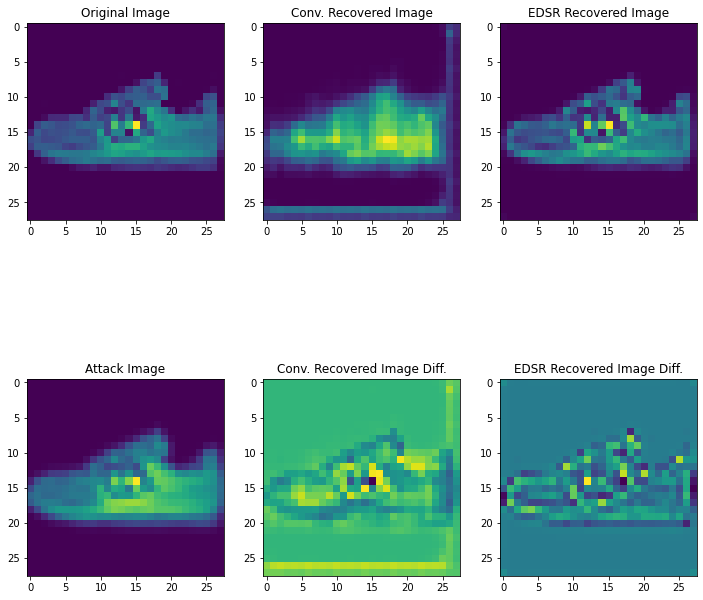

In [ ]:
#@title Plot a Few examples, Blur { form-width: "20%" }

idx = 41

orig = mnist_x["dev"][idx]
attack = x_blur[idx]

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(12,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow(orig)
print(np.max(orig))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((attack))
print(np.max(attack))

example = torch.from_numpy(attack).float()
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("Conv. Recovered Image")
temp = blur_denoiser_conv(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][1].imshow(temp)
print(np.max(temp))

ax[1][1].set_title("Conv. Recovered Image Diff.")
ax[1][1].imshow(temp-orig)
print(np.max(temp-orig))

ax[0][2].set_title("EDSR Recovered Image")
temp = blur_denoiser_edsr(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][2].imshow(temp)
print(np.max(temp))

ax[1][2].set_title("EDSR Recovered Image Diff.")
ax[1][2].imshow(temp-orig)
print(np.max(temp-orig))


In [ ]:
#@title Composite Denoiser Conv { form-width: "20%" }

composite_denoiser_conv = ConvAutoencoder()
composite_denoiser_conv.to(device)
optimizer = torch.optim.Rprop(composite_denoiser_conv.parameters(),lr=0.00001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'composite_denoiser_conv.pth'
if os.path.isfile(SAVE_PATH):
  composite_denoiser_conv.load_state_dict(torch.load(SAVE_PATH))
else:
  train(composite_denoiser_conv,optimizer,composite_blur_trainloader,"composite_denoiser_conv",
        epoch=10,loss_fcn=criterion,clip=True,plot=True,devloader=composite_blur_devloader)

In [ ]:
#@title Composite Denoiser EDSR { form-width: "20%" }

composite_denoiser_edsr = EDSR(scale=1)
composite_denoiser_edsr.to(device)
optimizer = torch.optim.Rprop(composite_denoiser_edsr.parameters(),lr=0.000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'composite_denoiser_edsr.pth'
if os.path.isfile(SAVE_PATH):
  composite_denoiser_edsr.load_state_dict(torch.load(SAVE_PATH))
else:
  train(composite_denoiser_edsr,optimizer,composite_blur_trainloader,"composite_denoiser_edsr",
        epoch=10,loss_fcn=criterion,clip=True,plot=True,devloader=composite_blur_devloader)

In [ ]:
#@title Test Composite Denoiser { form-width: "20%" }

mnist_composite_blur_testset = ImageDataset(x_test_composite_blur,mnist_y["test"])
mnist_composite_blur_testloader = DataLoader(mnist_composite_blur_testset,50,shuffle=True)

print("Undefended")
print(f'FF test accuracy: {test(mnist_ff,mnist_composite_blur_testloader,denoiser=None)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_composite_blur_testloader,denoiser=None)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_composite_blur_testloader,denoiser=None)[0]}')

print("\nBlur Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_composite_blur_testloader,denoiser=composite_denoiser_conv)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_composite_blur_testloader,denoiser=composite_denoiser_conv)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_composite_blur_testloader,denoiser=composite_denoiser_conv)[0]}')

print("\nEDSR Blur Defended")
print(f'FF test accuracy: {test(mnist_ff,mnist_composite_blur_testloader,denoiser=composite_denoiser_edsr)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_composite_blur_testloader,denoiser=composite_denoiser_edsr)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_composite_blur_testloader,denoiser=composite_denoiser_edsr)[0]}')

Undefended
FF test accuracy: 0.327
CNN test accuracy: 0.25
Composite test accuracy: 0.41

Blur Defended
FF test accuracy: 0.3335
CNN test accuracy: 0.1985
Composite test accuracy: 0.308

EDSR Blur Defended
FF test accuracy: 0.2715
CNN test accuracy: 0.1985
Composite test accuracy: 0.3005


sneaker: 7
1.0
0.7239214
0.56044066
0.42472187
0.39979875
0.3538613


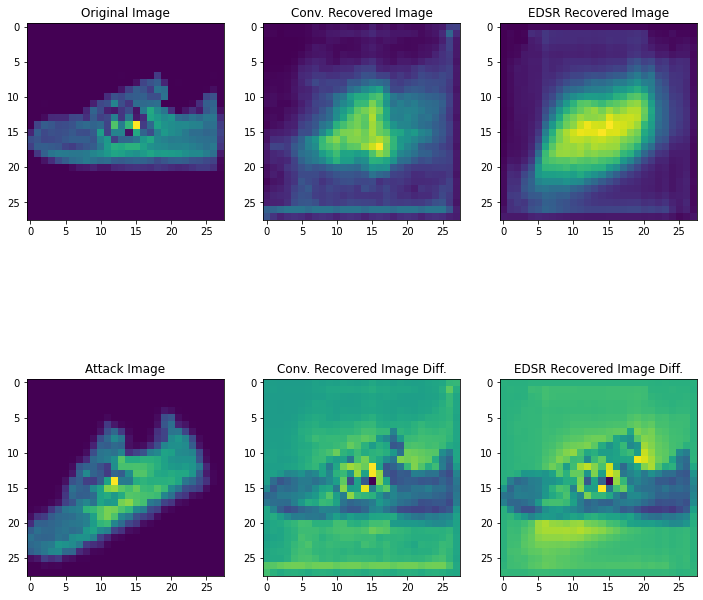

In [ ]:
#@title Plot a Few examples, Composite blur { form-width: "20%" }

idx = 41

orig = mnist_x["dev"][idx]
attack = x_composite_blur[idx]

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(12,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow(orig)
print(np.max(orig))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((attack))
print(np.max(attack))

example = torch.from_numpy(attack).float()
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("Conv. Recovered Image")
temp = composite_denoiser_conv(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][1].imshow(temp)
print(np.max(temp))

ax[1][1].set_title("Conv. Recovered Image Diff.")
ax[1][1].imshow(temp-orig)
print(np.max(temp-orig))

ax[0][2].set_title("EDSR Recovered Image")
temp = composite_denoiser_edsr(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][2].imshow(temp)
print(np.max(temp))

ax[1][2].set_title("EDSR Recovered Image Diff.")
ax[1][2].imshow(temp-orig)
print(np.max(temp-orig))


## Adversarial and Augmented Training

To facillitate discussion about data deficiency and the bias-variance interpretation about adversarial machine learning adversarial and augmented training was performed on the baseline architectures and plugged into SPIE-D for evaluation.

### Train with transforms (Augmented)

In [ ]:
#@title Train FF with transforms { form-width: "20%" }

sub = 3

subsample_transform_x_train = transform_attack_x_train_raw[0::sub]
subsample_transform_y_train = transform_attack_y_train_raw[0::sub]
subsample_transform_x_dev = transform_attack_x_devraw[0::sub]
subsample_transform_y_dev = transform_attack_y_devraw[0::sub]

transform_attack_sub_trainset = ImageDataset(subsample_transform_x_train,subsample_transform_y_train)
transform_attack_sub_trainloader = DataLoader(transform_attack_sub_trainset,50,shuffle=True)

transform_attack_sub_devset = ImageDataset(subsample_transform_x_dev,subsample_transform_y_dev)
transform_attack_sub_devloader = DataLoader(transform_attack_sub_devset,50,shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_ff_transform = FF(in_flat_dim=28*28*1,up1=3,out_dim=10,h1=1000,h2=100)
mnist_ff_transform.to(device)
optimizer = torch.optim.Adam(mnist_ff_transform.parameters(),lr=0.000003)

SAVE_PATH = PATH + 'mnist_ff_transform.pth'
if os.path.isfile(SAVE_PATH):
  mnist_ff_transform.load_state_dict(torch.load(SAVE_PATH))
else:
  train(mnist_ff_transform,optimizer,transform_attack_sub_trainloader,
        "mnist_ff_transform",epoch=70,plot=True,
        devloader=transform_attack_sub_devloader)
  
baseline_ff_transform = test(mnist_ff_transform,mnist_testloader)[0]
print(baseline_ff_transform)

print(f'FF test accuracy: {test(mnist_ff_transform,transform_attack_testloader)[0]}')
print(f'FF test accuracy: {test(mnist_ff_transform,mnist_testloader)[0]}')

0.768
FF test accuracy: 0.6155714285714285
FF test accuracy: 0.768


In [ ]:
#@title Train CNN with transforms { form-width: "20%" }

sub = 3

subsample_transform_x_train = transform_attack_x_train_raw[0::sub]
subsample_transform_y_train = transform_attack_y_train_raw[0::sub]
subsample_transform_x_dev = transform_attack_x_devraw[0::sub]
subsample_transform_y_dev = transform_attack_y_devraw[0::sub]

transform_attack_sub_trainset = ImageDataset(subsample_transform_x_train,subsample_transform_y_train)
transform_attack_sub_trainloader = DataLoader(transform_attack_sub_trainset,50,shuffle=True)

transform_attack_sub_devset = ImageDataset(subsample_transform_x_dev,subsample_transform_y_dev)
transform_attack_sub_devloader = DataLoader(transform_attack_sub_devset,50,shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_cnn_transform = CNN(
    up1=3,out_dim=10,chan1=128,chan2=64,chan3=32,k1=17,k2=9,k3=3,p12=2,color=1)
mnist_cnn_transform.to(device)
optimizer = torch.optim.Adam(mnist_cnn_transform.parameters(),lr=0.00001,weight_decay=1e-5)

SAVE_PATH = PATH + 'mnist_cnn_transform.pth'
if os.path.isfile(SAVE_PATH):
  mnist_cnn_transform.load_state_dict(torch.load(SAVE_PATH))
else:
  train(mnist_cnn_transform,optimizer,transform_attack_sub_trainloader,
        "mnist_cnn_transform",epoch=70,plot=True,
        devloader=transform_attack_sub_devloader)

baseline_cnn_transform = test(mnist_cnn_transform,mnist_testloader)[0]
print(baseline_cnn_transform)

print(f'CNN test accuracy: {test(mnist_cnn_transform,transform_attack_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,mnist_testloader)[0]}')

0.7565
CNN test accuracy: 0.6532857142857142
CNN test accuracy: 0.7565


In [ ]:
#@title Train composite with transforms { form-width: "20%" }

sub = 2

subsample_transform_x_train = transform_attack_x_train_raw[0::sub]
subsample_transform_y_train = transform_attack_y_train_raw[0::sub]
subsample_transform_x_dev = transform_attack_x_devraw[0::sub]
subsample_transform_y_dev = transform_attack_y_devraw[0::sub]

transform_attack_sub_trainset = ImageDataset(subsample_transform_x_train,subsample_transform_y_train)
transform_attack_sub_trainloader = DataLoader(transform_attack_sub_trainset,50,shuffle=True)

transform_attack_sub_devset = ImageDataset(subsample_transform_x_dev,subsample_transform_y_dev)
transform_attack_sub_devloader = DataLoader(transform_attack_sub_devset,50,shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_comp_transform = composite(up1=8,out_dim=10,chan1=100,chan2=60,chan3=40,k1=25,k2=17,k3=7,
                   h4=100,h5=100,p12=4,p23=3,color=1)
mnist_comp_transform.to(device)
optimizer = torch.optim.Adam(mnist_comp_transform.parameters(),lr=0.00001)

SAVE_PATH = PATH + 'mnist_comp_transform.pth'
if os.path.isfile(SAVE_PATH):
  mnist_comp_transform.load_state_dict(torch.load(SAVE_PATH))
else:
  train(mnist_comp_transform,optimizer,transform_attack_sub_trainloader,
        "mnist_comp_transform",epoch=70,plot=True,
        devloader=transform_attack_sub_devloader)

baseline_comp_transform = test(mnist_comp_transform,mnist_testloader)[0]
print(baseline_comp_transform)

print(f'Comp test accuracy: {test(mnist_comp_transform,transform_attack_testloader)[0]}')
print(f'Comp test accuracy: {test(mnist_comp_transform,mnist_testloader)[0]}')

0.8295
Comp test accuracy: 0.7503571428571428
Comp test accuracy: 0.8295


In [ ]:
#@title Generate SimBA set { form-width: "20%" }

idx = 1
delta = 0.1

SAVE_PATH = PATH + 'mnist_x_simba_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_simba_ff_transform = np.load(f) 
else:
  mnist_x_simba_ff_transform = make_rand_attacks('mnist_x_simba_ff_transform', 
                              x=mnist_x["dev"],y=mnist_y["dev"],
                              model=mnist_ff_transform,method="SimBA",
                              step_size=1,chunk=50,epsilon=delta,n_steps=200)

SAVE_PATH = PATH + 'mnist_x_simba_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_simba_cnn_transform = np.load(f) 
else:
  mnist_x_simba_cnn_transform = make_rand_attacks('mnist_x_simba_cnn_transform',
                              mnist_x["dev"],mnist_y["dev"],
                              mnist_cnn_transform,"SimBA",1,50,delta,n_steps=200)

SAVE_PATH = PATH + 'mnist_x_simba_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_simba_comp_transform = np.load(f) 
else:
  mnist_x_simba_comp_transform = make_rand_attacks('mnist_x_simba_comp_transform', 
                              mnist_x["dev"],mnist_y["dev"],
                              mnist_comp_transform,"SimBA",1,50,delta,n_steps=200)
  
# Generate a train-set sized group  

SAVE_PATH = PATH + 'train_mnist_x_simba_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_simba_ff_transform = np.load(f) 
else:
  train_mnist_x_simba_ff_transform = make_rand_attacks('train_mnist_x_simba_ff_transform',
                              x=mnist_x["train"],y=mnist_y["train"],
                              model=mnist_ff_transform,method="SimBA",
                              step_size=1,chunk=50,epsilon=delta,n_steps=200)

SAVE_PATH = PATH + 'train_mnist_x_simba_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_simba_cnn_transform = np.load(f) 
else:
  train_mnist_x_simba_cnn_transform = make_rand_attacks('train_mnist_x_simba_cnn_transform',
                              mnist_x["train"],mnist_y["train"],
                              mnist_cnn_transform,"SimBA",1,50,delta,n_steps=200)

SAVE_PATH = PATH + 'train_mnist_x_simba_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_simba_comp_transform = np.load(f) 
else:
  train_mnist_x_simba_comp_transform = make_rand_attacks('train_mnist_x_simba_comp_transform',
                              mnist_x["train"],mnist_y["train"],
                              mnist_comp_transform,"SimBA",1,50,delta,n_steps=200)
  

SAVE_PATH = PATH + 'test_mnist_x_simba_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_simba_ff_transform = np.load(f) 
else:
  test_mnist_x_simba_ff_transform = make_rand_attacks('test_mnist_x_simba_ff_transform', 
                              x=mnist_x["test"],y=mnist_y["test"],
                              model=mnist_ff_transform,method="SimBA",
                              step_size=1,chunk=50,epsilon=delta,n_steps=200)

SAVE_PATH = PATH + 'test_mnist_x_simba_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_simba_cnn_transform = np.load(f) 
else:
  test_mnist_x_simba_cnn_transform = make_rand_attacks('test_mnist_x_simba_cnn_transform',
                              mnist_x["test"],mnist_y["test"],
                              mnist_cnn_transform,"SimBA",1,50,delta,n_steps=200)

SAVE_PATH = PATH + 'test_mnist_x_simba_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_simba_comp_transform = np.load(f) 
else:
  test_mnist_x_simba_comp_transform = make_rand_attacks('test_mnist_x_simba_comp_transform',
                              mnist_x["test"],mnist_y["test"],
                              mnist_comp_transform,"SimBA",1,50,delta,n_steps=200)
  
mnist_ff_transform_simba_set = ImageDataset(test_mnist_x_simba_ff_transform,mnist_y["test"])
mnist_ff_transform_simba_testloader = DataLoader(mnist_ff_transform_simba_set,50,shuffle=True)

mnist_cnn_transform_simba_set = ImageDataset(test_mnist_x_simba_cnn,mnist_y["test"])
mnist_cnn_transform_simba_testloader = DataLoader(mnist_cnn_transform_simba_set,50,shuffle=True)

mnist_comp_transform_simba_set = ImageDataset(test_mnist_x_pgd_comp,mnist_y["test"])
mnist_comp_transform_simba_testloader = DataLoader(mnist_comp_transform_simba_set,50,shuffle=True)

print(f'FF test accuracy: {test(mnist_ff_transform,mnist_rp_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,mnist_rp_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_transform,mnist_rp_testloader)[0]}')

print(f'FF test accuracy: {test(mnist_ff_transform,mnist_ff_transform_simba_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,mnist_cnn_transform_simba_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_transform,mnist_comp_transform_simba_testloader)[0]}')

FF test accuracy: 0.7545
CNN test accuracy: 0.7115
Composite test accuracy: 0.8015
FF test accuracy: 0.667
CNN test accuracy: 0.6935
Composite test accuracy: 0.6285


In [ ]:
#@title Combined Random Attack { form-width: "20%" }

x_temp = [mnist_x_rp,
          mnist_x_simba_ff_transform,mnist_x_simba_cnn_transform,
          mnist_x_simba_comp_transform]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["dev"],
          mnist_y["dev"],mnist_y["dev"],mnist_y["dev"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["dev"],
           mnist_x["dev"],mnist_x["dev"],mnist_x["dev"]]
im_temp = np.vstack(im_temp)

rand_attack_x_devraw_transform = x_temp
rand_attack_im_devraw_transform = im_temp
rand_attack_y_devraw_transform = y_temp

rand_attack_transform_devset = ImageDataset(x_temp,y_temp)
rand_attack_transform_devloader = DataLoader(rand_attack_transform_devset,50,shuffle=True)

rand_attack_transform_im_devset = ImageDataset(x_temp,im_temp)
rand_attack_transform_im_devloader = DataLoader(rand_attack_transform_im_devset,50,shuffle=True)


x_temp = [train_mnist_x_rp,
          train_mnist_x_simba_ff_transform,train_mnist_x_simba_cnn_transform,
          train_mnist_x_simba_comp_transform]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["train"],
          mnist_y["train"],mnist_y["train"],mnist_y["train"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["train"],
           mnist_x["train"],mnist_x["train"],mnist_x["train"]]
im_temp = np.vstack(im_temp)

rand_attack_transform_x_train_raw = x_temp
rand_attack_transform_im_train_raw = im_temp
rand_attack_transform_y_train_raw = y_temp

rand_attack_transform_trainset = ImageDataset(x_temp,y_temp)
rand_attack_transform_trainloader = DataLoader(rand_attack_transform_trainset,50,shuffle=True)

rand_attack_transform_im_trainset = ImageDataset(x_temp,im_temp)
rand_attack_transform_im_trainloader = DataLoader(rand_attack_transform_im_trainset,50,shuffle=True)

x_temp = [test_mnist_x_rp,
          test_mnist_x_simba_ff_transform,test_mnist_x_simba_cnn_transform,
          test_mnist_x_simba_comp_transform]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["test"],
          mnist_y["test"],mnist_y["test"],mnist_y["test"]]
y_temp = np.hstack(y_temp)

rand_attack_transform_x_test_raw = x_temp
rand_attack_transform_im_test_raw = im_temp
rand_attack_transform_y_test_raw = y_temp

rand_attack_transform_testset = ImageDataset(x_temp,y_temp)
rand_attack_transform_testloader = DataLoader(rand_attack_transform_testset,50,shuffle=True)

rand_attack_transform_im_testset = ImageDataset(x_temp,im_temp)
rand_attack_transform_im_testloader = DataLoader(rand_attack_transform_im_testset,50,shuffle=True)

In [ ]:
#@title Generate FGSM sets { form-width: "20%" }

idx = 1
delta = 0.2

loss_fcn = torch.nn.CrossEntropyLoss()

SAVE_PATH = PATH + 'mnist_x_fgsm_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_fgsm_ff_transform = np.load(f) 
else:
  mnist_x_fgsm_ff_transform = make_grad_attacks('mnist_x_fgsm_ff_transform',
                              x=mnist_x["dev"],y=mnist_y["dev"],
                              model=mnist_ff_transform,loss_fcn=loss_fcn,method="FGSM",
                              step_size=0.015,chunk=50,epsilon=delta)

SAVE_PATH = PATH + 'mnist_x_fgsm_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_fgsm_cnn_transform = np.load(f) 
else:
  mnist_x_fgsm_cnn_transform = make_grad_attacks('mnist_x_fgsm_cnn_transform', 
                              mnist_x["dev"],mnist_y["dev"],
                              mnist_cnn_transform,loss_fcn,"FGSM",0.02,50,delta)

SAVE_PATH = PATH + 'mnist_x_fgsm_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_fgsm_comp_transform = np.load(f) 
else:
  mnist_x_fgsm_comp_transform = make_grad_attacks('mnist_x_fgsm_comp_transform',
                              mnist_x["dev"],mnist_y["dev"],
                              mnist_comp_transform,loss_fcn,"FGSM",0.02,50,delta)

# Uncomment for a trainset sized attack

SAVE_PATH = PATH + 'train_mnist_x_fgsm_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_fgsm_ff_transform = np.load(f) 
else:
  train_mnist_x_fgsm_ff_transform = make_grad_attacks('train_mnist_x_fgsm_ff_transform',
                              mnist_x["train"],mnist_y["train"],
                              mnist_ff_transform,loss_fcn,"FGSM",0.015,50,delta)
  
SAVE_PATH = PATH + 'train_mnist_x_fgsm_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_fgsm_cnn_transform = np.load(f) 
else:
  train_mnist_x_fgsm_cnn_transform = make_grad_attacks('train_mnist_x_fgsm_cnn_transform',
                              mnist_x["train"],mnist_y["train"],
                              mnist_cnn_transform,loss_fcn,"FGSM",0.02,50,delta)
  
SAVE_PATH = PATH + 'train_mnist_x_fgsm_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_fgsm_comp_transform = np.load(f) 
else:
  train_mnist_x_fgsm_comp_transform = make_grad_attacks('train_mnist_x_fgsm_comp_transform',
                              mnist_x["train"],mnist_y["train"],
                              mnist_comp_transform,loss_fcn,"FGSM",0.02,50,delta)
  

SAVE_PATH = PATH + 'test_mnist_x_fgsm_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_fgsm_ff_transform = np.load(f) 
else:
  test_mnist_x_fgsm_ff_transform = make_grad_attacks('test_mnist_x_fgsm_ff_transform', 
                              mnist_x["test"],mnist_y["test"],
                              mnist_ff_transform,loss_fcn,"FGSM",0.015,50,delta)
  
SAVE_PATH = PATH + 'test_mnist_x_fgsm_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_fgsm_cnn_transform = np.load(f) 
else:
  test_mnist_x_fgsm_cnn_transform = make_grad_attacks('test_mnist_x_fgsm_cnn_transform', 
                              mnist_x["test"],mnist_y["test"],
                              mnist_cnn_transform,loss_fcn,"FGSM",0.02,50,delta)
  
SAVE_PATH = PATH + 'test_mnist_x_fgsm_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_fgsm_comp_transform = np.load(f) 
else:
  test_mnist_x_fgsm_comp_transform = make_grad_attacks('test_mnist_x_fgsm_comp_transform', 
                              mnist_x["test"],mnist_y["test"],
                              mnist_comp_transform,loss_fcn,"FGSM",0.02,50,delta)

mnist_ff_transform_fgsm_set = ImageDataset(test_mnist_x_fgsm_ff_transform,mnist_y["test"])
mnist_ff_transform_fgsm_testloader = DataLoader(mnist_ff_transform_fgsm_set,50,shuffle=True)

mnist_cnn_transform_fgsm_set = ImageDataset(test_mnist_x_fgsm_cnn,mnist_y["test"])
mnist_cnn_transform_fgsm_testloader = DataLoader(mnist_cnn_transform_fgsm_set,50,shuffle=True)

mnist_comp_transform_fgsm_set = ImageDataset(test_mnist_x_fgsm_comp,mnist_y["test"])
mnist_comp_transform_fgsm_testloader = DataLoader(mnist_comp_transform_fgsm_set,50,shuffle=True)



In [ ]:
#@title Generate PGD sets { form-width: "20%" }

SAVE_PATH = PATH + 'mnist_x_pgd_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_pgd_ff_transform = np.load(f) 
else:
  mnist_x_pgd_ff_transform = make_grad_attacks('mnist_x_pgd_ff_transform', 
                              x=mnist_x["dev"],y=mnist_y["dev"],
                              model=mnist_ff_transform,loss_fcn=loss_fcn,method="PGD",
                              step_size=2.5,chunk=50,epsilon=delta)
  
SAVE_PATH = PATH + 'mnist_x_pgd_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_pgd_cnn_transform = np.load(f) 
else:
  mnist_x_pgd_cnn_transform = make_grad_attacks('mnist_x_pgd_cnn_transform', 
                              mnist_x["dev"],mnist_y["dev"],
                              mnist_cnn_transform,loss_fcn,"PGD",4,50,delta)

SAVE_PATH = PATH + 'mnist_x_pgd_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_pgd_comp_transform = np.load(f) 
else:
  mnist_x_pgd_comp_transform = make_grad_attacks('mnist_x_pgd_comp_transform', 
                                    mnist_x["dev"],mnist_y["dev"],
                                    mnist_comp_transform,loss_fcn,"PGD",4,50,delta)

# Train set sized attack

SAVE_PATH = PATH + 'train_mnist_x_pgd_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_pgd_ff_transform = np.load(f) 
else:
  train_mnist_x_pgd_ff_transform = make_grad_attacks('train_mnist_x_pgd_ff_transform',
                                    mnist_x["train"],mnist_y["train"],
                                    mnist_ff_transform,loss_fcn,"PGD",2.5,50,delta)
  
SAVE_PATH = PATH + 'train_mnist_x_pgd_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_pgd_cnn_transform = np.load(f) 
else:
  train_mnist_x_pgd_cnn_transform = make_grad_attacks('train_mnist_x_pgd_cnn_transform',
                                    mnist_x["train"],mnist_y["train"],
                                    mnist_cnn_transform,loss_fcn,"PGD",4,50,delta)
  
SAVE_PATH = PATH + 'train_mnist_x_pgd_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_pgd_comp_transform = np.load(f) 
else:
  train_mnist_x_pgd_comp_transform = make_grad_attacks('train_mnist_x_pgd_comp_transform',
                                    mnist_x["train"],mnist_y["train"],
                                    mnist_comp_transform,loss_fcn,"PGD",4,50,delta)
  

SAVE_PATH = PATH + 'test_mnist_x_pgd_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_pgd_ff_transform = np.load(f) 
else:
  test_mnist_x_pgd_ff_transform = make_grad_attacks('test_mnist_x_pgd_ff_transform', 
                                    mnist_x["test"],mnist_y["test"],
                                    mnist_ff_transform,loss_fcn,"PGD",2.5,50,delta)
  
SAVE_PATH = PATH + 'test_mnist_x_pgd_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_pgd_cnn_transform = np.load(f) 
else:
  test_mnist_x_pgd_cnn_transform = make_grad_attacks('test_mnist_x_pgd_cnn_transform',
                                    mnist_x["test"],mnist_y["test"],
                                    mnist_cnn_transform,loss_fcn,"PGD",4,50,delta)
  
SAVE_PATH = PATH + 'test_mnist_x_pgd_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_pgd_comp_transform = np.load(f) 
else:
  test_mnist_x_pgd_comp_transform = make_grad_attacks('test_mnist_x_pgd_comp_transform', 
                                    mnist_x["test"],mnist_y["test"],
                                    mnist_comp_transform,loss_fcn,"PGD",4,50,delta)

mnist_ff_transform_pgd_set = ImageDataset(test_mnist_x_pgd_ff_transform,mnist_y["test"])
mnist_ff_transform_pgd_testloader = DataLoader(mnist_ff_transform_pgd_set,50,shuffle=True)

mnist_cnn_transform_pgd_set = ImageDataset(test_mnist_x_pgd_cnn,mnist_y["test"])
mnist_cnn_transform_pgd_testloader = DataLoader(mnist_cnn_transform_pgd_set,50,shuffle=True)

mnist_comp_transform_pgd_set = ImageDataset(test_mnist_x_pgd_comp,mnist_y["test"])
mnist_comp_transform_pgd_testloader = DataLoader(mnist_comp_transform_pgd_set,50,shuffle=True)


In [ ]:
#@title Generate BIM sets { form-width: "20%" }

SAVE_PATH = PATH + 'mnist_x_bim_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_bim_ff_transform = np.load(f) 
else:
  mnist_x_bim_ff_transform = make_grad_attacks('mnist_x_bim_ff_transform', 
                              x=mnist_x["dev"],y=mnist_y["dev"],
                              model=mnist_ff_transform,loss_fcn=loss_fcn,method="BIM",
                              step_size=0.2,chunk=50,epsilon=delta,n_steps=50)

SAVE_PATH = PATH + 'mnist_x_bim_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_bim_cnn_transform = np.load(f) 
else:
  mnist_x_bim_cnn_transform = make_grad_attacks('mnist_x_bim_cnn_transform', 
                              mnist_x["dev"],mnist_y["dev"],
                              mnist_cnn_transform,loss_fcn,"BIM",0.2,50,delta,n_steps=50)

SAVE_PATH = PATH + 'mnist_x_bim_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    mnist_x_bim_comp_transform = np.load(f) 
else:
  mnist_x_bim_comp_transform = make_grad_attacks('mnist_x_bim_comp_transform',
                                      mnist_x["dev"],mnist_y["dev"],
                                      mnist_comp_transform,loss_fcn,"BIM",
                                      0.2,50,delta,n_steps=50)
  
# Trainset sized attack

SAVE_PATH = PATH + 'train_mnist_x_bim_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_bim_ff_transform = np.load(f) 
else:
  train_mnist_x_bim_ff_transform = make_grad_attacks('train_mnist_x_bim_ff_transform', 
                              x=mnist_x["train"],y=mnist_y["train"],
                              model=mnist_ff_transform,loss_fcn=loss_fcn,method="BIM",
                              step_size=0.2,chunk=50,epsilon=delta,n_steps=50)

SAVE_PATH = PATH + 'train_mnist_x_bim_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_bim_cnn_transform = np.load(f) 
else:
  train_mnist_x_bim_cnn_transform = make_grad_attacks('train_mnist_x_bim_cnn_transform', 
                              mnist_x["train"],mnist_y["train"],
                              mnist_cnn_transform,loss_fcn,"BIM",0.2,50,delta,n_steps=50)

SAVE_PATH = PATH + 'train_mnist_x_bim_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    train_mnist_x_bim_comp_transform = np.load(f) 
else:
  train_mnist_x_bim_comp_transform = make_grad_attacks('train_mnist_x_bim_comp_transform',
                                      mnist_x["train"],mnist_y["train"],
                                      mnist_comp_transform,loss_fcn,"BIM",
                                      0.2,50,delta,n_steps=50)
  

SAVE_PATH = PATH + 'test_mnist_x_bim_ff_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_bim_ff_transform = np.load(f) 
else:
  test_mnist_x_bim_ff_transform = make_grad_attacks('test_mnist_x_bim_ff_transform',
                              x=mnist_x["test"],y=mnist_y["test"],
                              model=mnist_ff_transform,loss_fcn=loss_fcn,method="BIM",
                              step_size=0.2,chunk=50,epsilon=delta,n_steps=50)

SAVE_PATH = PATH + 'test_mnist_x_bim_cnn_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_bim_cnn_transform = np.load(f) 
else:
  test_mnist_x_bim_cnn_transform = make_grad_attacks('test_mnist_x_bim_cnn_transform', 
                              mnist_x["test"],mnist_y["test"],
                              mnist_cnn_transform,loss_fcn,"BIM",0.2,50,delta,n_steps=50)

SAVE_PATH = PATH + 'test_mnist_x_bim_comp_transform' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_bim_comp_transform = np.load(f) 
else:
  test_mnist_x_bim_comp_transform = make_grad_attacks('test_mnist_x_bim_comp_transform', 
                                      mnist_x["test"],mnist_y["test"],
                                      mnist_comp_transform,loss_fcn,"BIM",
                                      0.2,50,delta,n_steps=50)


mnist_ff_transform_bim_set = ImageDataset(test_mnist_x_bim_ff_transform,mnist_y["test"])
mnist_ff_transform_bim_testloader = DataLoader(mnist_ff_transform_bim_set,50,shuffle=True)

mnist_cnn_transform_bim_set = ImageDataset(test_mnist_x_bim_cnn_transform,mnist_y["test"])
mnist_cnn_transform_bim_testloader = DataLoader(mnist_cnn_transform_bim_set,50,shuffle=True)

mnist_comp_transform_bim_set = ImageDataset(test_mnist_x_bim_comp_transform,mnist_y["test"])
mnist_comp_transform_bim_testloader = DataLoader(mnist_comp_transform_bim_set,50,shuffle=True)

In [ ]:
#@title Combined Gradient Attack { form-width: "20%" }

x_temp = [mnist_x_fgsm_ff_transform,mnist_x_fgsm_cnn_transform,mnist_x_fgsm_comp_transform,
          mnist_x_pgd_ff_transform,mnist_x_pgd_cnn_transform,mnist_x_pgd_comp_transform,
          mnist_x_bim_ff_transform,mnist_x_bim_cnn_transform,mnist_x_bim_comp_transform]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["dev"],mnist_y["dev"],mnist_y["dev"],
          mnist_y["dev"],mnist_y["dev"],mnist_y["dev"],
          mnist_y["dev"],mnist_y["dev"],mnist_y["dev"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["dev"],mnist_x["dev"],mnist_x["dev"],
           mnist_x["dev"],mnist_x["dev"],mnist_x["dev"],
           mnist_x["dev"],mnist_x["dev"],mnist_x["dev"]]
im_temp = np.vstack(im_temp)

grad_attack_transform_x_devraw = x_temp
grad_attack_transform_im_devraw = im_temp
grad_attack_transform_y_devraw = y_temp

grad_attack_transform_devset = ImageDataset(x_temp,y_temp)
grad_attack_transform_devloader = DataLoader(grad_attack_transform_devset,50,shuffle=True)

grad_attack_transform_im_devset = ImageDataset(x_temp,im_temp)
grad_attack_transform_im_devloader = DataLoader(grad_attack_transform_im_devset,50,shuffle=True)

x_temp = [train_mnist_x_fgsm_ff_transform,train_mnist_x_fgsm_cnn_transform,train_mnist_x_fgsm_comp_transform,
          train_mnist_x_pgd_ff_transform,train_mnist_x_pgd_cnn_transform,train_mnist_x_pgd_comp_transform,
          train_mnist_x_bim_ff_transform,train_mnist_x_bim_cnn_transform,train_mnist_x_bim_comp_transform]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["train"],mnist_y["train"],mnist_y["train"],
          mnist_y["train"],mnist_y["train"],mnist_y["train"],
          mnist_y["train"],mnist_y["train"],mnist_y["train"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["train"],mnist_x["train"],mnist_x["train"],
           mnist_x["train"],mnist_x["train"],mnist_x["train"],
           mnist_x["train"],mnist_x["train"],mnist_x["train"]]
im_temp = np.vstack(im_temp)

grad_attack_transform_x_train_raw = x_temp
grad_attack_transform_im_train_raw = im_temp
grad_attack_transform_y_train_raw = y_temp

grad_attack_transform_trainset = ImageDataset(x_temp,y_temp)
grad_attack_transform_trainloader = DataLoader(grad_attack_transform_trainset,50,shuffle=True)

grad_attack_transform_im_trainset = ImageDataset(x_temp,im_temp)
grad_attack_transform_im_trainloader = DataLoader(grad_attack_transform_im_trainset,50,shuffle=True)

x_temp = [test_mnist_x_fgsm_ff_transform,test_mnist_x_fgsm_cnn_transform,test_mnist_x_fgsm_comp_transform,
          test_mnist_x_pgd_ff_transform,test_mnist_x_pgd_cnn_transform,test_mnist_x_pgd_comp_transform,
          test_mnist_x_bim_ff_transform,test_mnist_x_bim_cnn_transform,test_mnist_x_bim_comp_transform]
x_temp = np.vstack(x_temp)

y_temp = [mnist_y["test"],mnist_y["test"],mnist_y["test"],
          mnist_y["test"],mnist_y["test"],mnist_y["test"],
          mnist_y["test"],mnist_y["test"],mnist_y["test"]]
y_temp = np.hstack(y_temp)

im_temp = [mnist_x["test"],mnist_x["test"],mnist_x["test"],
           mnist_x["test"],mnist_x["test"],mnist_x["test"],
           mnist_x["test"],mnist_x["test"],mnist_x["test"]]
im_temp = np.vstack(im_temp)

grad_attack_transform_x_test_raw = x_temp
grad_attack_transform_im_test_raw = im_temp
grad_attack_transform_y_test_raw = y_temp

grad_attack_transform_testset = ImageDataset(x_temp,y_temp)
grad_attack_transform_testloader = DataLoader(grad_attack_transform_testset,50,shuffle=True)

grad_attack_transform_im_testset = ImageDataset(x_temp,im_temp)
grad_attack_im_transform_testloader = DataLoader(grad_attack_transform_im_testset,50,shuffle=True)


print(f'Baselines - FF: {baseline_ff}, CNN: {baseline_cnn}, Comp.: {baseline_comp}')
print(f'FF test accuracy: {test(mnist_ff_transform,grad_attack_transform_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,grad_attack_transform_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_transform,grad_attack_transform_testloader)[0]}')

Baselines - FF: 0.797, CNN: 0.4485, Comp.: 0.7465
FF test accuracy: 0.6377777777777778
CNN test accuracy: 0.5622777777777778
Composite test accuracy: 0.5656111111111111


In [ ]:
#@title EDSR Grad Denoiser Transform { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

grad_edsr_transform = EDSR(scale=1)
grad_edsr_transform.to(device)
optimizer = torch.optim.Rprop(grad_edsr_transform.parameters(), lr=0.000000001)
criterion = nn.MSELoss()
'''
SAVE_PATH = PATH + 'grad_edsr_denoiser.pth'
if os.path.isfile(SAVE_PATH):
  grad_edsr_denoiser.load_state_dict(torch.load(SAVE_PATH))
else:
  train(grad_edsr_transform,optimizer,grad_attack_transform_im_trainloader,
        "grad_edsr_denoiser",epoch=10,loss_fcn=criterion,clip=True,plot=True,
        devloader=grad_attack_transform_im_devloader)
'''
SAVE_PATH = PATH + 'grad_edsr_transform.pth'
if os.path.isfile(SAVE_PATH):
  grad_edsr_transform.load_state_dict(torch.load(SAVE_PATH))
else:
  train(grad_edsr_transform,optimizer,grad_attack_transform_im_trainloader,
        "grad_edsr_transform",epoch=10,loss_fcn=criterion,clip=True,plot=True,
        devloader=grad_attack_transform_im_devloader)



In [ ]:
#@title EDSR Rand Denoiser Transform { form-width: "20%" }
rand_edsr_transform = EDSR(scale=1)
rand_edsr_transform.to(device)
optimizer = torch.optim.Rprop(rand_edsr_transform.parameters(),lr=0.0000000000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'rand_edsr_transform.pth'
if os.path.isfile(SAVE_PATH):
  rand_edsr_transform.load_state_dict(torch.load(SAVE_PATH))
else:
  train(rand_edsr_transform,optimizer,rand_attack_transform_im_trainloader,"rand_edsr_transform",
      epoch=1,loss_fcn=criterion,clip=True,plot=True,devloader=rand_attack_transform_im_devloader)

In [ ]:
#@title EDSR Blur Transform { form-width: "20%" }

blur_im_trainset = ImageDataset(x_train_blur,mnist_x["train"])
blur_im_trainloader = DataLoader(blur_im_trainset,50,shuffle=True)

blur_im_devset = ImageDataset(x_blur,mnist_x["dev"])
blur_im_devloader = DataLoader(blur_im_devset,50,shuffle=True)

blur_transform_testset = ImageDataset(x_test_blur,mnist_x["test"])
blur_transform_testloader = DataLoader(blur_transform_testset,50,shuffle=True)

blur_edsr_transform = EDSR(scale=1)
blur_edsr_transform.to(device)
optimizer = torch.optim.Rprop(blur_edsr_transform.parameters(),lr=0.00000000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'blur_edsr_transform.pth'
if os.path.isfile(SAVE_PATH):
  blur_edsr_transform.load_state_dict(torch.load(SAVE_PATH))
else:
  train(blur_edsr_transform,optimizer,blur_im_trainloader,"blur_edsr_transform",
      epoch=5,loss_fcn=criterion,clip=True,plot=True,devloader=blur_im_devloader)

sneaker: 7
1.0
0.985
0.86518043
0.050313316


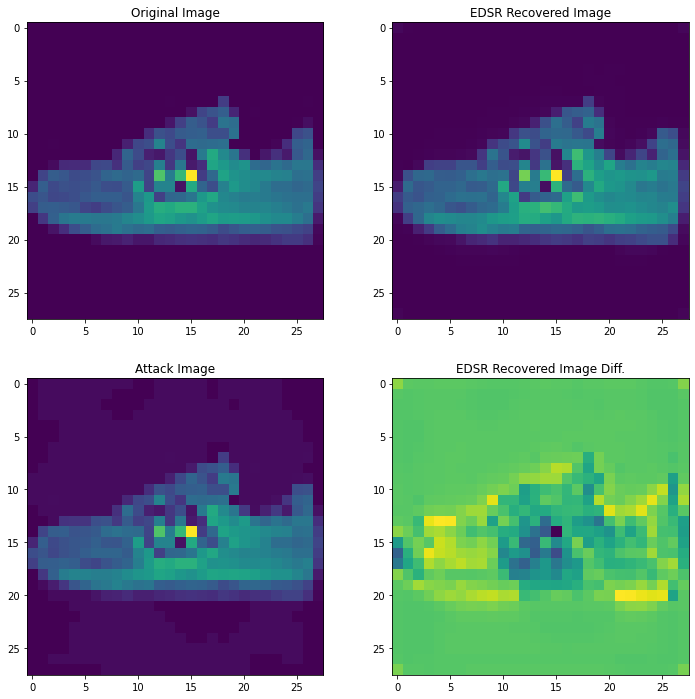

In [ ]:
#@title Plot a Few examples of Gradient Denoising { form-width: "20%" }

idx = 41

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow((grad_attack_transform_im_devset.label[idx]))
print(np.max(grad_attack_transform_im_devset.label[idx]))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((grad_attack_transform_im_devset.data[idx]))
print(np.max(grad_attack_transform_im_devset.data[idx]))

example = torch.from_numpy(grad_attack_transform_im_devset.data[idx])
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("EDSR Recovered Image")
temp = grad_edsr_transform(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][1].imshow(temp)
print(np.max(temp))

ax[1][1].set_title("EDSR Recovered Image Diff.")
ax[1][1].imshow(temp - grad_attack_transform_im_devset.label[idx])
print(np.max(temp - grad_attack_transform_im_devset.label[idx]))

In [ ]:
#@title Test EDSR Gradient Denoiser { form-width: "20%" }

print(f'Baselines - FF: {baseline_ff_transform}, CNN: {baseline_cnn_transform}, Comp.: {baseline_comp_transform}')

print("\nFGSM")
print(f'FF test accuracy: {test(mnist_ff_transform,mnist_ff_fgsm_devloader,denoiser=grad_edsr_transform)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,mnist_cnn_fgsm_devloader,denoiser=grad_edsr_transform)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_transform,mnist_comp_fgsm_devloader,denoiser=grad_edsr_transform)[0]}')

print("\nPGD")
print(f'FF test accuracy: {test(mnist_ff_transform,mnist_ff_pgd_devloader,denoiser=grad_edsr_transform)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,mnist_cnn_pgd_devloader,denoiser=grad_edsr_transform)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_transform,mnist_comp_pgd_devloader,denoiser=grad_edsr_transform)[0]}')

print("\nBIM Undefended")
print(f'FF test accuracy: {test(mnist_ff_transform,mnist_ff_bim_devloader,denoiser=None)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,mnist_cnn_bim_devloader,denoiser=None)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_transform,mnist_comp_bim_devloader,denoiser=None)[0]}')

print("\nBIM")
print(f'FF test accuracy: {test(mnist_ff_transform,mnist_ff_bim_devloader,denoiser=grad_edsr_transform)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,mnist_cnn_bim_devloader,denoiser=grad_edsr_transform)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_transform,mnist_comp_bim_devloader,denoiser=grad_edsr_transform)[0]}')

print("\nShuffled")
print(f'FF test accuracy: {test(mnist_ff_transform,grad_attack_devloader,denoiser=grad_edsr_transform)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,grad_attack_devloader,denoiser=grad_edsr_transform)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_transform,grad_attack_devloader,denoiser=grad_edsr_transform)[0]}')

Baselines - FF: 0.768, CNN: 0.7565, Comp.: 0.8295

FGSM
FF test accuracy: 0.7508333333333334
CNN test accuracy: 0.7375
Composite test accuracy: 0.8241666666666667

PGD
FF test accuracy: 0.6808333333333333
CNN test accuracy: 0.7041666666666667
Composite test accuracy: 0.7283333333333334

BIM Undefended
FF test accuracy: 0.32416666666666666
CNN test accuracy: 0.6075
Composite test accuracy: 0.53

BIM
FF test accuracy: 0.4975
CNN test accuracy: 0.6783333333333333
Composite test accuracy: 0.6925

Shuffled
FF test accuracy: 0.7015740740740741
CNN test accuracy: 0.7013888888888888
Composite test accuracy: 0.7609259259259259


sneaker: 7
1.0
1.0
0.90204024
0.11465071


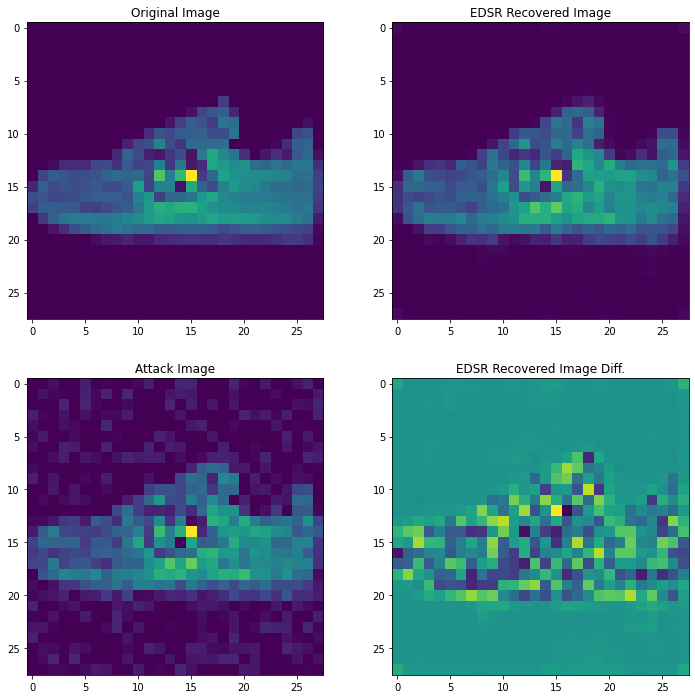

In [ ]:
#@title Plot a Few examples of Rand. Denoising { form-width: "20%" }

idx = 41

print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))

ax[0][0].set_title("Original Image")
ax[0][0].imshow((rand_attack_im_devset.label[idx]))
print(np.max(rand_attack_im_devset.label[idx]))

ax[1][0].set_title("Attack Image")
ax[1][0].imshow((rand_attack_im_devset.data[idx]))
print(np.max(rand_attack_im_devset.data[0]))

example = torch.from_numpy(rand_attack_im_devset.data[idx]).float()
example = torch.unsqueeze(example,0)
example = torch.unsqueeze(example,0)

ax[0][1].set_title("EDSR Recovered Image")
temp = rand_edsr_transform(example.to(device))
temp = temp.to("cpu")
temp = torch.squeeze(temp)
temp = temp.detach().numpy()
ax[0][1].imshow(temp)
print(np.max(temp))

ax[1][1].set_title("EDSR Recovered Image Diff.")
ax[1][1].imshow(temp-rand_attack_im_devset.label[idx])
print(np.max(temp-rand_attack_im_devset.label[idx]))

In [ ]:
#@title Attack with old SimBA { form-width: "20%" }

print(f'FF test accuracy: {test(mnist_ff,mnist_ff_simba_devloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_simba_devloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_simba_devloader)[0]}')

print('\nTransform-trained Classifiers')
print(f'FF test accuracy: {test(mnist_ff_transform,mnist_ff_simba_devloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_transform,mnist_cnn_simba_devloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_transform,mnist_comp_simba_devloader)[0]}')

FF test accuracy: 0.7025
CNN test accuracy: 0.3433333333333333
Composite test accuracy: 0.7041666666666667

Transform-trained Classifiers
FF test accuracy: 0.7058333333333333
CNN test accuracy: 0.7333333333333333
Composite test accuracy: 0.8016666666666666


In [ ]:
#@title Attack with old BIM { form-width: "20%" }

print(f'Baselines - FF: {baseline_ff}, CNN: {baseline_cnn}, Comp.: {baseline_comp}')
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_bim_devloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_bim_devloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_bim_devloader)[0]}')

print('\nTransform-trained Classifiers')
print(f'FF transforms test accuracy: {test(mnist_ff_transform,mnist_ff_bim_devloader)[0]}')
print(f'CNN transforms test accuracy: {test(mnist_cnn_transform,mnist_cnn_bim_devloader)[0]}')
print(f'Composite transforms test accuracy: {test(mnist_comp_transform,mnist_comp_bim_devloader)[0]}')

Baselines - FF: 0.797, CNN: 0.4485, Comp.: 0.7465
FF test accuracy: 0.29333333333333333
CNN test accuracy: 0.15333333333333332
Composite test accuracy: 0.38333333333333336

Transform-trained Classifiers
FF transforms test accuracy: 0.32416666666666666
CNN transforms test accuracy: 0.6075
Composite transforms test accuracy: 0.53


###Train with PGD (Adversary Training)

In [ ]:
#@title Adversary Trainloader Train, test loop { form-width: "20%" }

def train_adver(model, optimizer, trainloader, name, epoch=2,
          loss_fcn=torch.nn.CrossEntropyLoss(),clip=False, 
          plot=False,devloader=None,denoiser=None,adversary=False):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()

  plot_batch = 50 # save plotting data every 50 mini-batches
  print_batch = 4 # print every 4*50 = 200 mini-batches

  iteration_track = []
  devloss_track = []
  devacc_track = []
  batch_count = 0

  running_loss=0
  for ep in range(epoch):
    print_idx = 0
    for i_batch, data in enumerate(trainloader,0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      inputs = inputs.float()

      if (adversary and batch_count%7 == 6):
        inputs = make_grad_attacks('temp', x=inputs.cpu().numpy(), y=labels.cpu().numpy(), 
                                   model=model,loss_fcn = loss_fcn,method ="PGD",
                                   step_size=2.5,chunk=50,epsilon=0.3)
        inputs = torch.from_numpy(inputs).to(device)

      if (len(labels.shape)==3):
        labels = torch.unsqueeze(labels,1)

      if (len(inputs.shape)==3):
        inputs = torch.unsqueeze(inputs,1)

      if (denoiser):
        inputs = denoiser(inputs)

      output = model(inputs)

      loss = loss_fcn(output, labels)
      loss.backward()
      if (clip==True):
        torch.nn.utils.clip_grad_value_(model.parameters(),0.00001)
      optimizer.step()
      
      running_loss += loss.item()
      batch_count+=1
      if i_batch % plot_batch == plot_batch-1:  
        if (print_idx % print_batch == print_batch-1):  
          print('[%d, %5d] loss: %.3f' %
            (ep + 1, i_batch + 1, running_loss / plot_batch))
        print_idx += 1
        running_loss = 0.0
        if (plot):
          iteration_track = np.append(iteration_track,batch_count)
          dev_acc, dev_loss = test(model,devloader,loss_fcn=loss_fcn)
          devacc_track = np.append(devacc_track,dev_acc)
          devloss_track = np.append(devloss_track,dev_loss.cpu())

          model.train()
  if (plot):
    fig,a =  plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    a[0].plot(iteration_track,devacc_track)
    a[0].set_title('Dev. Accuracy')
    a[0].set_xlabel("Total Iterations")
    #a[0].set_ylim([0, 1])
    a[1].plot(iteration_track,devloss_track)
    a[1].set_title('Dev. Loss')
    a[1].set_xlabel("Total Iterations")
    plt.show()

  SAVE_PATH = PATH + name + '.pth'
  torch.save(model.state_dict(), SAVE_PATH)



In [ ]:
#@title Adver. mnist_ff { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_ff_adver = FF(in_flat_dim=28*28*1,up1=3,out_dim=10,h1=1000,h2=100)
mnist_ff_adver.to(device)
optimizer = torch.optim.Adam(mnist_ff_adver.parameters(),lr=0.00001)

SAVE_PATH = PATH + 'mnist_ff_adver.pth'
if os.path.isfile(SAVE_PATH):
  mnist_ff_adver.load_state_dict(torch.load(SAVE_PATH))
else:
  train_adver(mnist_ff_adver,optimizer,mnist_trainloader,"mnist_ff_adver",epoch=30,
        plot=True,devloader=mnist_devloader,adversary=True)

baseline_ff_adver = test(mnist_ff_adver,mnist_testloader)[0]
print(baseline_ff_adver)

print(test(mnist_ff_adver,grad_attack_testloader)[0])

0.843
0.7189444444444445


In [ ]:
#@title Adver. mnist_cnn { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_cnn_adver = CNN(
    up1=3,out_dim=10,chan1=128,chan2=64,chan3=32,k1=17,k2=9,k3=3,p12=2,color=1)
mnist_cnn_adver.to(device)
optimizer = torch.optim.Adam(mnist_cnn_adver.parameters(),lr=0.00001,weight_decay=1e-5)

SAVE_PATH = PATH + 'mnist_cnn_adver.pth'
if os.path.isfile(SAVE_PATH):
  mnist_cnn_adver.load_state_dict(torch.load(SAVE_PATH))
else:
  train_adver(mnist_cnn_adver,optimizer,mnist_trainloader,"mnist_cnn_adver",epoch=30,
        plot=True,devloader=mnist_devloader,adversary=True)

baseline_cnn_adver = test(mnist_cnn_adver,mnist_testloader)[0]
print(baseline_cnn_adver)

print(test(mnist_cnn_adver,grad_attack_testloader)[0])

0.6345
0.5710555555555555


In [ ]:
#@title Adver. object_composite { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_comp_adver = composite(up1=8,out_dim=10,chan1=100,chan2=60,chan3=40,k1=25,k2=17,k3=7,
                   h4=100,h5=100,p12=4,p23=3,color=1)
mnist_comp_adver.to(device)
optimizer = torch.optim.Adam(mnist_comp_adver.parameters(),lr=0.00001)

SAVE_PATH = PATH + 'mnist_comp_adver.pth'
if os.path.isfile(SAVE_PATH):
  mnist_comp_adver.load_state_dict(torch.load(SAVE_PATH))
else:
  train_adver(mnist_comp_adver,optimizer,mnist_trainloader,"mnist_comp_adver",epoch=30,plot=True,
        devloader=mnist_devloader,adversary=True)

baseline_comp_adver = test(mnist_comp_adver,mnist_testloader)[0]
print(baseline_comp_adver)

print(test(mnist_comp_adver,grad_attack_testloader)[0])

0.806
0.7126666666666667


In [ ]:
#@title Attack with old SimBA { form-width: "20%" }

print('\nTransform-trained Classifiers')
print(f'FF test accuracy: {test(mnist_ff_adver,mnist_ff_simba_devloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn_adver,mnist_cnn_simba_devloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp_adver,mnist_comp_simba_devloader)[0]}')


Transform-trained Classifiers
FF test accuracy: 0.7516666666666667
CNN test accuracy: 0.61
Composite test accuracy: 0.7708333333333334


In [ ]:
#@title Attack with old BIM { form-width: "20%" }

print('\nTransform-trained Classifiers')
print(f'FF transforms test accuracy: {test(mnist_ff_adver,mnist_ff_bim_devloader)[0]}')
print(f'CNN transforms test accuracy: {test(mnist_cnn_adver,mnist_cnn_bim_devloader)[0]}')
print(f'Composite transforms test accuracy: {test(mnist_comp_adver,mnist_comp_bim_devloader)[0]}')


Transform-trained Classifiers
FF transforms test accuracy: 0.33
CNN transforms test accuracy: 0.5216666666666666
Composite transforms test accuracy: 0.57


In [ ]:
#@title Attack with Image Transforms { form-width: "20%" }

print('\nTransform-trained Classifiers')
print(f'FF transforms test accuracy: {test(mnist_ff_adver,transform_attack_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(mnist_cnn_adver,transform_attack_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(mnist_comp_adver,transform_attack_testloader)[0]}')


Transform-trained Classifiers
FF transforms test accuracy: 0.5361428571428571
CNN transforms test accuracy: 0.48764285714285716
Composite transforms test accuracy: 0.5925714285714285


## SPIE-D

Informed by intermediate evaluation results a full defense pipeline that utilizes the trained adversarial detector along with the gradient, random, and blur denoisers was assembled. The architecture of the denoiser is shown below. Both ones-hot and weighted recombination strategies were evaluated.

Generally very little difference was acutally noticed between the two strategies due to the generally high confidence of the adversary detector. One-hot results are reported under ["Results"](#scrollTo=pBo-QnVteDpn).

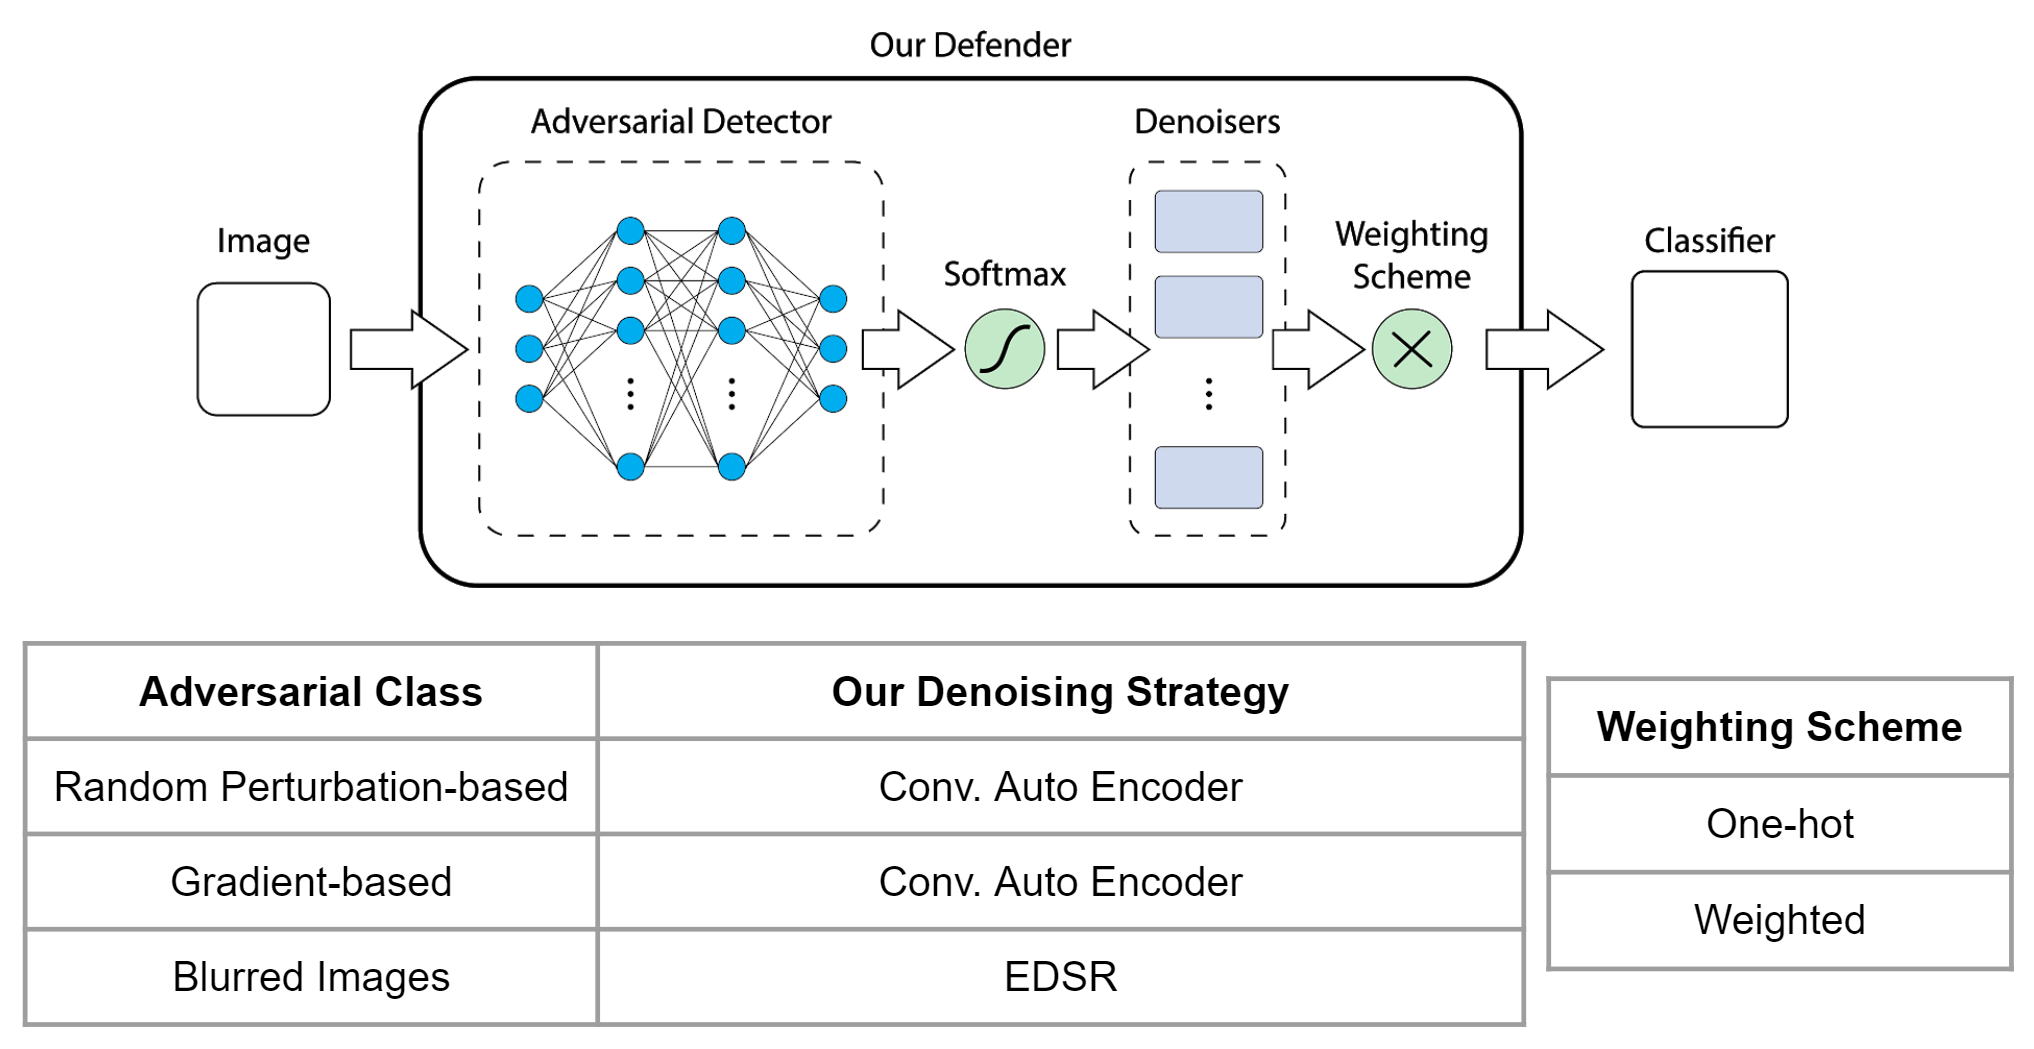

In [ ]:
#@title Linker

## Ready for Annie (NOT YET)
# grad_edsr_transform
# rand_edsr_transform
# blur_edsr_transform

# mnist_ff_transform  # Trained with transforms
# mnist_cnn_transform
# mnist_comp_transform

# grad_attack_transform_testloader
# rand_attack_transform_testloader
# blur_transform_testloader
# transform_attack_testloader

## Run with test-sets ([insert name here])
# mnist_test
## Annie 
#denoiser_dict = {0: noattack, 1: grad_edsr_transform, 2: rand_edsr_transform, 3: blur_edsr_transform}
def denoiser_linker(input, images, encoding_method, denoiser_dict):
  # input = softmax prob from the adversarial detector 
  #denoiser_dict = {0: noattack, 1: grad_edsr_transform, 2: rand_edsr_transform, 3: blur_edsr_transform}
  if encoding_method == 'one_hot':
    k = torch.argmax(input, 1)
    k = k.detach().cpu().numpy()
    #print(type(k))
    denoised_images = torch.empty((len(k), 1, 28, 28))
    #denoised_image = torch.empty()
    for i in range(len(k)):
      image = images[i, :, :, :].reshape((1, 1, 28, 28))
      denoiser_func = denoiser_dict[k[i]]
      denoised_image = denoiser_func(image.float())
      denoised_images[i, :, :, :] = denoised_image
    
  elif encoding_method == 'weighted':
    denoised_images = torch.empty((input.shape[0], 1, 28, 28))
    for im in range(input.shape[0]):
      image = images[im, :, :, :].reshape((1, 1, 28, 28))
      denoised_unweighted = {}
      image_sum = torch.zero((1, 1, 28, 28))
      for i in range(len(denoiser_dict.keys())):
        denoiser_func = denoiser_dict[i]
        denoised_unweighted[i] = denoiser_func(image)
        image_sum += denoised_unweighted[i]*input[im, i]
      image_sum = torchvision.transforms.Normalize(image_sum)
      denoised_images[i, :, :, :] = image_sum
    
  return denoised_images

def noattack(images):
  return images 




In [ ]:
#@title TestPipeline { form-width: "15%" }
def test_pipeline(model, testloader, weight_scheme,trained=True): # Use a loss fcn for dev_set
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    pred_all = []; 
    softmax_all = np.empty((0,10), float)
    misclassified_images = (); 
    if (trained):
      denoiser_dict = {0: noattack, 1: grad_edsr_transform, 2: rand_edsr_transform, 3: blur_edsr_transform}
    else:
      denoiser_dict = {0: noattack, 1: grad_denoiser_conv, 2: rand_denoiser_conv, 3: blur_edsr_transform}
    with torch.no_grad():
        for data in testloader:
          inputs, labels = data
          try:
            inputs, labels = inputs.to(device), labels.to(device)
          except:
            print("Found String in Data")
            continue
          if (len(labels.shape)==3):
            labels = torch.unsqueeze(labels,1)
          if (len(inputs.shape)==3):
            inputs = torch.unsqueeze(inputs,1)
          
          # Adversarial detector 
          score = detector(inputs.float())
          score = torch.nn.functional.softmax(score, dim=1)
          if (weight_scheme=='one_hot'):
            output_denoised = denoiser_linker(score, inputs, weight_scheme, denoiser_dict)
            output_denoised = output_denoised.to(device)
  
            output = model(output_denoised.float())

          else:
            output_ensemble = torch.zeros((inputs.shape[0],10)).to(device)
            output_denoised = (); 
            for idx in range(4):
              denoiser_fcn = denoiser_dict[idx]
              output_denoised += (denoiser_fcn(inputs.float()).cpu().detach().numpy(),)
              try:
                denoiser_fcn=denoiser_fcn.to(device)
              except:
                denoiser_fcn = denoiser_fcn  
              
              output_ensemble += torch.unsqueeze(score[:,idx],-1) * model(denoiser_fcn(inputs.float()))
            output = output_ensemble

          if (len(output.shape)<2):
            output = torch.unsqueeze(output,0)
          _, pred = torch.max(output.data, 1)
          softmax_score = torch.nn.functional.softmax(output, dim=1)
          pred_all.append(pred.detach().cpu().numpy())

          softmax_all = np.append(softmax_all, softmax_score.cpu().detach().numpy(), axis=0)
          #print(pred.detach().cpu().numpy())
          #print(labels.detach().cpu().numpy())
          #print(pred.detach().cpu().numpy() == labels.detach().cpu().numpy())
          misclassified_ex_loc = np.where((pred.detach().cpu().numpy() == labels.detach().cpu().numpy()) == False)[0][0]
          #print(misclassified_ex_loc)
          total += labels.size(0)
          correct += (pred == labels).sum().item()
          score_detect = score[misclassified_ex_loc, :]
          act_label = labels[misclassified_ex_loc]
          pred_label = pred[misclassified_ex_loc]
          #print(inputs.shape)
          #print(output_ensemble.shape)
          if (weight_scheme=='one_hot'):
            misclassified_ex = ((inputs[misclassified_ex_loc], output_denoised[misclassified_ex_loc], score_detect, act_label, pred_label),)
          else:
            misclass_denoised_0 = output_denoised[0][misclassified_ex_loc]
            misclass_denoised_1 = output_denoised[1][misclassified_ex_loc]
            misclass_denoised_2 = output_denoised[2][misclassified_ex_loc]
            misclass_denoised_3 = output_denoised[3][misclassified_ex_loc]
            misclass_denoised_all = ((misclass_denoised_0,), (misclass_denoised_1, ), (misclass_denoised_2, ), (misclass_denoised_3, ))
            misclassified_ex = ((inputs[misclassified_ex_loc], misclass_denoised_all, score_detect, act_label, pred_label),)
          misclassified_images += misclassified_ex

    return pred_all, softmax_all, (correct/total), misclassified_images


In [ ]:
#@title Plug-in SPIE-D-baselines
'''
prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')
'''
prediction, softmax_score, acc, misclass_ex_ff_plug = test_pipeline(mnist_ff, 
                      mnist_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug = test_pipeline(mnist_cnn, 
                      mnist_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug = test_pipeline(mnist_comp, 
                      mnist_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_plug_weighted = test_pipeline(mnist_ff, 
                      mnist_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_weighted = test_pipeline(mnist_cnn, 
                      mnist_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_weighted = test_pipeline(mnist_comp, 
                      mnist_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')

FF test accuracy: 0.7925
CNN test accuracy: 0.4515
Comp. test accuracy: 0.745
FF test accuracy: 0.7885
CNN test accuracy: 0.4515
Comp. test accuracy: 0.7425


In [ ]:
#@title Plug-in SPIE-D-transforms
'''
prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      transform_attack_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      transform_attack_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      transform_attack_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      transform_attack_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      transform_attack_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      transform_attack_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')
'''

prediction, softmax_score, acc, misclass_ex_ff_plug_att = test_pipeline(mnist_ff, 
                      transform_attack_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_att = test_pipeline(mnist_cnn, 
                      transform_attack_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_att = test_pipeline(mnist_comp, 
                      transform_attack_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_plug_weighted_att = test_pipeline(mnist_ff, 
                      transform_attack_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_weighted_att = test_pipeline(mnist_cnn, 
                      transform_attack_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_weighted_att = test_pipeline(mnist_comp, 
                      transform_attack_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')

FF test accuracy: 0.5252142857142857
CNN test accuracy: 0.3399285714285714
Comp. test accuracy: 0.5611428571428572
FF test accuracy: 0.5262142857142857
CNN test accuracy: 0.3419285714285714
Comp. test accuracy: 0.5597857142857143


In [ ]:
#@title Plug-in SPIE-D-Random Permutations

'''
prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_rp_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_rp_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_rp_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_rp_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_rp_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_rp_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')
'''

prediction, softmax_score, acc, misclass_ex_ff_plug_rp = test_pipeline(mnist_ff, 
                      mnist_rp_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_rp = test_pipeline(mnist_cnn, 
                      mnist_rp_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_rp = test_pipeline(mnist_comp, 
                      mnist_rp_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_plug_weighted_rp = test_pipeline(mnist_ff, 
                      mnist_rp_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_weighted_rp = test_pipeline(mnist_cnn, 
                      mnist_rp_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_weighted_rp = test_pipeline(mnist_comp, 
                      mnist_rp_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')



FF test accuracy: 0.753
CNN test accuracy: 0.4385
Comp. test accuracy: 0.6845
FF test accuracy: 0.7535
CNN test accuracy: 0.439
Comp. test accuracy: 0.685


In [ ]:
#@title Plug-in SPIE-D-SimBA

'''
prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_ff_simba_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_cnn_simba_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_comp_simba_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_ff_simba_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_cnn_simba_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_comp_simba_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')
'''

prediction, softmax_score, acc, misclass_ex_ff_plug_simba = test_pipeline(mnist_ff, 
                      mnist_ff_simba_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_simba = test_pipeline(mnist_cnn, 
                      mnist_cnn_simba_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_simba = test_pipeline(mnist_comp, 
                      mnist_comp_simba_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_plug_weighted_simba = test_pipeline(mnist_ff, 
                      mnist_ff_simba_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_weighted_simba = test_pipeline(mnist_cnn, 
                      mnist_cnn_simba_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_weighted_simba = test_pipeline(mnist_comp, 
                      mnist_comp_simba_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')


FF test accuracy: 0.6455
CNN test accuracy: 0.377
Comp. test accuracy: 0.642
FF test accuracy: 0.645
CNN test accuracy: 0.376
Comp. test accuracy: 0.6425


In [ ]:
#@title Plug-in SPIE-D-FGSM

'''
prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_ff_fgsm_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_cnn_fgsm_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_comp_fgsm_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_ff_fgsm_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_cnn_fgsm_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_comp_fgsm_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')
'''

prediction, softmax_score, acc, misclass_ex_ff_plug_fgsm = test_pipeline(mnist_ff, 
                      mnist_ff_fgsm_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_fgsm = test_pipeline(mnist_cnn, 
                      mnist_cnn_fgsm_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_fgsm = test_pipeline(mnist_comp, 
                      mnist_comp_fgsm_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_plug_weighted_fgsm = test_pipeline(mnist_ff, 
                      mnist_ff_fgsm_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_weighted_fgsm = test_pipeline(mnist_cnn, 
                      mnist_cnn_fgsm_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_weighted_fgsm = test_pipeline(mnist_comp, 
                      mnist_comp_fgsm_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')



FF test accuracy: 0.716
CNN test accuracy: 0.4215
Comp. test accuracy: 0.6835
FF test accuracy: 0.716
CNN test accuracy: 0.423
Comp. test accuracy: 0.683


In [ ]:
#@title Plug-in SPIE-D-PGD

'''
prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_ff_pgd_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_cnn_pgd_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_comp_pgd_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_ff_pgd_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_cnn_pgd_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_comp_pgd_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')
'''

prediction, softmax_score, acc, misclass_ex_ff_plug_pgd = test_pipeline(mnist_ff, 
                      mnist_ff_pgd_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_pgd = test_pipeline(mnist_cnn, 
                      mnist_cnn_pgd_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_pgd = test_pipeline(mnist_comp, 
                      mnist_comp_pgd_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_plug_weighted_pgd = test_pipeline(mnist_ff, 
                      mnist_ff_pgd_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_weighted_pgd = test_pipeline(mnist_cnn, 
                      mnist_cnn_pgd_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_weighted_pgd = test_pipeline(mnist_comp, 
                      mnist_comp_pgd_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')



FF test accuracy: 0.611
CNN test accuracy: 0.3255
Comp. test accuracy: 0.613
FF test accuracy: 0.619
CNN test accuracy: 0.3265
Comp. test accuracy: 0.61


In [ ]:
#@title Plug-in SPIE-D-BIM

'''
prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_ff_bim_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_cnn_bim_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_comp_bim_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_ff, 
                      mnist_ff_bim_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_cnn, 
                      mnist_cnn_bim_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc = test_pipeline(mnist_comp, 
                      mnist_comp_bim_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')
'''

prediction, softmax_score, acc, misclass_ex_ff_plug_bim = test_pipeline(mnist_ff, 
                      mnist_ff_bim_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_bim = test_pipeline(mnist_cnn, 
                      mnist_cnn_bim_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_bim = test_pipeline(mnist_comp, 
                      mnist_comp_bim_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_plug_weighted_bim = test_pipeline(mnist_ff, 
                      mnist_ff_bim_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_plug_weighted_bim = test_pipeline(mnist_cnn, 
                      mnist_cnn_bim_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_plug_weighted_bim = test_pipeline(mnist_comp, 
                      mnist_comp_bim_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')


FF test accuracy: 0.482
CNN test accuracy: 0.3055
Comp. test accuracy: 0.5745
FF test accuracy: 0.463
CNN test accuracy: 0.281
Comp. test accuracy: 0.5575


In [ ]:
#@title Re-Trained, Defeneded-baseline

acc = test(mnist_ff_transform, mnist_testloader)[0]
print(f'FF test accuracy: {acc}')

acc = test(mnist_cnn_transform,mnist_testloader)[0]
print(f'CNN test accuracy: {acc}')

acc = test(mnist_comp_transform,mnist_testloader)[0]
print(f'Comp test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans = test_pipeline(mnist_ff_transform, 
                      mnist_testloader,weight_scheme='one_hot')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans = test_pipeline(mnist_cnn_transform, 
                      mnist_testloader,weight_scheme='one_hot')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans = test_pipeline(mnist_comp_transform, 
                      mnist_testloader,weight_scheme='one_hot')
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_weighted = test_pipeline(mnist_ff_transform, 
                      mnist_testloader,weight_scheme='weighted')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_weighted = test_pipeline(mnist_cnn_transform, 
                      mnist_testloader,weight_scheme='weighted')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_weighted = test_pipeline(mnist_comp_transform, 
                      mnist_testloader,weight_scheme='weighted')
print(f'Comp. test accuracy: {acc}')

FF test accuracy: 0.768
CNN test accuracy: 0.7565
Comp test accuracy: 0.8295
FF test accuracy: 0.7665
CNN test accuracy: 0.7565
Comp. test accuracy: 0.831
FF test accuracy: 0.7675
CNN test accuracy: 0.7525
Comp. test accuracy: 0.83


In [ ]:
#@title Re-Trained, Defeneded-transforms
acc = test(mnist_ff_transform, transform_attack_testloader)[0]
print(f'FF test accuracy: {acc}')

acc = test(mnist_cnn_transform,transform_attack_testloader)[0]
print(f'CNN test accuracy: {acc}')

acc = test(mnist_comp_transform,transform_attack_testloader)[0]
print(f'Comp test accuracy: {acc}')

print(f'Baselines - FF: {baseline_ff}, CNN: {baseline_cnn}, Comp.: {baseline_comp}')

prediction, softmax_score, acc, misclass_ex_ff_trans_att = test_pipeline(mnist_ff_transform, 
                      transform_attack_testloader,weight_scheme='one_hot')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_att = test_pipeline(mnist_cnn_transform, 
                      transform_attack_testloader,weight_scheme='one_hot')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_att = test_pipeline(mnist_comp_transform, 
                      transform_attack_testloader,weight_scheme='one_hot')
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_weighted_att = test_pipeline(mnist_ff_transform, 
                      transform_attack_testloader,weight_scheme='weighted')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_weighted_att = test_pipeline(mnist_cnn_transform, 
                      transform_attack_testloader,weight_scheme='weighted')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_weighted_att = test_pipeline(mnist_comp_transform, 
                      transform_attack_testloader,weight_scheme='weighted')
print(f'Comp. test accuracy: {acc}')

FF test accuracy: 0.6155714285714285
CNN test accuracy: 0.6532857142857142
Comp test accuracy: 0.7503571428571428
Baselines - FF: 0.797, CNN: 0.4485, Comp.: 0.7465
FF test accuracy: 0.6148571428571429
CNN test accuracy: 0.6521428571428571
Comp. test accuracy: 0.7484285714285714
FF test accuracy: 0.6155
CNN test accuracy: 0.6467857142857143
Comp. test accuracy: 0.7487857142857143


In [ ]:
#@title Re-Trained, Defeneded-Random Permutations
acc = test(mnist_ff_transform, mnist_rp_testloader)[0]
print(f'FF test accuracy: {acc}')

acc = test(mnist_cnn_transform,mnist_rp_testloader)[0]
print(f'CNN test accuracy: {acc}')

acc = test(mnist_comp_transform,mnist_rp_testloader)[0]
print(f'Comp test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_rp = test_pipeline(mnist_ff_transform, 
                      mnist_rp_testloader,weight_scheme='one-hot')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_rp = test_pipeline(mnist_cnn_transform, 
                      mnist_rp_testloader,weight_scheme='one-hot')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_rp = test_pipeline(mnist_comp_transform, 
                      mnist_rp_testloader,weight_scheme='one-hot')
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_weighted_rp = test_pipeline(mnist_ff_transform, 
                      mnist_rp_testloader,weight_scheme='weighted')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_weighted_rp = test_pipeline(mnist_cnn_transform, 
                      mnist_rp_testloader,weight_scheme='weighted')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_weighted_rp = test_pipeline(mnist_comp_transform, 
                      mnist_rp_testloader,weight_scheme='weighted')
print(f'Comp. test accuracy: {acc}')

FF test accuracy: 0.7545
CNN test accuracy: 0.7115
Comp test accuracy: 0.8015
FF test accuracy: 0.7635
CNN test accuracy: 0.7275
Comp. test accuracy: 0.8135
FF test accuracy: 0.7635
CNN test accuracy: 0.7275
Comp. test accuracy: 0.8135


In [ ]:
#@title Re-Trained, Defeneded-SimBA
acc = test(mnist_ff_transform,mnist_ff_transform_simba_testloader)[0]
print(f'FF test accuracy: {acc}')

acc = test(mnist_cnn_transform,mnist_cnn_transform_simba_testloader)[0]
print(f'CNN test accuracy: {acc}')

acc = test(mnist_comp_transform,mnist_comp_transform_simba_testloader)[0]
print(f'Comp test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_simba = test_pipeline(mnist_ff_transform, 
                      mnist_ff_transform_simba_testloader,weight_scheme='one_hot')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_simba = test_pipeline(mnist_cnn_transform, 
                      mnist_cnn_transform_simba_testloader,weight_scheme='one_hot')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_simba = test_pipeline(mnist_comp_transform, 
                      mnist_comp_transform_simba_testloader,weight_scheme='one_hot')
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_weighted_simba = test_pipeline(mnist_ff_transform, 
                      mnist_ff_transform_simba_testloader,weight_scheme='weighted')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_weighted_simba = test_pipeline(mnist_cnn_transform, 
                      mnist_cnn_transform_simba_testloader,weight_scheme='weighted')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_weighted_simba = test_pipeline(mnist_comp_transform, 
                      mnist_comp_transform_simba_testloader,weight_scheme='weighted')
print(f'Comp. test accuracy: {acc}')

FF test accuracy: 0.667
CNN test accuracy: 0.6935
Comp test accuracy: 0.6285
Baselines - FF: 0.797, CNN: 0.4485, Comp.: 0.7465
FF test accuracy: 0.697
CNN test accuracy: 0.7095
Comp. test accuracy: 0.6975
FF test accuracy: 0.6975
CNN test accuracy: 0.7
Comp. test accuracy: 0.6935


In [ ]:
#@title Re-Trained, Defeneded-FGSM
acc = test(mnist_ff_transform,mnist_ff_transform_fgsm_testloader)[0]
print(f'FF test accuracy: {acc}')

acc = test(mnist_cnn_transform,mnist_cnn_transform_fgsm_testloader)[0]
print(f'CNN test accuracy: {acc}')

acc = test(mnist_comp_transform,mnist_comp_transform_fgsm_testloader)[0]
print(f'Comp test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_fgsm = test_pipeline(mnist_ff_transform, 
                      mnist_ff_transform_fgsm_testloader,weight_scheme='one_hot')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_fgsm = test_pipeline(mnist_cnn_transform, 
                      mnist_cnn_transform_fgsm_testloader,weight_scheme='one_hot')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_fgsm = test_pipeline(mnist_comp_transform, 
                      mnist_comp_transform_fgsm_testloader,weight_scheme='one_hot')
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_weighted_fgsm = test_pipeline(mnist_ff_transform, 
                      mnist_ff_transform_fgsm_testloader,weight_scheme='weighted')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_weighted_fgsm = test_pipeline(mnist_cnn_transform, 
                      mnist_cnn_transform_fgsm_testloader,weight_scheme='weighted')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_weighted_fgsm = test_pipeline(mnist_comp_transform, 
                      mnist_comp_transform_fgsm_testloader,weight_scheme='weighted')
print(f'Comp. test accuracy: {acc}')

FF test accuracy: 0.684
CNN test accuracy: 0.7295
Comp test accuracy: 0.8035
FF test accuracy: 0.7405
CNN test accuracy: 0.7455
Comp. test accuracy: 0.816
FF test accuracy: 0.7395
CNN test accuracy: 0.738
Comp. test accuracy: 0.8165


In [ ]:
#@title Re-Trained, Defeneded-PGD

acc = test(mnist_ff_transform,mnist_ff_transform_pgd_testloader)[0]
print(f'FF test accuracy: {acc}')

acc = test(mnist_cnn_transform,mnist_cnn_transform_pgd_testloader)[0]
print(f'CNN test accuracy: {acc}')

acc = test(mnist_comp_transform,mnist_comp_transform_pgd_testloader)[0]
print(f'Comp test accuracy: {acc}')


prediction, softmax_score, acc, misclass_ex_ff_trans_pgd = test_pipeline(mnist_ff_transform, 
                      mnist_ff_transform_pgd_testloader,weight_scheme='one_hot')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_pgd = test_pipeline(mnist_cnn_transform, 
                      mnist_cnn_transform_pgd_testloader,weight_scheme='one_hot')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_pgd= test_pipeline(mnist_comp_transform, 
                      mnist_comp_transform_pgd_testloader,weight_scheme='one_hot')
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_weighted_pgd = test_pipeline(mnist_ff_transform, 
                      mnist_ff_transform_pgd_testloader,weight_scheme='weighted')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_weighted_pgd = test_pipeline(mnist_cnn_transform, 
                      mnist_cnn_transform_pgd_testloader,weight_scheme='weighted')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_weighted_pgd = test_pipeline(mnist_comp_transform, 
                      mnist_comp_transform_pgd_testloader,weight_scheme='weighted')
print(f'Comp. test accuracy: {acc}')

#prediction, softmax_score, acc = test_pipeline(mnist_ff_transform, 
#                      mnist_ff_transform_bim_testloader,weight_scheme='one_hot')
#print(f'FF test accuracy: {acc}')

FF test accuracy: 0.505
CNN test accuracy: 0.6655
Comp test accuracy: 0.6285
FF test accuracy: 0.55
CNN test accuracy: 0.693
Comp. test accuracy: 0.6975
FF test accuracy: 0.552
CNN test accuracy: 0.6845
Comp. test accuracy: 0.6935


In [ ]:
#@title Re-Trained, Defeneded-BIM
acc = test(mnist_ff_transform,mnist_ff_transform_bim_testloader)[0]
print(f'FF test accuracy: {acc}')

acc = test(mnist_cnn_transform,mnist_cnn_transform_bim_testloader)[0]
print(f'CNN test accuracy: {acc}')

acc = test(mnist_comp_transform,mnist_comp_transform_bim_testloader)[0]
print(f'Comp test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_bim = test_pipeline(mnist_ff_transform, 
                      mnist_ff_transform_bim_testloader,weight_scheme='one_hot')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_bim = test_pipeline(mnist_cnn_transform, 
                      mnist_cnn_transform_bim_testloader,weight_scheme='one_hot')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_bim = test_pipeline(mnist_comp_transform, 
                      mnist_comp_transform_bim_testloader,weight_scheme='one_hot')
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_ff_trans_weighted_bim = test_pipeline(mnist_ff_transform, 
                      mnist_ff_transform_bim_testloader,weight_scheme='weighted')
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_cnn_trans_weighted_bim = test_pipeline(mnist_cnn_transform, 
                      mnist_cnn_transform_bim_testloader,weight_scheme='weighted')
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, misclass_ex_comp_trans_weighted_bim = test_pipeline(mnist_comp_transform, 
                      mnist_comp_transform_bim_testloader,weight_scheme='weighted')
print(f'Comp. test accuracy: {acc}')

FF test accuracy: 0.21
CNN test accuracy: 0.195
Comp test accuracy: 0.126
FF test accuracy: 0.3975
CNN test accuracy: 0.417
Comp. test accuracy: 0.3185
FF test accuracy: 0.372
CNN test accuracy: 0.396
Comp. test accuracy: 0.2815


##RAIN

RAIN is a data pre-processing pipeline. The idea is to remove adversarial information through random sampling and shifting. Finally a a combination of bilinear interpolation and an EDSR model is used to return the image to its original resoltion. A key point of RAIN is that strong spatially invariant classifiers such as CNNs need no retraining. However, due to the vast differences between F-MNIST and the original Image Net utilized by [7] poor results were achieved and a new set of classifiers were trained on the images reconstructed by EDSR. Visualization within.

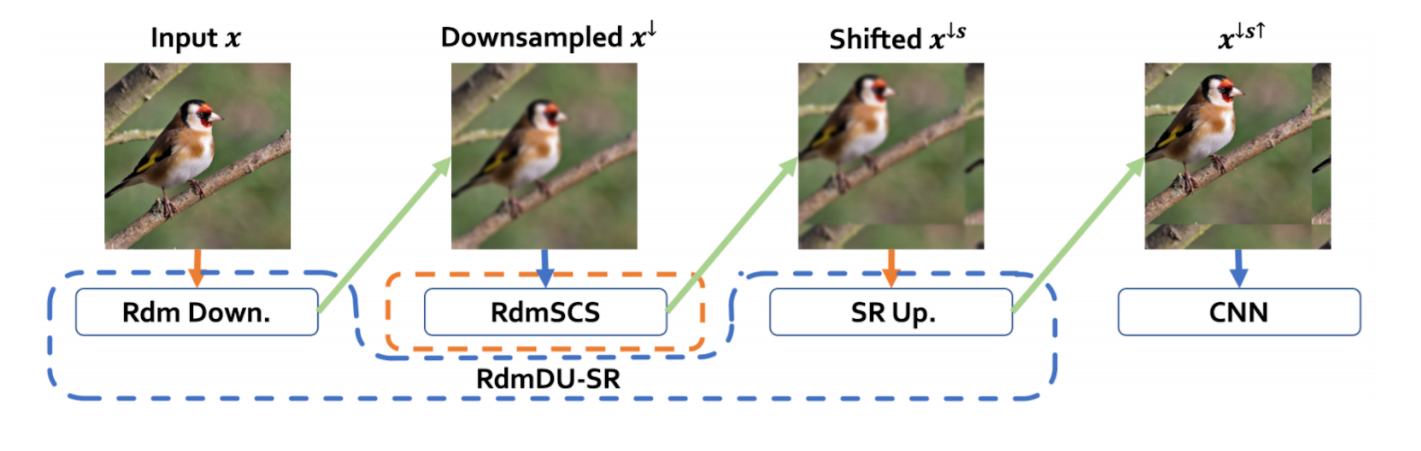

In [ ]:
#@title RDM_DS
def rdm_down(x):
  index_temp = int(np.floor((x[0].shape[0])/2))
  x_down = np.zeros((1,index_temp,index_temp))
  odd_set = 2*np.arange(index_temp) + 1
  if (odd_set[-1]>x[0].shape[0]-1):
    odd_set = odd_set[:-1]
  even_set = 2*np.arange(int(np.floor((x[0].shape[0])/2)))
  for im in x:
    if (rn.uniform(0,1)>0.5):
      temp = im[odd_set,:]
      temp = temp[:,odd_set]
    else:
      temp = im[even_set,:]
      temp = temp[:,even_set]
    temp = np.expand_dims(temp, axis=0)
    x_down = np.append(x_down,temp,axis=0)
  return x_down[1:]

In [ ]:
#@title RDM_CS
def rdm_shift(x,x2):
  x_shift = np.zeros((1,x[0].shape[0],x[0].shape[1]))
  x_orig_shift = np.zeros((1,x2[0].shape[0],x2[0].shape[1]))
  for im,orig in zip(x,x2):
    rand1 = rn.randint(1,3)
    rand2 = rn.randint(1,3)
    temp = np.roll(im,rand1,axis=0)
    temp = np.roll(temp,rand2,axis=1)
    temp = np.expand_dims(temp, axis=0)
    x_shift = np.append(x_shift,temp,axis=0)
    
    temp = np.roll(orig,2*rand1,axis=0)
    temp = np.roll(temp,2*rand2,axis=1)
    temp = np.expand_dims(temp,axis=0)
    x_orig_shift = np.append(x_orig_shift,temp,axis=0)
  return x_shift[1:], x_orig_shift[1:]

In [ ]:
#@title Upsample
def sr_upsample(x):
  up_samp = transforms.Resize(size=(28,28),interpolation=2)
  super_x = np.zeros((1,28,28))
  temp = torch.from_numpy(x)
  for im in temp:
    im = torch.unsqueeze(im,0)
    temp_im = up_samp(im)
    temp_im = temp_im.numpy()
    super_x = np.append(super_x,temp_im,axis=0)
  return super_x[1:]


In [ ]:
#@title RAIN SR Preprocessing

def rain_sr_batch(model,x,batchsize):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  ims = torch.from_numpy(x).float()
  model.to(device)
  model.eval()
  with torch.no_grad():
    if (len(ims.shape)<4):
      ims = torch.unsqueeze(ims,1)
    ret = torch.zeros_like(ims)
    idx = 0
    while idx<ims.shape[0] :
      im_batch = ims[idx:idx+batchsize,:,:,:].to(device)
      ret[idx:idx+batchsize,:,:,:] = model(im_batch).to("cpu")
      if (idx+batchsize>=ims.shape[0]):
        im_batch = ims[idx:ims.shape[0]-1,:,:,:].to(device)
        ret[idx:ims.shape[0]-1,:,:,:] = model(im_batch).to("cpu")
      idx = idx+batchsize
  return np.squeeze(ret.detach().numpy())

sneaker: 7
RAIN Random Downsample
RAIN Random Shift
RAIN Upsample
Train SR Net


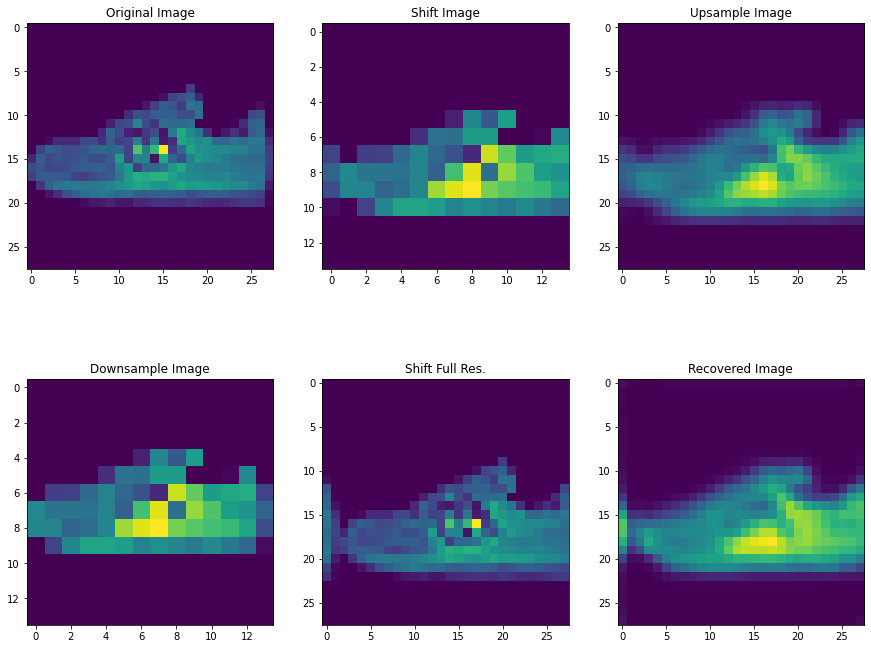

In [ ]:
#@title Visualize and make RAIN_set { form-width: "20%" }
idx = 41
  
rain_sr_net = EDSR(scale=1,n_resblocks=4)
rain_sr_net.to(device)
optimizer = torch.optim.Rprop(rain_sr_net.parameters(),lr=0.000001)
criterion = nn.MSELoss()

SAVE_PATH = PATH + 'PRINT_ALWAYS'
if os.path.isfile(SAVE_PATH):
  SAVE_PATH = PATH + 'rain_sr_net.pth'
  rain_sr_net.load_state_dict(torch.load(SAVE_PATH))

  SAVE_PATH = PATH + 'rain_raw' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    rain_raw = np.load(f) 
  SAVE_PATH = PATH + 'rain_y_raw' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    rain_y_raw = np.load(f) 
  SAVE_PATH = PATH + 'rain_devraw' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    rain_devraw = np.load(f) 
  SAVE_PATH = PATH + 'rain_y_devraw' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    rain_y_devraw = np.load(f) 
  SAVE_PATH = PATH + 'rain_x_test_raw' + '.npy'  
  with open(SAVE_PATH, 'rb') as f:
    rain_x_test_raw = np.load(f) 
  SAVE_PATH = PATH + 'rain_y_test_raw' + '.npy'
  with open(SAVE_PATH, 'rb') as f:
    rain_y_test_raw = np.load(f) 
else:

  print(mnist_classes[mnist_y["dev"][idx]] + ": " + str(mnist_y["dev"][idx]))
  fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,12))
  
  ax[0][0].set_title("Original Image")
  ax[0][0].imshow((mnist_x["dev"][idx]))

  temp_orig = (mnist_x["train"])
  temp_rand = (rand_attack_x_train_raw[1*mnist_x["train"].shape[0]:])
  temp_grad = (grad_attack_x_train_raw[6*mnist_x["train"].shape[0]:])
  temp_tran = (transform_attack_x_train_raw)

  temp_orig = temp_orig
  temp_rand = temp_rand[0::3]
  temp_grad = temp_grad[0::3]
  temp_tran = temp_tran[0::7]

  rain_x_raw = [temp_orig, temp_rand, temp_grad, temp_tran]
  rain_x_raw = np.vstack(rain_x_raw)
  #print("x_raw: " + str(rain_x_raw.shape))

  temp_orig = (mnist_y["train"])
  temp_rand = (rand_attack_y_train_raw[1*mnist_y["train"].shape[0]:])
  temp_grad = (grad_attack_y_train_raw[6*mnist_y["train"].shape[0]:])
  temp_tran = (transform_attack_y_train_raw)

  temp_orig = temp_orig
  temp_rand = temp_rand[0::3]
  temp_grad = temp_grad[0::3]
  temp_tran = temp_tran[0::7]

  rain_y_raw = [temp_orig, temp_rand, temp_grad, temp_tran]
  rain_y_raw = np.hstack(rain_y_raw)
  #print("y_raw" + str(rain_y_raw.shape))

  temp_orig = (mnist_x["dev"])
  temp_rand = (rand_attack_x_devraw[1*mnist_x["dev"].shape[0]:])
  temp_grad = (grad_attack_x_devraw[6*mnist_x["dev"].shape[0]:])
  temp_tran = (transform_attack_x_devraw)

  temp_orig = temp_orig
  temp_rand = temp_rand[0::3]
  temp_grad = temp_grad[0::3]
  temp_tran = temp_tran[0::7]

  rain_x_devraw = [temp_orig, temp_rand, temp_grad, temp_tran]
  rain_x_devraw = np.vstack(rain_x_devraw)
  #print("x_devraw: " + str(rain_x_devraw.shape))

  temp_orig = (mnist_y["dev"])
  temp_rand = (rand_attack_y_devraw[1*mnist_y["dev"].shape[0]:])
  temp_grad = (grad_attack_y_devraw[6*mnist_y["dev"].shape[0]:])
  temp_tran = (transform_attack_y_devraw)

  temp_orig = temp_orig
  temp_rand = temp_rand[0::3]
  temp_grad = temp_grad[0::3]
  temp_tran = temp_tran[0::7]

  rain_y_devraw = [temp_orig, temp_rand, temp_grad, temp_tran]
  rain_y_devraw = np.hstack(rain_y_devraw)
  #print("y_devraw: " + str(rain_y_devraw.shape))

  temp_orig = (mnist_x["test"])
  temp_rand = (rand_attack_x_test_raw[1*mnist_x["test"].shape[0]:])
  temp_grad = (grad_attack_x_test_raw[6*mnist_x["test"].shape[0]:])
  temp_tran = (transform_attack_x_test_raw)

  temp_orig = temp_orig
  temp_rand = temp_rand[0::3]
  temp_grad = temp_grad[0::3]
  temp_tran = temp_tran[0::7]

  rain_x_test_raw = [temp_orig, temp_rand, temp_grad, temp_tran]
  rain_x_test_raw = np.vstack(rain_x_test_raw)
  #print("x_test_raw: " + str(rain_x_test_raw.shape))

  temp_orig = (mnist_y["test"])
  temp_rand = (rand_attack_y_test_raw[1*mnist_y["test"].shape[0]:])
  temp_grad = (grad_attack_y_test_raw[6*mnist_y["test"].shape[0]:])
  temp_tran = (transform_attack_y_test_raw)

  temp_orig = temp_orig
  temp_rand = temp_rand[0::3]
  temp_grad = temp_grad[0::3]
  temp_tran = temp_tran[0::7]

  rain_y_test_raw = [temp_orig, temp_rand, temp_grad, temp_tran]
  rain_y_test_raw = np.hstack(rain_y_test_raw)
  #print("y_test_raw: " + str(rain_y_test_raw.shape))

  print("RAIN Random Downsample")

  SAVE_PATH = PATH + 'rain_raw_rdm_down' + '.npy'
  if os.path.isfile(SAVE_PATH):
    with open(SAVE_PATH, 'rb') as f:
      rain_raw = np.load(f)
    SAVE_PATH = PATH + 'rain_devraw_rdm_down' + '.npy'
    with open(SAVE_PATH, 'rb') as f:
      rain_devraw = np.load(f)
  else: 
    rain_raw = rdm_down(rain_x_raw)
    rain_devraw = rdm_down(rain_x_devraw)
    with open(PATH + 'rain_raw_rdm_down' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_raw))
    with open(PATH + 'rain_devraw_rdm_down' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_devraw))

  SAVE_PATH = PATH + 'rain_test_raw_rdm_down' + '.npy'
  if os.path.isfile(SAVE_PATH):
    with open(SAVE_PATH, 'rb') as f:
      rain_test_raw = np.load(f)
  else: 
    rain_test_raw = rdm_down(rain_x_test_raw)
    with open(PATH + 'rain_test_raw_rdm_down' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_test_raw))


  #print("rain_raw: " + str(rain_raw.shape))
  #print("rain_x_raw: " + str(rain_x_raw.shape))
  #print("rain_devraw: " + str(rain_devraw.shape))
  #print("rain_test_raw: " + str(rain_test_raw.shape))

  ax[1][0].set_title("Downsample Image")
  ax[1][0].imshow(rain_devraw[idx])

  print("RAIN Random Shift")

  SAVE_PATH = PATH + 'rain_raw_rdm_shift' + '.npy'
  if os.path.isfile(SAVE_PATH):
    with open(SAVE_PATH, 'rb') as f:
      rain_raw = np.load(f)
    SAVE_PATH = PATH + 'rain_devraw_rdm_shift' + '.npy'
    with open(SAVE_PATH, 'rb') as f:
      rain_devraw = np.load(f)
    SAVE_PATH = PATH + 'rain_im_raw_rdm_shift' + '.npy'
    with open(SAVE_PATH, 'rb') as f:
      rain_im_raw = np.load(f)
    SAVE_PATH = PATH + 'rain_im_devraw_rdm_shift' + '.npy'
    with open(SAVE_PATH, 'rb') as f:
      rain_im_devraw = np.load(f)
  else: 
    rain_raw,rain_im_raw = rdm_shift(rain_raw,rain_x_raw)
    rain_devraw,rain_im_devraw = rdm_shift(rain_devraw,rain_x_devraw)
    with open(PATH + 'rain_raw_rdm_shift' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_raw))
    with open(PATH + 'rain_devraw_rdm_shift' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_devraw))
    with open(PATH + 'rain_im_raw_rdm_shift' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_im_raw))
    with open(PATH + 'rain_im_devraw_rdm_shift' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_im_devraw))

  SAVE_PATH = PATH + 'rain_test_raw_rdm_shift' + '.npy'
  if os.path.isfile(SAVE_PATH):
    with open(SAVE_PATH, 'rb') as f:
      rain_test_raw = np.load(f)
    SAVE_PATH = PATH + 'rain_im_test_raw_rdm_shift' + '.npy'
    with open(SAVE_PATH, 'rb') as f:
      rain_im_test_raw = np.load(f)
  else: 
    rain_test_raw,rain_im_test_raw = rdm_shift(rain_test_raw,rain_x_test_raw)
    with open(PATH + 'rain_test_raw_rdm_shift' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_test_raw))
    with open(PATH + 'rain_im_test_raw_rdm_shift' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_im_test_raw))

  #print("rain_raw: " + str(rain_raw.shape))
  #print("rain_devraw: " + str(rain_devraw.shape))
  #print("rain_im_raw: " + str(rain_im_raw.shape))
  #print("rain_im_devraw: " + str(rain_im_devraw.shape))
  #print("rain_test_raw: " + str(rain_test_raw.shape))
  #print("rain_im_test_raw: " + str(rain_im_test_raw.shape))

  ax[0][1].set_title("Shift Image")
  ax[0][1].imshow(rain_devraw[idx])

  ax[1][1].set_title("Shift Full Res.")
  ax[1][1].imshow(rain_im_devraw[idx])

  print("RAIN Upsample")

  SAVE_PATH = PATH + 'rain_raw_upsample' + '.npy'
  if os.path.isfile(SAVE_PATH):
    with open(SAVE_PATH, 'rb') as f:
      rain_raw = np.load(f)
    SAVE_PATH = PATH + 'rain_devraw_upsample' + '.npy'
    with open(SAVE_PATH, 'rb') as f:
      rain_devraw = np.load(f)
  else: 
    rain_raw = sr_upsample(rain_raw)
    rain_devraw = sr_upsample(rain_devraw)
    with open(PATH + 'rain_raw_upsample' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_raw))
    with open(PATH + 'rain_devraw_upsample' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_devraw))

  SAVE_PATH = PATH + 'rain_test_raw_upsample' + '.npy'
  if os.path.isfile(SAVE_PATH):
    with open(SAVE_PATH, 'rb') as f:
      rain_test_raw = np.load(f)
  else: 
    rain_test_raw = sr_upsample(rain_test_raw)
    with open(PATH + 'rain_test_raw_upsample' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_test_raw))

  #print("rain_raw: " + str(rain_raw.shape))
  #print("rain_devraw: " + str(rain_devraw.shape))
  #print("rain_test_raw: " + str(rain_test_raw.shape))

  ax[0][2].set_title("Upsample Image")
  ax[0][2].imshow(rain_devraw[idx])

  print("Train SR Net")
  #print(rain_im_raw.shape)
  #print(rain_im_devraw.shape)

  rain_im_raw = rain_im_raw.astype(np.float32)
  rain_sr_trainset = ImageDataset(rain_raw,rain_im_raw)
  rain_sr_trainloader = DataLoader(rain_sr_trainset,10,shuffle=True)

  rain_im_devraw = rain_im_devraw.astype(np.float32)
  rain_sr_devset = ImageDataset(rain_devraw,rain_im_devraw)
  rain_sr_devloader = DataLoader(rain_sr_devset,10,shuffle=True)

  SAVE_PATH = PATH + 'rain_sr_net.pth'
  if os.path.isfile(SAVE_PATH):
    rain_sr_net.load_state_dict(torch.load(SAVE_PATH))
  else:
    train(rain_sr_net,optimizer,rain_sr_trainloader,"rain_sr_net",epoch=50,
        loss_fcn=criterion,clip=True,plot=True,devloader=rain_sr_devloader)

  SAVE_PATH = PATH + 'rain_raw_sr_upsample' + '.npy'
  if os.path.isfile(SAVE_PATH):
    with open(SAVE_PATH, 'rb') as f:
      rain_raw = np.load(f)
    SAVE_PATH = PATH + 'rain_devraw_sr_upsample' + '.npy'
    with open(SAVE_PATH, 'rb') as f:
      rain_devraw = np.load(f)
  else: 
    rain_raw = rain_sr_batch(rain_sr_net,rain_raw,50)
    rain_devraw = rain_sr_batch(rain_sr_net,rain_devraw,50)
    with open(PATH + 'rain_raw_sr_upsample' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_raw))
    with open(PATH + 'rain_devraw_sr_upsample' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_devraw))

  SAVE_PATH = PATH + 'rain_test_raw_sr_upsample' + '.npy'
  if os.path.isfile(SAVE_PATH):
    with open(SAVE_PATH, 'rb') as f:
      rain_test_raw = np.load(f)
  else: 
    rain_test_raw = rain_sr_batch(rain_sr_net,rain_test_raw,50)
    with open(PATH + 'rain_test_raw_sr_upsample' + '.npy', 'wb') as f:
      np.save(f, np.array(rain_test_raw))

  #print("rain_raw: " + str(rain_raw.shape))
  #print("rain_devraw: " + str(rain_devraw.shape))
  #print("rain_test_raw: " + str(rain_test_raw.shape))

  ax[1][2].set_title("Recovered Image")
  ax[1][2].imshow(rain_devraw[idx])

  with open(PATH + 'rain_raw' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_raw))
  with open(PATH + 'rain_y_raw' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_y_raw))
  with open(PATH + 'rain_devraw' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_devraw))
  with open(PATH + 'rain_y_devraw' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_y_devraw))  
  with open(PATH + 'rain_x_test_raw' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_raw))
  with open(PATH + 'rain_y_test_raw' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_y_test_raw))  

rain_trainset = ImageDataset(rain_raw,rain_y_raw)
rain_trainloader = DataLoader(rain_trainset,50,shuffle=True)

rain_devset = ImageDataset(rain_devraw,rain_y_devraw)
rain_devloader = DataLoader(rain_devset,50,shuffle=True)

rain_testset = ImageDataset(rain_test_raw,rain_y_test_raw)
rain_testloader = DataLoader(rain_testset,50,shuffle=True)


In [ ]:
#@title RAIN Processing Pipeline { form-width: "20%" }

def rain_pre_process(x):
  x_rain = rdm_down(x)
  x_rain = rdm_shift(x_rain,x_rain)[0]
  x_rain = sr_upsample(x_rain)
  x_rain = rain_sr_batch(rain_sr_net,x_rain,50)
  return x_rain

In [ ]:
#@title RAIN Pre-Process Random Permutations and SimBA { form-width: "20%" }

SAVE_PATH = PATH + 'rain_rp.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_rp = np.load(f) 
else:
  rain_rp = rain_pre_process(test_mnist_x_rp)
  with open(PATH + 'rain_rp' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_rp))

rain_rp_testset = ImageDataset(rain_rp,mnist_y["test"])
rain_rp_testloader = DataLoader(rain_rp_testset,50,shuffle=True)

SAVE_PATH = PATH + 'rain_test_mnist_x_simba_ff.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_simba_ff = np.load(f) 
else:
  rain_test_mnist_x_simba_ff = rain_pre_process(test_mnist_x_simba_ff)
  with open(PATH + 'rain_test_mnist_x_simba_ff' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_simba_ff))

SAVE_PATH = PATH + 'rain_test_mnist_x_simba_cnn.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_simba_cnn = np.load(f) 
else:
  rain_test_mnist_x_simba_cnn = rain_pre_process(test_mnist_x_simba_cnn)
  with open(PATH + 'rain_test_mnist_x_simba_cnn' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_simba_cnn))

SAVE_PATH = PATH + 'rain_test_mnist_x_simba_comp.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_simba_comp = np.load(f) 
else:
  rain_test_mnist_x_simba_comp = rain_pre_process(test_mnist_x_simba_comp)
  with open(PATH + 'rain_test_mnist_x_simba_comp' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_simba_comp))

rain_simba_x = [rain_test_mnist_x_simba_ff,rain_test_mnist_x_simba_cnn,rain_test_mnist_x_simba_comp]
rain_simba_x = np.vstack(rain_simba_x)
rain_simba_y = [mnist_y["test"],mnist_y["test"],mnist_y["test"]]
rain_simba_y = np.hstack(rain_simba_y)

rain_simba_testset = ImageDataset(rain_simba_x,rain_simba_y)
rain_simba_testloader = DataLoader(rain_simba_testset,50,shuffle=True)

In [ ]:
#@title RAIN Pre-Process Gradient Attacks { form-width: "20%" }

SAVE_PATH = PATH + 'rain_test_mnist_x_fgsm_ff.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_fgsm_ff = np.load(f) 
else:
  rain_test_mnist_x_fgsm_ff = rain_pre_process(test_mnist_x_fgsm_ff)
  with open(PATH + 'rain_test_mnist_x_fgsm_ff' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_fgsm_ff))

SAVE_PATH = PATH + 'rain_test_mnist_x_fgsm_cnn.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_fgsm_cnn = np.load(f) 
else:
  rain_test_mnist_x_fgsm_cnn = rain_pre_process(test_mnist_x_fgsm_cnn)
  with open(PATH + 'rain_test_mnist_x_fgsm_cnn' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_fgsm_cnn))

SAVE_PATH = PATH + 'rain_test_mnist_x_fgsm_comp.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_fgsm_comp = np.load(f) 
else:
  rain_test_mnist_x_fgsm_comp = rain_pre_process(test_mnist_x_fgsm_comp)
  with open(PATH + 'rain_test_mnist_x_fgsm_comp' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_fgsm_comp))

rain_fgsm_x = [rain_test_mnist_x_fgsm_ff,rain_test_mnist_x_fgsm_cnn,rain_test_mnist_x_fgsm_comp]
rain_fgsm_x = np.vstack(rain_fgsm_x)
rain_fgsm_y = [mnist_y["test"],mnist_y["test"],mnist_y["test"]]
rain_fgsm_y = np.hstack(rain_fgsm_y)

rain_fgsm_testset = ImageDataset(rain_fgsm_x,rain_fgsm_y)
rain_fgsm_testloader = DataLoader(rain_fgsm_testset,50,shuffle=True)


SAVE_PATH = PATH + 'rain_test_mnist_x_pgd_ff.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_pgd_ff = np.load(f) 
else:
  rain_test_mnist_x_pgd_ff = rain_pre_process(test_mnist_x_pgd_ff)
  with open(PATH + 'rain_test_mnist_x_pgd_ff' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_pgd_ff))

SAVE_PATH = PATH + 'rain_test_mnist_x_pgd_cnn.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_pgd_cnn = np.load(f) 
else:
  rain_test_mnist_x_pgd_cnn = rain_pre_process(test_mnist_x_pgd_cnn)
  with open(PATH + 'rain_test_mnist_x_pgd_cnn' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_pgd_cnn))

SAVE_PATH = PATH + 'rain_test_mnist_x_pgd_comp.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_pgd_comp = np.load(f) 
else:
  rain_test_mnist_x_pgd_comp = rain_pre_process(test_mnist_x_pgd_comp)
  with open(PATH + 'rain_test_mnist_x_pgd_comp' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_pgd_comp))

rain_pgd_x = [rain_test_mnist_x_pgd_ff,rain_test_mnist_x_pgd_cnn,rain_test_mnist_x_pgd_comp]
rain_pgd_x = np.vstack(rain_pgd_x)
rain_pgd_y = [mnist_y["test"],mnist_y["test"],mnist_y["test"]]
rain_pgd_y = np.hstack(rain_pgd_y)

rain_pgd_testset = ImageDataset(rain_pgd_x,rain_pgd_y)
rain_pgd_testloader = DataLoader(rain_pgd_testset,50,shuffle=True)

SAVE_PATH = PATH + 'rain_test_mnist_x_bim_ff.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_bim_ff = np.load(f) 
else:
  rain_test_mnist_x_bim_ff = rain_pre_process(test_mnist_x_bim_ff)
  with open(PATH + 'rain_test_mnist_x_bim_ff' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_bim_ff))

SAVE_PATH = PATH + 'rain_test_mnist_x_bim_cnn.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_bim_cnn = np.load(f) 
else:
  rain_test_mnist_x_bim_cnn = rain_pre_process(test_mnist_x_bim_cnn)
  with open(PATH + 'rain_test_mnist_x_bim_cnn' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_bim_cnn))

SAVE_PATH = PATH + 'rain_test_mnist_x_bim_comp.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    rain_test_mnist_x_bim_comp = np.load(f) 
else:
  rain_test_mnist_x_bim_comp = rain_pre_process(test_mnist_x_bim_comp)
  with open(PATH + 'rain_test_mnist_x_bim_comp' + '.npy', 'wb') as f:
    np.save(f, np.array(rain_test_mnist_x_bim_comp))

rain_bim_x = [rain_test_mnist_x_bim_ff,rain_test_mnist_x_bim_cnn,rain_test_mnist_x_bim_comp]
rain_bim_x = np.vstack(rain_bim_x)
rain_bim_y = [mnist_y["test"],mnist_y["test"],mnist_y["test"]]
rain_bim_y = np.hstack(rain_bim_y)

rain_bim_testset = ImageDataset(rain_bim_x,rain_bim_y)
rain_bim_testloader = DataLoader(rain_bim_testset,50,shuffle=True)

In [ ]:
#@title RAIN Pre-Process Clean Data { form-width: "20%" }

rain_orig_testset = ImageDataset(rain_test_raw[0:mnist_x["test"].shape[0]],
                                 rain_y_test_raw[0:mnist_y["test"].shape[0]])
rain_orig_testloader = DataLoader(rain_orig_testset,50,shuffle=True)

rain_rand_testset = ImageDataset(rain_test_raw[mnist_x["test"].shape[0]:2*mnist_x["test"].shape[0]],
                                 rain_y_test_raw[mnist_y["test"].shape[0]:2*mnist_y["test"].shape[0]])
rain_rand_testloader = DataLoader(rain_rand_testset,50,shuffle=True)

rain_grad_testset = ImageDataset(rain_test_raw[2*mnist_x["test"].shape[0]:3*mnist_x["test"].shape[0]],
                                 rain_y_test_raw[2*mnist_y["test"].shape[0]:3*mnist_y["test"].shape[0]])
rain_grad_testloader = DataLoader(rain_grad_testset,50,shuffle=True)

rain_tran_testset = ImageDataset(rain_test_raw[3*mnist_x["test"].shape[0]:4*mnist_x["test"].shape[0]],
                                 rain_y_test_raw[3*mnist_y["test"].shape[0]:4*mnist_y["test"].shape[0]])
rain_tran_testloader = DataLoader(rain_tran_testset,50,shuffle=True)

In [ ]:
#@title RAIN on Original Classifiers { form-width: "20%" }

print('RAIN on Classifiers Overall')
print(f'FF transforms test accuracy: {test(mnist_ff,rain_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(mnist_cnn,rain_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(mnist_comp,rain_testloader)[0]}')

print('\nRAIN on Classifiers Orig')
print(f'FF transforms test accuracy: {test(mnist_ff,rain_orig_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(mnist_cnn,rain_orig_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(mnist_comp,rain_orig_testloader)[0]}')

print('\nRAIN on Classifiers Rand')
print(f'FF transforms test accuracy: {test(mnist_ff,rain_rand_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(mnist_cnn,rain_rand_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(mnist_comp,rain_rand_testloader)[0]}')

print('\nRAIN on Classifiers Grad')
print(f'FF transforms test accuracy: {test(mnist_ff,rain_grad_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(mnist_cnn,rain_grad_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(mnist_comp,rain_grad_testloader)[0]}')

print('\nRAIN on Classifiers Transform')
print(f'FF transforms test accuracy: {test(mnist_ff,rain_tran_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(mnist_cnn,rain_tran_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(mnist_comp,rain_tran_testloader)[0]}')

RAIN on Classifiers Overall
FF transforms test accuracy: 0.269875
CNN transforms test accuracy: 0.257625
Composite transforms test accuracy: 0.366125

RAIN on Classifiers Orig
FF transforms test accuracy: 0.313
CNN transforms test accuracy: 0.292
Composite transforms test accuracy: 0.424

RAIN on Classifiers Rand
FF transforms test accuracy: 0.2685
CNN transforms test accuracy: 0.2605
Composite transforms test accuracy: 0.3825

RAIN on Classifiers Grad
FF transforms test accuracy: 0.237
CNN transforms test accuracy: 0.244
Composite transforms test accuracy: 0.3175

RAIN on Classifiers Transform
FF transforms test accuracy: 0.261
CNN transforms test accuracy: 0.234
Composite transforms test accuracy: 0.3405


In [ ]:
#@title retrained RAIN_ff { form-width: "20%" }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rain_mnist_ff = FF(in_flat_dim=28*28*1,up1=3,out_dim=10,h1=1000,h2=100)
rain_mnist_ff.to(device)
optimizer = torch.optim.Adam(rain_mnist_ff.parameters(),lr=0.000001)

SAVE_PATH = PATH + 'rain_mnist_ff.pth'
if os.path.isfile(SAVE_PATH):
  rain_mnist_ff.load_state_dict(torch.load(SAVE_PATH))
else:
  train(rain_mnist_ff,optimizer,rain_trainloader,"rain_mnist_ff",epoch=50,
        plot=True,devloader=rain_devloader)



In [ ]:
#@title retrained RAIN_cnn { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rain_mnist_cnn = CNN(
    up1=3,out_dim=10,chan1=128,chan2=64,chan3=32,k1=17,k2=9,k3=3,p12=2,color=1)
rain_mnist_cnn.to(device)
optimizer = torch.optim.Adam(rain_mnist_cnn.parameters(),lr=0.000001,weight_decay=1e-5)

SAVE_PATH = PATH + 'rain_mnist_cnn.pth'
if os.path.isfile(SAVE_PATH):
  rain_mnist_cnn.load_state_dict(torch.load(SAVE_PATH))
else:
  train(mnist_cnn,optimizer,rain_trainloader,"rain_mnist_cnn",epoch=40,
             plot=True,devloader=rain_devloader)


In [ ]:
#@title retrained RAIN_comp { form-width: "20%" }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rain_mnist_comp = composite(up1=8,out_dim=10,chan1=100,chan2=60,chan3=40,k1=25,k2=17,k3=7,
                   h4=100,h5=100,p12=4,p23=3,color=1)
rain_mnist_comp.to(device)
optimizer = torch.optim.Adam(rain_mnist_comp.parameters(),lr=0.000001)

SAVE_PATH = PATH + 'rain_mnist_comp.pth'
if os.path.isfile(SAVE_PATH):
  rain_mnist_comp.load_state_dict(torch.load(SAVE_PATH))
else:
  train(rain_mnist_comp,optimizer,rain_trainloader,"rain_mnist_comp",epoch=25,
        plot=True,devloader=rain_devloader)


In [ ]:
#@title re-trained RAIN Classifiers Summary { form-width: "20%" }

print('\nRAIN on Classifiers Orig')
print(f'FF transforms test accuracy: {test(rain_mnist_ff,rain_orig_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(rain_mnist_cnn,rain_orig_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(rain_mnist_comp,rain_orig_testloader)[0]}')

print('\nRAIN on Classifiers Rand')
print(f'FF transforms test accuracy: {test(rain_mnist_ff,rain_rand_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(rain_mnist_cnn,rain_rand_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(rain_mnist_comp,rain_rand_testloader)[0]}')

print('\nRAIN on Classifiers Grad')
print(f'FF transforms test accuracy: {test(rain_mnist_ff,rain_grad_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(rain_mnist_cnn,rain_grad_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(rain_mnist_comp,rain_grad_testloader)[0]}')

print('\nRAIN on Classifiers Transform')
print(f'FF transforms test accuracy: {test(mnist_ff,rain_tran_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(mnist_cnn,rain_tran_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(rain_mnist_comp,rain_tran_testloader)[0]}')


RAIN on Classifiers Orig
FF transforms test accuracy: 0.733
CNN transforms test accuracy: 0.292
Composite transforms test accuracy: 0.6885

RAIN on Classifiers Rand
FF transforms test accuracy: 0.6735
CNN transforms test accuracy: 0.2605
Composite transforms test accuracy: 0.6465

RAIN on Classifiers Grad
FF transforms test accuracy: 0.5695
CNN transforms test accuracy: 0.244
Composite transforms test accuracy: 0.556

RAIN on Classifiers Transform
FF transforms test accuracy: 0.261
CNN transforms test accuracy: 0.234
Composite transforms test accuracy: 0.5055


In [ ]:
#@title re-trained RAIN Classifiers on Random Permutations and SimBA { form-width: "20%" }

print('RAIN on RP')
print(f'FF transforms test accuracy: {test(rain_mnist_ff,rain_rp_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(rain_mnist_cnn,rain_rp_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(rain_mnist_comp,rain_rp_testloader)[0]}')

print('RAIN on Simba')
print(f'FF transforms test accuracy: {test(rain_mnist_ff,rain_simba_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(rain_mnist_cnn,rain_simba_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(rain_mnist_comp,rain_simba_testloader)[0]}')


RAIN on RP
FF transforms test accuracy: 0.7135
CNN transforms test accuracy: 0.277
Composite transforms test accuracy: 0.662
RAIN on Simba
FF transforms test accuracy: 0.659
CNN transforms test accuracy: 0.25416666666666665
Composite transforms test accuracy: 0.6325


In [ ]:
#@title re-trained RAIN Classifiers on FGSM, PGD, and BIM { form-width: "20%" }

print('RAIN on FGSM')
print(f'FF transforms test accuracy: {test(rain_mnist_ff,rain_fgsm_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(rain_mnist_cnn,rain_fgsm_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(rain_mnist_comp,rain_fgsm_testloader)[0]}')

print('RAIN on PGD')
print(f'FF transforms test accuracy: {test(rain_mnist_ff,rain_pgd_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(rain_mnist_cnn,rain_pgd_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(rain_mnist_comp,rain_pgd_testloader)[0]}')

print('RAIN on BIM')
print(f'FF transforms test accuracy: {test(rain_mnist_ff,rain_bim_testloader)[0]}')
print(f'CNN transforms test accuracy: {test(rain_mnist_cnn,rain_bim_testloader)[0]}')
print(f'Composite transforms test accuracy: {test(rain_mnist_comp,rain_bim_testloader)[0]}')

RAIN on FGSM
FF transforms test accuracy: 0.7006666666666667
CNN transforms test accuracy: 0.2785
Composite transforms test accuracy: 0.6711666666666667
RAIN on PGD
FF transforms test accuracy: 0.6476666666666666
CNN transforms test accuracy: 0.25366666666666665
Composite transforms test accuracy: 0.6103333333333333
RAIN on BIM
FF transforms test accuracy: 0.5681666666666667
CNN transforms test accuracy: 0.238
Composite transforms test accuracy: 0.5505


##Provably Robust Boosting

The Paper on Provably Robust Boosting uses an ensemble of 52 trees. The reasoning for this is that the authors of this paper believed that not enough work was done on using ensembling methods in the research of robust models. This was something they thought should be looked into, since trees are interpretable and have high accuracy. They make their model robust through adversarial trianing. This method of defense strategy attempts to introduce adversarial examples in the training process and a robust optimization function, described in their paper, is used in order to get the model to learn more robust features. We thought it would be good to compare to this model because we can compare our defense strategy, which uses an ensemble of denoisers but more traditional neural networks, to their model which uses an ensemble of trees which is less common and takes the adversarial training rather than plug-in approach. This can give us some intuition on what methods might work better than others. We have provided a link to the original repository that contains the code for their method, adaptations for this project are found within the repository for this project, link provided above. 

https://github.com/max-andr/provably-robust-boosting [8]

We did make modifications to their code in order to evaluate their model on the adversarial attacks that we created, but are unable to add this code to our repo, since a lot of the code comes from their repo. This Google Drive link should take you to the ML Project Files folder which containes the provably robust boosting folder which is modified to work on our datasets and our datasets. This folder is needed to run the Testing Eval on PRB python notebook.

Steps to Run Testing Eval on PRB.ipynb in Git Repo:

1. Download the ML Final Project Files from the Google Drive Link (https://drive.google.com/drive/folders/1DpGUPeNIxg7PVTRsdc5vFUIHa2WQKAz4?usp=sharing)
2. Go to ./provably robust boosting/eval.py and change the paths on line 19, 75, 77, 80, and 82 depending on the location of the folder on your system
3. Run the cells in the Testing Eval on PRB notebook to get test results `! python (your path to this folder)/ML Final Project Files/provably-robust-boosting/eval.py --iter 51 --n_eval 1` will give you the test errors (TE) on our adversarial attacks `! python (your path to this folder)/ML Final Project Files/provably-robust-boosting/eval.py --iter 51` will give you the test errors (TE) on their adversarial attacks


##JSMA

The Jacobian Saliency Map Attack is another semi-transparent box attack that was generated to facilitate discussion about the transferability of defenses. The attack focusses on the pixel most salient to correct image classification. The maximal variant utilized here [13] has procedure outlined below. Note that the untargetted variant is utilized, focussing on decreasing the probability of correct classification rather than increase the probability of a particular false-target class.


Q is the set of pixels and n is the number of pixels to saturate.
>procedure JSMA($x_{base},y,Q,\epsilon,n$) : 
>> $\mathbf{P} = p_h(y|x)$
>> 
>> for $pixel_{i,j} \in x$ 
>>> $\mathbf{P_{L_{i,j}}} = p_h(y|x - \delta_{i,j}*x)$
>>> 
>>> $\mathbf{P_{R_{i,j}}} = p_h(y|x + \delta_{i,j}*(\mathbf{1} - x))$
>> 
>> while $i < n$ :
>>> ${i',j'} \leftarrow min_{index}(\mathbf{P},\mathbf{P_L},\mathbf{P_R})$
>>>
>>> if $min(\mathbf{P_L}<\mathbf{P_R})$ and $\mathbf{P_L},\mathbf{P_R}$ :
>>>> $x_{i,j} = 0$
>>>
>>> if $min(\mathbf{P_R}<\mathbf{P_L})$ and $\mathbf{P_R},\mathbf{P_R}$ :
>>>> $x_{i,j} = 1$
>>>
>>> $i \leftarrow i+1$
>>
>>return x

In [ ]:
 #@title JSMA { form-width: "20%" }

# R. Wiyatno and A. Xu, 
# “Maximal Jacobian-based Saliency Map Attack,” 
# arXiv:1808.07945 [cs, stat], Aug. 2018, Accessed: Dec. 09, 2020. 
# [Online]. Available: https://arxiv.org/abs/1808.07945.

def jsma(name,model,x,y,chunk,num_pix):
  x_aug = []
  idx = 0

  while idx < len(x):
    if (idx + chunk < len(x)):
      x_aug.extend(make_jsma(model,x[idx:idx+chunk],y[idx:idx+chunk],num_pix))
    else:
      x_aug.extend(make_jsma(model,x[idx:idx+chunk],y[idx:idx+chunk],num_pix))
    idx+=chunk
    print(idx)

  output = np.array(x_aug)
  with open(PATH + name + '.npy', 'wb') as f:
    np.save(f, output)
  return output

def make_jsma(model,x,y,num_pix):
    im = torch.clone(
      torch.from_numpy(x)).detach().requires_grad_(True).to(device)
    im_orig = torch.clone(im).detach().to("cpu")
    score_L = np.ones_like(im_orig)
    score_R = np.ones_like(im_orig)
    x_L = torch.clone(im).detach().to(device)
    x_R = torch.clone(im).detach().to(device)
    last_prob = get_probs(model,im,y)
    #print(last_prob.shape)
    for k in range(im.shape[-1]):
      #print("k: " + str(k))
      for j in range(im.shape[-2]):
        x_L = torch.clone(im).detach().to(device)
        x_R = torch.clone(im).detach().to(device)
        #print("j: " + str(j))
        x_L[:,j,k] = 0
        x_R[:,j,k] = 1
        left_prob = get_probs(model,x_L,y)
        right_prob = get_probs(model,x_R,y)
        count = 0
        for idx in range(im.shape[0]):
          #print(y[idx])
          #print(last_prob[idx])
          #print(left_prob[idx])
          #print(right_prob[idx])
          #print("idx: " + str(idx))
          if (left_prob[idx,y[idx]] < right_prob[idx,y[idx]]) and (left_prob[idx,y[idx]] < last_prob[idx,y[idx]]):
            score_L[idx,j,k] = left_prob[idx,y[idx]]
            count += 1
            #print("L: "+str(count))
          elif (right_prob[idx,y[idx]] < left_prob[idx,y[idx]] and right_prob[idx,y[idx]] < last_prob[idx,y[idx]]):
            score_R[idx,j,k] = right_prob[idx,y[idx]]
            count += 1
            #print("R: "+str(count))
    #print(score_L)
    #print(score_R)
    for i in range(num_pix):
      #print(i)
      #print(np.min(score_L))
      #print(np.min(score_R))
      for j in range(im.shape[0]):
        min_flat_L = np.argmin(score_L[j])
        min_row_L = int(np.floor(min_flat_L / 28))
        min_col_L = min_flat_L % 28
        min_flat_R = np.argmin(score_R[j])
        min_row_R = int(np.floor(min_flat_R / 28))
        min_col_R = min_flat_R % 28
        if (score_L[j,min_row_L,min_col_L] < score_R[j,min_row_R,min_col_R]):
          #print("L")
          #print(min_row_L)
          #print(min_col_L)
          im[j,min_row_L,min_col_L] = 0
          score_L[j,min_row_L,min_col_L] = 1
        else:
          #print("R")
          #print(min_row_R)
          #print(min_col_R)
          im[j,min_row_R,min_col_R] = 1
          score_R[j,min_row_R,min_col_R] = 1
    return im.detach().cpu().numpy()

In [ ]:
 #@title Generate JSMA { form-width: "20%" }

num_pix = 20

SAVE_PATH = PATH + 'mnist_x_jsma_ff' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_jsma_ff = np.load(f) 
else:
  test_mnist_x_jsma_ff = jsma('mnist_x_jsma_ff',mnist_ff,mnist_x["test"],mnist_y["test"],20,num_pix)

SAVE_PATH = PATH + 'mnist_x_jsma_cnn' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_jsma_cnn = np.load(f) 
else:
  test_mnist_x_jsma_cnn = jsma('mnist_x_jsma_cnn',mnist_cnn,mnist_x["test"],mnist_y["test"],20,num_pix)

SAVE_PATH = PATH + 'mnist_x_jsma_comp' + '.npy'
if os.path.isfile(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
    test_mnist_x_jsma_comp = np.load(f) 
else:
  test_mnist_x_jsma_comp = jsma('mnist_x_jsma_comp',mnist_comp,mnist_x["test"],mnist_y["test"],20,num_pix)

sneaker: 7
Epsilon (pix): 20


<Figure size 432x288 with 0 Axes>

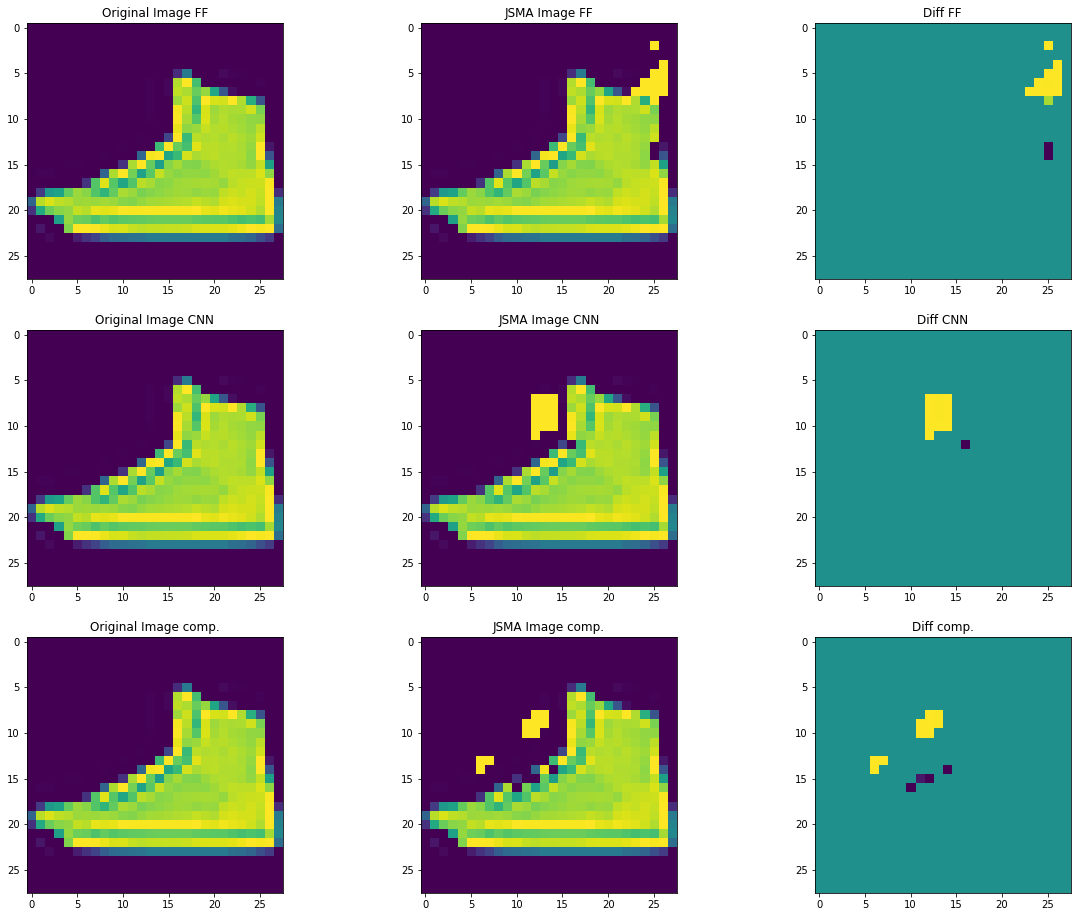

In [ ]:
 #@title Visualize JSMA { form-width: "20%" }

idx = 55

fig = plt.figure()

print(mnist_classes[mnist_y["test"][idx]] + ": " + str(mnist_y["test"][idx]))

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(20,16))
print("Epsilon (pix): " + str(num_pix))

ax[0][0].set_title("Original Image FF")
ax[0][0].imshow(mnist_x["test"][idx])
ax[0][1].set_title("JSMA Image FF")
ax[0][1].imshow(test_mnist_x_jsma_ff[idx])
ax[0][2].set_title("Diff FF")
ax[0][2].imshow(test_mnist_x_jsma_ff[idx]-mnist_x["test"][idx])

ax[1][0].set_title("Original Image CNN")
ax[1][0].imshow(mnist_x["test"][idx])
ax[1][1].set_title("JSMA Image CNN")
ax[1][1].imshow(test_mnist_x_jsma_cnn[idx])
ax[1][2].set_title("Diff CNN")
ax[1][2].imshow(test_mnist_x_jsma_cnn[idx]-mnist_x["test"][idx])

ax[2][0].set_title("Original Image comp.")
ax[2][0].imshow(mnist_x["test"][idx])
ax[2][1].set_title("JSMA Image comp.")
ax[2][1].imshow(test_mnist_x_jsma_comp[idx])
ax[2][2].set_title("Diff comp.")
ax[2][2].imshow(test_mnist_x_jsma_comp[idx]-mnist_x["test"][idx])


In [ ]:
 #@title Test JSMA { form-width: "20%" }

mnist_ff_jsma_testset = ImageDataset(test_mnist_x_jsma_ff,mnist_y["test"])
mnist_ff_jsma_testloader = DataLoader(mnist_ff_jsma_testset,50,shuffle=True)

mnist_cnn_jsma_testset = ImageDataset(test_mnist_x_jsma_cnn,mnist_y["test"])
mnist_cnn_jsma_testloader = DataLoader(mnist_cnn_jsma_testset,50,shuffle=True)

mnist_comp_jsma_testset = ImageDataset(test_mnist_x_jsma_comp,mnist_y["test"])
mnist_comp_jsma_testloader = DataLoader(mnist_cnn_jsma_testset,50,shuffle=True)

print(f'Baselines - FF: {baseline_ff}, CNN: {baseline_cnn}, Comp.: {baseline_comp}')
print(f'FF test accuracy: {test(mnist_ff,mnist_ff_jsma_testloader)[0]}')
print(f'CNN test accuracy: {test(mnist_cnn,mnist_cnn_jsma_testloader)[0]}')
print(f'Composite test accuracy: {test(mnist_comp,mnist_comp_jsma_testloader)[0]}')


Baselines - FF: 0.797, CNN: 0.4485, Comp.: 0.7465
FF test accuracy: 0.355
CNN test accuracy: 0.233
Composite test accuracy: 0.6445


In [ ]:
#@title Plug-in, JSMA

prediction, softmax_score, acc, mis_class_ex_ff_jsma = test_pipeline(mnist_ff, 
                      mnist_ff_jsma_testloader,weight_scheme='one_hot',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, mis_class_ex_cnn_jsma = test_pipeline(mnist_cnn, 
                      mnist_ff_jsma_testloader,weight_scheme='one_hot',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, mis_class_ex_comp_jsma = test_pipeline(mnist_comp, 
                      mnist_ff_jsma_testloader,weight_scheme='one_hot',trained=False)
print(f'Comp. test accuracy: {acc}')

prediction, softmax_score, acc, mis_class_ex_ff_jsma_weighted = test_pipeline(mnist_ff, 
                      mnist_ff_jsma_testloader,weight_scheme='weighted',trained=False)
print(f'FF test accuracy: {acc}')

prediction, softmax_score, acc, mis_class_ex_cnn_jsma_weighted = test_pipeline(mnist_cnn, 
                      mnist_ff_jsma_testloader,weight_scheme='weighted',trained=False)
print(f'CNN test accuracy: {acc}')

prediction, softmax_score, acc, mis_class_ex_comp_jsma_weighted = test_pipeline(mnist_comp, 
                      mnist_ff_jsma_testloader,weight_scheme='weighted',trained=False)
print(f'Comp. test accuracy: {acc}')

FF test accuracy: 0.376
CNN test accuracy: 0.3895
Comp. test accuracy: 0.6095
FF test accuracy: 0.377
CNN test accuracy: 0.3935
Comp. test accuracy: 0.6095


#Results



##Undefended Results

| Attack Method | FF Acc. (% drop) | CNN Acc. (% drop) | Comp. Acc. (% drop) |
| :- | :-: | :-: | :-: |
| No Attack | 79.7% | 44.85% | 74.5% |
| Random Perturbation | 78.8% (-1%) | 43.5% (-3%) | 71.5% (-4%) |
| SimBA| 70.3% (-12%) | 34.3% (-23%) | 67.1 (-10%) |
| Image Transforms | 29.3% (-63%) | 15.3% (-66%) | 38.7% (-48%) | 
| FGSM | 71.2% (-11%) | 35.4% (-21%) | 67.3% (-10%) |
| PGD | 60.0% (-25%) | 22.1% (-51%) | 48.7% (-35%) | 
| BIM | 29.3% (-63%) | 15.3% (-66%) | 38.7% (-48%) | 

In general white-box threat models are most successful however data-deficient threats (image transforms) also exhibit strong adversarial performance.



## SPIE-D Results:

| Attack Method | FF Acc. (% drop) | CNN Acc. (% drop) | Comp. Acc. (% drop) |
| :- | :-: | :-: | :-: |
| No Attack | 79% (-1%) | 45% (-0%) | 74% (-1%) |
| Random Perturbation | 75% (-5%) | 44% (-2%) | 70% (-5%) |
| SimBA| 65% (-18%) | 38% (-16%) | 64 (-14%) |
| Image Transforms | 53% (-33%) | 34% (-24%) | 55% (-26%) | 
| FGSM | 72% (-9%) | 42% (-7%) | 69% (-7%) |
| PGD | 62% (-22%) | 33% (-27%) | 58% (-22%) | 
| BIM | 46% (-42%) | 28% (-38%) | 54% (-27%) | 

SPIE-D has maintained the accuracy of the baseline classifiers and stemmed the drop on gradient based attacks. However, it has actually axacerbated losses on black-box threats and made little difference on data-deficiency threats.

## RAIN Results:

| Attack Method | FF Acc. (% drop) | CNN Acc. (% drop) | Comp. Acc. (% drop) |
| :- | :-: | :-: | :-: |
| No Attack | 73% (-9%) | 29% (-36%) | 69% (-8%) |
| Random Perturbation | 71% (-3%) | 28% (-3%) | 66% (-4%) |
| SimBA| 66% (-10%) | 25% (-14%) | 63 (-9%) |
| Image Transforms | 26% (-64%) | 23% (-21%) | 51% (-26%) | 
| FGSM | 70% (-4%) | 28% (-3%) | 67% (-3%) |
| PGD | 65% (-11%) | 25% (-14%) | 61% (-12%) | 
| BIM | 57% (-22%) | 24% (-17%) | 55% (-20%) | 

The drop in baseline accuracies is surprising and perhaps indicative that the domain was not maintained by the EDSR net. It is difficult to gauge whether the mitigation in accuracy drop for grient threats is attributable to the pre-processing pipeline or an artifact of the domain shift and subsequent accuracy drop.

## Provably Robust Boosting Results:

|  | Test Error | Accuracy (% drop) |
| :- | :-: | :-: |
| Baseline | 13.65% | 86.35%
| Random Perturbation | 26.80% | 73.2% (-15%)
| SimBA_FF| 25.50% | 74.5% (-14%)
| SimBA_CNN| 19.6% | 80.4% (-7%)
| SimBA_Comp| 24.4% | 75.6% (-12%)
| Image Transforms | 43.14% | 56.86% (-34%)
| FGSM_FF | 14.4% | 85.6% (-1%)
| FGSM_CNN | 13.95% | 86.05% (-0%)
| FGSM_Comp | 14.0% | 86% (-0%)
| PGD_FF | 15.35% | 84.65 (-2%)
| PGD_CNN | 14.55% | 85.45% (-1%)
| PGD_Comp | 15.40% | 84.6% (-2%)
| BIM_FF | 21.2% | 78.8% (-9%)
| BIM_CNN | 14.85% | 85.15% (-1%)
| BIM_Comp | 15.85% | 84.15% (-3%)

As you can see from the results, there is a more significant drop in accuracy when atatacked with Random Perturbation, SimBA, Image Transforms, and BIM_FF. We were surprised that it did not do as well in the black box attacks, since this model was exclusively trained on black box attacks. However, we are not too shocked because the exact same black box attacks are not used, which could have lead to this drop in accuracy. 

## Augmented and Adversarial Training Results:

### Augmented (Image Transforms): 
#### Undefended

| Attack Method | FF Acc. (% drop) | CNN Acc. (% drop) | Comp. Acc. (% drop) |
| :- | :-: | :-: | :-: |
| No Attack | 77% (-3%) | 76% (+69%) | 83% (+12%) |
| Random Perturbation | 75% (-3%) | 71% (-7%) | 80% (-4%) |
| SimBA| 67% (-13%) | 69% (-9%) | 63 (-24%) |
| Image Transforms | 62% (-19%) | 65% (-14%) | 75% (-10%) | 
| FGSM | 68% (-12%) | 73% (-4%) | 80% (-4%) |
| PGD | 50% (-35%) | 67% (-12%) | 63% (-24%) | 
| BIM | 21% (-73%) | 20% (-74%) | 13% (-84%) | 

#### Defended

| Attack Method | FF Acc. (% drop) | CNN Acc. (% drop) | Comp. Acc. (% drop) |
| :- | :-: | :-: | :-: |
| No Attack | 77% (-3%) | 76% (+69%) | 83% (+12%) |
| Random Perturbation | 76% (-1%) | 73% (-4%) | 81% (-2%) |
| SimBA| 70% (-9%) | 71% (-7%) | 70% (-16%) |
| Image Transforms | 61% (-21%) | 65% (-28%) | 75% (-10%) | 
| FGSM | 74% (-4%) | 75% (-1%) | 82% (-1%) |
| PGD | 55% (-29%) | 69% (-9%) | 70% (-16%) | 
| BIM | 40% (-48%) | 42% (-45%) | 32% (-61%) | 

### Adversarial (Every 10 images is PGD): 
#### Undefended
| Attack Method | FF Acc. (% drop) | CNN Acc. (% drop) | Comp. Acc. (% drop) |
| :- | :-: | :-: | :-: |
| No Attack | 84% (+5%) | 63% (+16%) | 80% (+7%) |
| Old SimBA| 75% (-11%) | 61% (-3%) | 77% (-4%) |
| Image Transforms | 54% (-36%) | 49% (-22%) | 59% (-26%) | 
| Old BIM | 33% (+61%) | 52% (-17%) | 57% (-29%) | 

In general augmented and adversarial training methods produce equal or improved performance on baseline images which does not actually contradict [citation] as the authors claim that poorly tuned classifiers can be improved by such methods. Further, the resulting drops from baseline accuracy are not as severe suggesting the possibly more robust networks overall. 

The fact that the denoisers utilized were trained on using attacks generated on the un-augmented classifiers suggests some degree of transferability for the defense strategy and the fact that the adversarially trained classifier showed performance drops from attacks generated using the un-augmented classifier suggests transferability in attacks.



##Held Out Attack Results:

### JSMA

| Defense Method | FF Acc. (% drop) | CNN Acc. (% drop) | Comp. Acc. (% drop) |
| :- | :-: | :-: | :-: |
| None | 36% (-55%) | 23% (-49%) | 64% (-15%) |
| SPIE-D | 38% (-53%) | 39% (-13%) | 61% (-19%) |

Very little change in accuracy drop demonstrated by the SPIE-D defender hints at transferability challenges.

# Discussion

## What you've learned

We had a few key takeaways from the project. Firstly, our analysis on attack transferability seemed to indicate that image attacks that work on one specific image classifier will also retain some of their effectiveness on any other image classifier. This finding is important because while direct white box attacks may be uncommon due to the low practical chance an attacker has direct access to a model, an attacker can still transfer a white box attack that was only tested on a different classifier. In addition, it was also interesting that even if the white box setting is completely disregarded, our findings still indicate that black box attacks like SimBA can significantly harm the performance of baseline image classifiers. These findings further emphasizes the need for robust image classifiers and defenders such as SPIE-D, and also highlight the vulnerability of image classification systems. 

Second, plug-in systems are very helpful in practice due to the time gained by not having to constantly retrain. Moreover, our struggles working with *PixelDefend* highlighted the importance of understandable code and well-maintained repositories. In the future, it would definitely be valuable to do some initial exploration of GitHub repos containing code related to academic findings before committing to incorporating said methods into a project. Further discussion below.



###Interpreting Misclassified Images 

After implementing our defense strategy, we sought to get a better understanding of our model by interpretting the misclassified images. Below, we've outputted some example images that were misclassified by our pipeline for attacks generated by SIMBA and BIM under both the plug-in and retrained defense nets. Other examples were analyzed, but for the report, we decided to focus on SIMBA and BIM as these two were the most effective black-box and white-box attacks, respectively, that we tried. In general, similar to what we have discussed in class, we found that it is difficult to interpret why the neural network misclassified the images. However, we noticed the trend that after denoising, our network tends to misclassify clothing items that look familiar. For example, we noticed that our model might misclassify t-shirt/tops (label 0) as a dress (label 3) based on the denoised image. This could be due to our denoising strategy, where we use a convolutional autoencoder to denoise random-perturbation and gradient-based attacks. The resulting denoised image retains the broad structure/features of the image but is less defined compared to the original image (i.e. see examples outputted below).  

If we had two more weeks to work on this project, we would implement interpetability methods, such as LIME, to get a better understanding of our model. In particular, we would be interesting in looking at differences in LIME masks for the Plug-In pipeline vs Retrained pipeline. It would also be interesting to look at whether we can use LIME masks to explain why undefended models perform poorly on adversarial images. We hypothesize that the LIME masks will show that adversarial attacks (in particualr white box attacks) make perturbations to the images at locations that are crucial to how the model is making classifications. Furthermore, other potential areas of exploration is to improve upon the SPIE-D denoising strategies that could make plug-in defense strategies more desirable. For example, we would like to implement a method to "denoise" image-transform attacks, where any image that was identified as a rotation adversarial example by our adversary detector will be randomly rotated until the adversarial detector no longer classifies it as an adversary example. Lastly, for our current project, we only considered single-class adversarial images (i.e. each adversarial image was either produced via random perturbation, gradient-based attacks, or image transforms). In the future, we would also like to improve upon our defense strategy by considering what happens when different attacks are combined (i.e. attacking our defended classifier with an example that was produced by a combination of gradient-based attacks and image transforms). To defend against these combination attacks, we hypothesize that we can adapt our existing strategy and utilize an iterative strategy, where the image is fed through our adversarial detector and denoisers until the detector no longer classifies it as an adversary. 


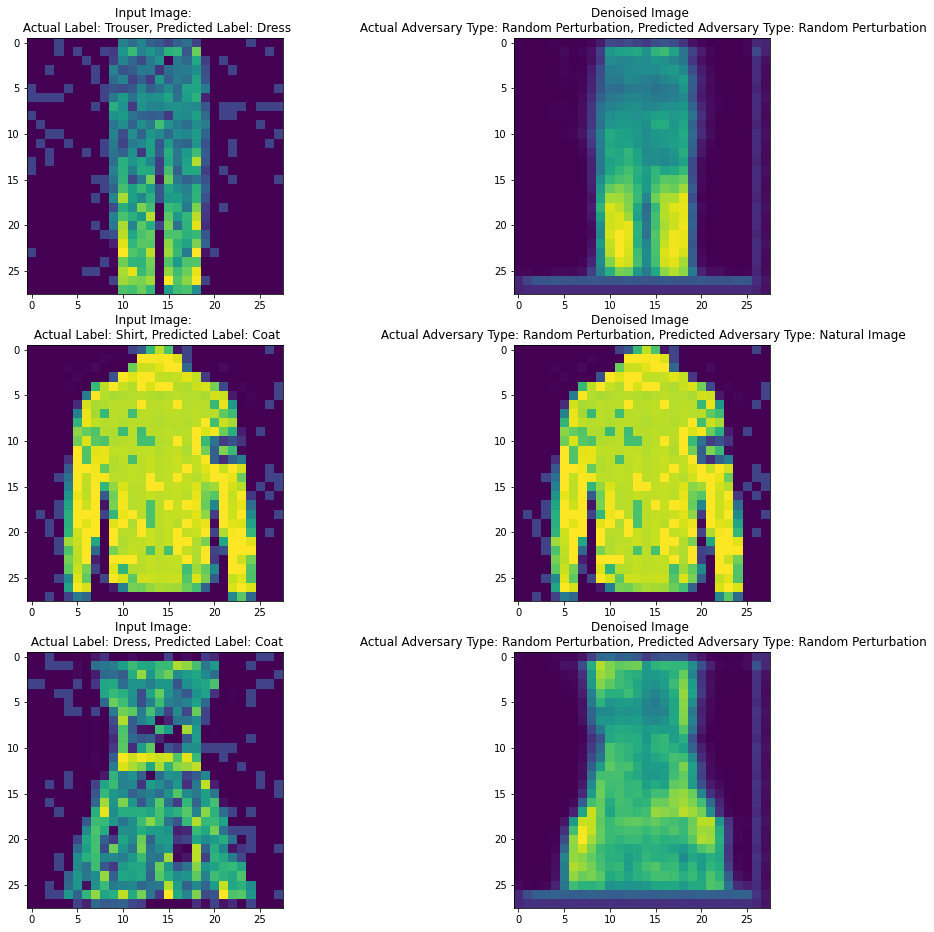

In [ ]:
#@title Plug-in, SPIE-D-SIMBA visualization of misclassified images { form-width: "10%" }
denoiser_key = {0: "Natural Image", 1: "Gradient-Based", 2: "Random Perturbation", 3: "Blur Transform"}
fashion_key = {0:	"T-shirt/top", 
1:	"Trouser",
2:	"Pullover", 
3: "Dress", 
4: "Coat",
5:	"Sandal",
6:	"Shirt",
7:	"Sneaker",
8:	"Bag",
9:	"Ankle boot"}

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(16,16))

ax[0][0].set_title(f'Input Image: \n Actual Label: {fashion_key[misclass_ex_ff_plug_simba[10][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_plug_simba[10][4].cpu().detach().item()]}')
ax[0][0].imshow(misclass_ex_ff_plug_simba[10][0].cpu().reshape((28,28)))
ax[0][1].set_title(f'Denoised Image \n Actual Adversary Type: Random Perturbation, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_plug_simba[10][2].cpu().detach().numpy())]}')
ax[0][1].imshow(misclass_ex_ff_plug_simba[10][1].cpu().reshape((28,28)))

ax[1][0].set_title(f'Input Image: \n Actual Label: {fashion_key[misclass_ex_ff_plug_simba[20][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_plug_simba[20][4].cpu().detach().item()]}')
ax[1][0].imshow(misclass_ex_ff_plug_simba[20][0].cpu().reshape((28,28)))
ax[1][1].set_title(f'Denoised Image \n Actual Adversary Type: Random Perturbation, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_plug_simba[20][2].cpu().detach().numpy())]}')
ax[1][1].imshow(misclass_ex_ff_plug_simba[20][1].cpu().reshape((28,28)))

ax[2][0].set_title(f'Input Image: \n Actual Label: {fashion_key[misclass_ex_ff_plug_simba[30][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_plug_simba[30][4].cpu().detach().item()]}')
ax[2][0].imshow(misclass_ex_ff_plug_simba[30][0].cpu().reshape((28,28)))
ax[2][1].set_title(f'Denoised Image \n Actual Adversary Type: Random Perturbation, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_plug_simba[30][2].cpu().detach().numpy())]}')
ax[2][1].imshow(misclass_ex_ff_plug_simba[30][1].cpu().reshape((28,28)))

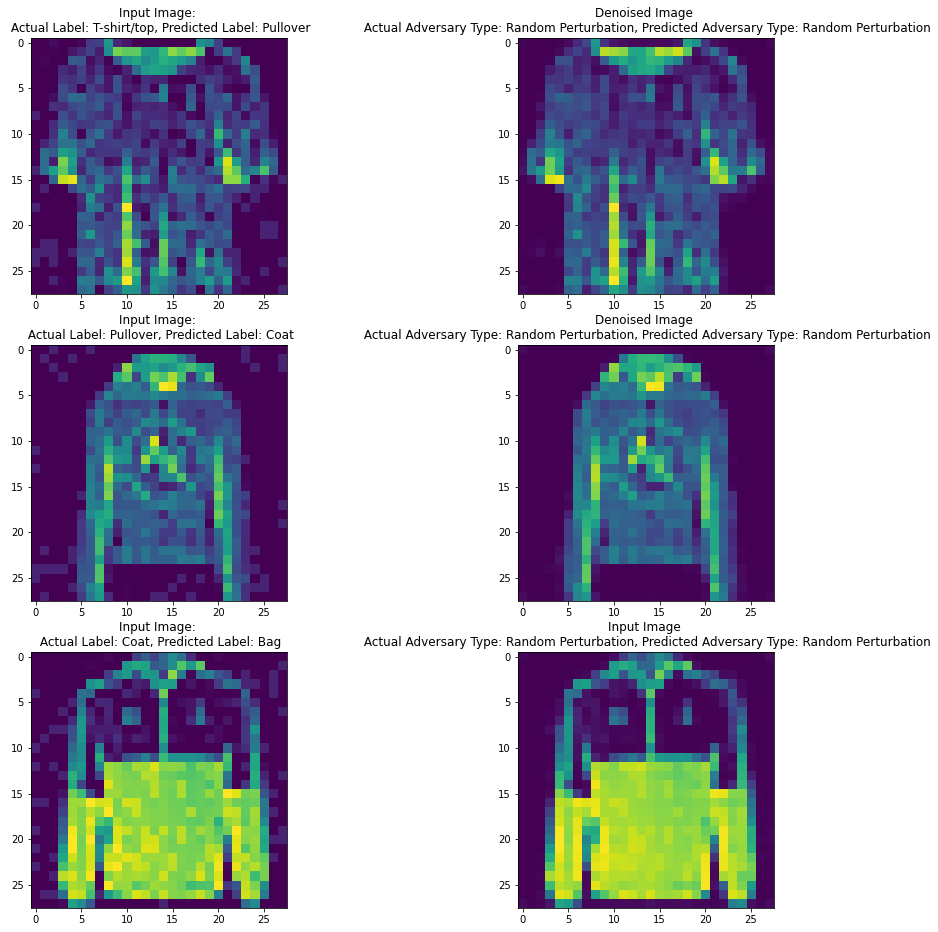

In [ ]:
#@title Retrained, SPIE-D-SIMBA visualization of misclassified images { form-width: "5%" }

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(16,16))

ax[0][0].set_title(f'Input Image: \n Actual Label: {fashion_key[misclass_ex_ff_trans_simba[0][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_trans_simba[0][4].cpu().detach().item()]}')
ax[0][0].imshow(misclass_ex_ff_trans_simba[0][0].cpu().reshape((28,28)))
ax[0][1].set_title(f'Denoised Image \n Actual Adversary Type: Random Perturbation, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_trans_simba[0][2].cpu().detach().numpy())]}')
ax[0][1].imshow(misclass_ex_ff_trans_simba[0][1].cpu().reshape((28,28)))

ax[1][0].set_title(f'Input Image: \n Actual Label: {fashion_key[misclass_ex_ff_trans_simba[1][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_trans_simba[1][4].cpu().detach().item()]}')
ax[1][0].imshow(misclass_ex_ff_trans_simba[1][0].cpu().reshape((28,28)))
ax[1][1].set_title(f'Denoised Image \n Actual Adversary Type: Random Perturbation, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_trans_simba[1][2].cpu().detach().numpy())]}')
ax[1][1].imshow(misclass_ex_ff_trans_simba[1][1].cpu().reshape((28,28)))

ax[2][0].set_title(f'Input Image: \n Actual Label: {fashion_key[misclass_ex_ff_trans_simba[2][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_trans_simba[2][4].cpu().detach().item()]}')
ax[2][0].imshow(misclass_ex_ff_trans_simba[2][0].cpu().reshape((28,28)))
ax[2][1].set_title(f'Input Image \n Actual Adversary Type: Random Perturbation, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_trans_simba[2][2].cpu().detach().numpy())]}')
ax[2][1].imshow(misclass_ex_ff_trans_simba[2][1].cpu().reshape((28,28)))

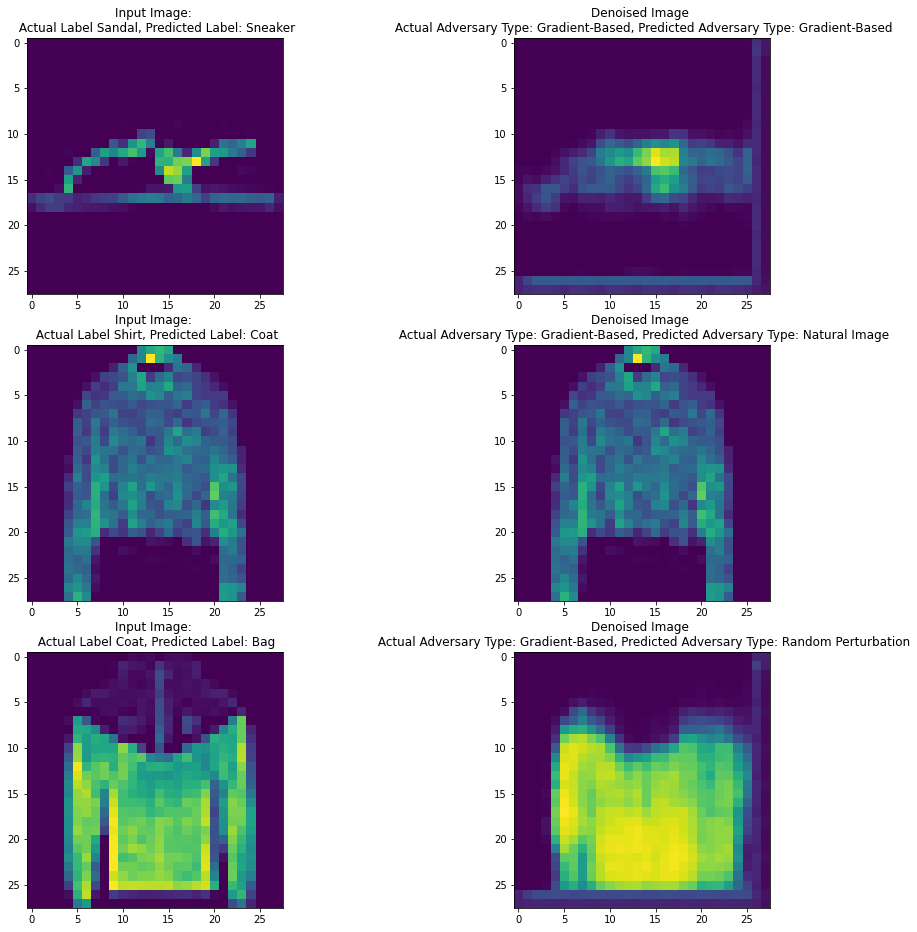

In [ ]:
#@title Plug-in, SPIE-D-BIM visualization of misclassified images { form-width: "10%" }

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(16,16))

ax[0][0].set_title(f'Input Image: \n Actual Label {fashion_key[misclass_ex_ff_plug_bim[11][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_plug_bim[11][4].cpu().detach().item()]}')
ax[0][0].imshow(misclass_ex_ff_plug_bim[11][0].cpu().reshape((28,28)))
ax[0][1].set_title(f'Denoised Image \n Actual Adversary Type: Gradient-Based, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_plug_bim[11][2].cpu().detach().numpy())]}')
ax[0][1].imshow(misclass_ex_ff_plug_bim[11][1].cpu().reshape((28,28)))

ax[1][0].set_title(f'Input Image: \n Actual Label {fashion_key[misclass_ex_ff_plug_bim[22][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_plug_bim[22][4].cpu().detach().item()]}')
ax[1][0].imshow(misclass_ex_ff_plug_bim[22][0].cpu().reshape((28,28)))
ax[1][1].set_title(f'Denoised Image \n Actual Adversary Type: Gradient-Based, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_plug_bim[22][2].cpu().detach().numpy())]}')
ax[1][1].imshow(misclass_ex_ff_plug_bim[22][1].cpu().reshape((28,28)))

ax[2][0].set_title(f'Input Image: \n Actual Label {fashion_key[misclass_ex_ff_plug_bim[30][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_plug_bim[30][4].cpu().detach().item()]}')
ax[2][0].imshow(misclass_ex_ff_plug_bim[30][0].cpu().reshape((28,28)))
ax[2][1].set_title(f'Denoised Image \n Actual Adversary Type: Gradient-Based, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_plug_bim[30][2].cpu().detach().numpy())]}')
ax[2][1].imshow(misclass_ex_ff_plug_bim[30][1].cpu().reshape((28,28)))

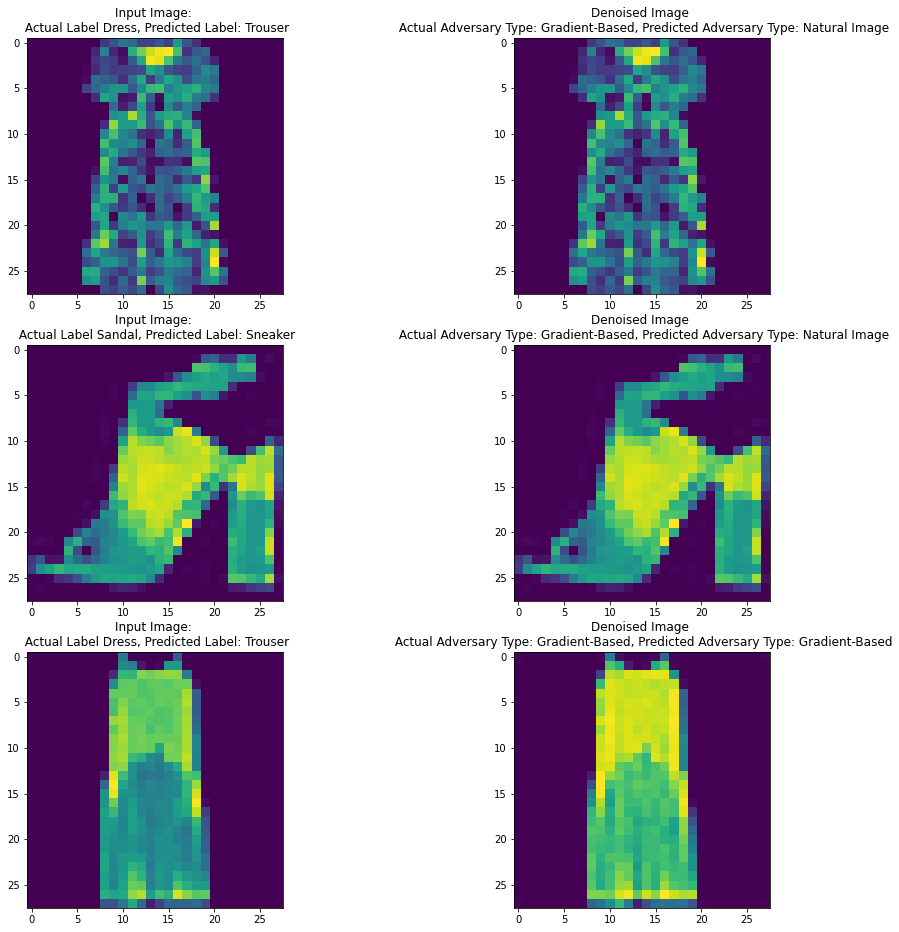

In [ ]:
#@title Retrained, SPIE-D-BIM Visualization of Misclassified Images { form-width: "10%" }
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(16,16))

ax[0][0].set_title(f'Input Image: \n Actual Label {fashion_key[misclass_ex_ff_trans_bim[11][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_trans_bim[11][4].cpu().detach().item()]}')
ax[0][0].imshow(misclass_ex_ff_trans_bim[11][0].cpu().reshape((28,28)))
ax[0][1].set_title(f'Denoised Image \n Actual Adversary Type: Gradient-Based, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_trans_bim[11][2].cpu().detach().numpy())]}')
ax[0][1].imshow(misclass_ex_ff_trans_bim[11][1].cpu().reshape((28,28)))

ax[1][0].set_title(f'Input Image: \n Actual Label {fashion_key[misclass_ex_ff_trans_bim[22][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_trans_bim[22][4].cpu().detach().item()]}')
ax[1][0].imshow(misclass_ex_ff_trans_bim[22][0].cpu().reshape((28,28)))
ax[1][1].set_title(f'Denoised Image \n Actual Adversary Type: Gradient-Based, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_trans_bim[22][2].cpu().detach().numpy())]}')
ax[1][1].imshow(misclass_ex_ff_trans_bim[22][1].cpu().reshape((28,28)))

ax[2][0].set_title(f'Input Image: \n Actual Label {fashion_key[misclass_ex_ff_trans_bim[30][3].cpu().detach().item()]}, Predicted Label: {fashion_key[misclass_ex_ff_trans_bim[30][4].cpu().detach().item()]}')
ax[2][0].imshow(misclass_ex_ff_trans_bim[30][0].cpu().reshape((28,28)))
ax[2][1].set_title(f'Denoised Image \n Actual Adversary Type: Gradient-Based, Predicted Adversary Type: {denoiser_key[np.argmax(misclass_ex_ff_trans_bim[30][2].cpu().detach().numpy())]}')
ax[2][1].imshow(misclass_ex_ff_trans_bim[30][1].cpu().reshape((28,28)))

##Adversarial and Augmented Training

In general Adversarial and Augmented Training improve the baseline accuracy of the CNN and composite classifiers. This would appear to suggest that adversarial training is a form of regularization however this is not acutally the case. Notice that the FF baseline accuracy actually goes down yet the classifier gains robustness. If adversarial training were truly a form of regularization than baseline test accuracy would be expected to increase, this is the explanation presented by [2]. Although the CNN and composite accuracies increase this is still not a contradictory result as the authors note that classifiers that fail to learn "good" performance can be improved through adversarial training however if the classifier was able to learn "good" baseline accuracy on a task adversarial training would acutally decrease the performance on baseline images as was observed. However, the poor recovery capabilities of both the convolutional auto-encoder and EDSR denoising strategy on augmented data suggests that the best mitigation strategy for any classifier from project conception will be to include augmented data in training for better real world performance.  

What is more, the use of defense strategy does not quite fit into the bias-variance framework. The adversary detector and denoisers are themselves models that may be overfit to certain types of data, an idea discussed further in [Transferability of Defenses](#scrollTo=Frvj1OA6D36Z). Further, a defense strategy like RAIN can increase adversarial robustness while maintaining baseline classification accuracy and thus there is not necessarily a trade off. Still, even data pre-processing models such as RAIN assume certain properties of the adversary, specifically high frequency content. RAIN was found to be very vulnerable to the hyper-parameters of the EDSR resolution enhancement. This susceptability was likely what caused RAIN's performance to surprisingly deteriorate so heavily in the implementation for this project, especially for the allegedly spatially invariant CNN based classifer. This was also an issue exacerbated by the natively small F-MNIST image sizes offering relatively few features to begin with. Anoter clue can be gleaned from the JSMA shown [above](#scrollTo=lNSXvGAliGGn), revealing that although the CNN and comp networks are foccusing on features in the image interior the FF classifier's most salient features are on the edge, thus even random circular shifting can degrade the performance of the classifier.

###Transferability of Attacks

Intuitively a white-box threat with access to the classifier is a much greater adversary. However, in application access to the classifier on this level seems dubious. To get arround this issue the transferability of adversarial attacks is visualized below. That is, adverarial threats generated using one classifier (FF for example) are used to attack the other two and vice-versa. In the visualized heat-maps below the percentage of the baseline accuracy retained by each classifier (for example a test accuracy of 25% of a classifier with 50% baseline accuracy would show up as 50%) is shown for the cross-generated attacks.  

Overall, the heatmaps show a degree of transferability for adversarial threats which is especially pronouned for white-box threats. This is a serious concern and re-iterates the motivation for robust defense strategies detached from the classifier as this would suggests an attacker can craft strong attacks against an image classifier simply with access to the data the classifier was trained on and any common strategies such as adversarial training that may be built into the classifier. Further exploration into the question could generate another sub-sample of the F-MNIST dataset with images not in the training set. From there adveraries can be generated and tested to see if an attacker needs access to the training data or if access to the same "types" of images is sufficient to craft a successful attack.



Baselines - FF: 0.797
FF attacked with FF: 0.5855
FF attacked with CNN: 0.7635
FF attacked with Comp.: 0.7265
Baselines - CNN: 0.4485
CNN attacked with FF: 0.42
CNN attacked with CNN: 0.294
CNN attacked with Comp.: 0.4205
Baselines - Comp.: 0.7465
Comp. attacked with FF: 0.6685
Comp. attacked with CNN: 0.713
Comp. attacked with Comp.: 0.6625


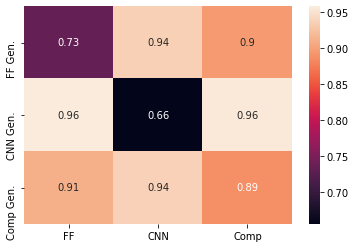

In [ ]:
#@title Transfer SimBA { form-width: "20%" }

print(f'Baselines - FF: {baseline_ff}')
ff00 = test(mnist_ff,mnist_ff_simba_testloader)[0]
print(f'FF attacked with FF: {ff00}')
ff01 = test(mnist_ff,mnist_cnn_simba_testloader)[0]
print(f'FF attacked with CNN: {ff01}')
ff02 = test(mnist_ff,mnist_comp_simba_testloader)[0]
print(f'FF attacked with Comp.: {ff02}')

print(f'Baselines - CNN: {baseline_cnn}')
cnn10 = test(mnist_cnn,mnist_ff_simba_testloader)[0]
print(f'CNN attacked with FF: {cnn10}')
cnn11 = test(mnist_cnn,mnist_cnn_simba_testloader)[0]
print(f'CNN attacked with CNN: {cnn11}')
cnn12 = test(mnist_cnn,mnist_comp_simba_testloader)[0]
print(f'CNN attacked with Comp.: {cnn12}')

print(f'Baselines - Comp.: {baseline_comp}')
comp20 = test(mnist_comp,mnist_ff_simba_testloader)[0]
print(f'Comp. attacked with FF: {comp20}')
comp21 = test(mnist_comp,mnist_cnn_simba_testloader)[0]
print(f'Comp. attacked with CNN: {comp21}')
comp22 = test(mnist_comp,mnist_comp_simba_testloader)[0]
print(f'Comp. attacked with Comp.: {comp22}')

ff_col = [ff00,ff01,ff02]
ff_col = np.array(ff_col) / baseline_ff
cnn_col = [cnn10,cnn11,cnn12]
cnn_col = np.array(cnn_col) / baseline_cnn
comp_col = [comp20,comp21,comp22]
comp_col = np.array(comp_col) / baseline_comp

cross_simba = [ff_col,cnn_col,comp_col]

import pandas as pd

data = {'FF':  [cross_simba[0][0], cross_simba[0][1], cross_simba[0][2]],
        'CNN': [cross_simba[1][0], cross_simba[1][1], cross_simba[1][2]],
        'Comp': [cross_simba[2][0], cross_simba[2][1], cross_simba[2][2]]
        }

cross_simba_df = pd.DataFrame (data, columns = ['FF','CNN', 'Comp'],
                   index=['FF Gen.','CNN Gen.','Comp Gen.'])

sns.heatmap(cross_simba_df,annot=True)

Baselines - FF: 0.797
FF attacked using FF - test accuracy: 0.298
FF attacked using CNN - test accuracy: 0.7465
FF attacked using comp. - test accuracy: 0.644
Baselines - CNN: 0.4485
CNN attacked using F - test accuracy: 0.396
CNN attacked using CNN - test accuracy: 0.157
CNN attacked using comp. - test accuracy: 0.37
Baselines - Comp.: 0.7465
Comp. attacked using FF - test accuracy: 0.471
Comp. attacked using CNN - test accuracy: 0.6575
Comp. attacked using comp. - test accuracy: 0.4095


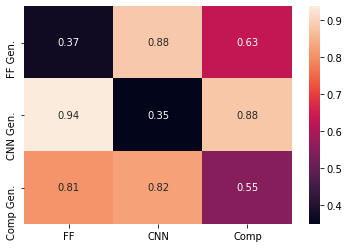

In [ ]:
#@title BIM transfer { form-width: "20%" }

print(f'Baselines - FF: {baseline_ff}')
ff00 = test(mnist_ff,mnist_ff_bim_testloader)[0]
print(f'FF attacked using FF - test accuracy: {ff00}')
ff01 = test(mnist_ff,mnist_cnn_bim_testloader)[0]
print(f'FF attacked using CNN - test accuracy: {ff01}')
ff02 = test(mnist_ff,mnist_comp_bim_testloader)[0]
print(f'FF attacked using comp. - test accuracy: {ff02}')

print(f'Baselines - CNN: {baseline_cnn}')
cnn10 = test(mnist_cnn,mnist_ff_bim_testloader)[0]
print(f'CNN attacked using F - test accuracy: {cnn10}')
cnn11 = test(mnist_cnn,mnist_cnn_bim_testloader)[0]
print(f'CNN attacked using CNN - test accuracy: {cnn11}')
cnn12 = test(mnist_cnn,mnist_comp_bim_testloader)[0]
print(f'CNN attacked using comp. - test accuracy: {cnn12}')

print(f'Baselines - Comp.: {baseline_comp}')
comp20 = test(mnist_comp,mnist_ff_bim_testloader)[0]
print(f'Comp. attacked using FF - test accuracy: {comp20}')
comp21 = test(mnist_comp,mnist_cnn_bim_testloader)[0]
print(f'Comp. attacked using CNN - test accuracy: {comp21}')
comp22 = test(mnist_comp,mnist_comp_bim_testloader)[0]
print(f'Comp. attacked using comp. - test accuracy: {comp22}')

ff_col = [ff00,ff01,ff02]
ff_col = np.array(ff_col) / baseline_ff
cnn_col = [cnn10,cnn11,cnn12]
cnn_col = np.array(cnn_col) / baseline_cnn
comp_col = [comp20,comp21,comp22]
comp_col = np.array(comp_col) / baseline_comp

cross_grad = [ff_col,cnn_col,comp_col]

import pandas as pd

data = {'FF':  [cross_grad[0][0], cross_grad[0][1], cross_grad[0][2]],
        'CNN': [cross_grad[1][0], cross_grad[1][1], cross_grad[1][2]],
        'Comp': [cross_grad[2][0], cross_grad[2][1], cross_grad[2][2]]
        }

cross_grad_df = pd.DataFrame (data, columns = ['FF','CNN', 'Comp'],
                   index=['FF Gen.','CNN Gen.','Comp Gen.'])

sns.heatmap(cross_grad_df,annot=True)



###Transferability of Defenses

So far the adversarial defense strategy SPIE-D showed some ability to improve adversarial robustness however the adversaries were all known and SPIE-D was designed to manage them. This is the case when SPIE-D was used to defend the classifiers retrained on augmented data. Even though SPIE-D was not explicitly trained on the threats generated for the retrained classifiers the system still demonstrated improved robustness. This would hint at a small degree of transferability for defense strategies or at least invariance to the baseline classifier protected.

To explore the generalizability to previously unaccounted adversaries an additional Jacobian Saliancy Map Attack threat was generated. The JSMA is a white-box threat that the adversary detector was not trained to detect nor was there any training or denoising strategy in place to defend against. As demonstrated in [in "Held Out Attack Results"](#scrollTo=f8uQgYyGefij) when the undefended and SPIE-D defended classifiers are attacked using this previously unseen form of adversary there is little effect on the adversarial robustness for the FF and composite classifiers. The CNN shows noticable improvements to adversarial robustness but this may be in large part due to the poor baseline performance of the classifier. The experiment thus demonstrates that tailor-made defense strategy in some sense overfits the adversaries it is designed for but is unable to generalize or transfer to adversaries un-accounted for. This poses a challenge as adverarial attacks have been shown to demonstrate a degree of transferability above but it would appear defenses do not. Additional work however could test such zero-day or held out attack methods on the RAIN or *PixelDefend* methods to establish if more drastic pre-processing or generative models would perform better. The suspicion is that they would as RAIN, for example, did not train with any particular adversary class in mind. 

#Citations

##Reference

[1] K. Quach, “Researchers trick Tesla into massively breaking the speed limit by sticking a 2-inch piece of electrical tape on a sign,” www.theregister.com. https://www.theregister.com/2020/02/20/tesla_ai_tricked_85_mph/ (accessed Dec. 13, 2020).

[2] D. Tsipras, S. Santurkar, L. Engstrom, A. Turner and A. Madry, "Robustness May Be at Odds with Accuracy," [Online] arXiv.org, 2020. Available: https://arxiv.org/abs/1805.12152 (Accessed: 17- Nov- 2020).

[3] Xiao, H., 2017. *Fashion-MNIST*. [online] GitHub. Available at: <https://github.com/zalandoresearch/fashion-mnist> [Accessed 14 December 2020].

[4] Madry, A., Makelov, A., Schmidt, L., Tsipras, D. and Vladu, A., "Towards Deep Learning Models Resistant To Adversarial 
Attacks," [online] arXiv.org, 2019. Available at: <https://arxiv.org/abs/1706.06083> [Accessed 17 November 2020].

[5]	Yuan, X., He, P., Zhu, Q. and Li, X., "Adversarial Examples: Attacks And Defenses For Deep Learning," [online] arXiv.org, 2018.  
Available at: <https://arxiv.org/abs/1712.07107> [Accessed 17 November 2020].

[6] Guo, C., Gardner, J., You, Y., Wilson, A. and Weinberger, K., "Simple Black-Box Adversarial Attacks," [online] arXiv.org, 2019.  
Available at: <https://arxiv.org/abs/1905.07121> [Accessed 17 November 2020].

[7] Du, J., Yan, H., Tan, V., Zhou, J., Goh, R. and Feng, J., "RAIN: A Simple Approach For Robust And Accurate Image Classification Networks," [online] arXiv.org, 2020. Available at: <https://arxiv.org/abs/2004.14798> [Accessed 17 November 2020].

[8] Andriushchenko, M., Hein, M., “Provably Robust Boosted Decision Stumps and Trees against Adversarial Attacks,” [online] DeepAI, Jun. 08, 2019. Available at: <https://deepai.org/publication/provably-robust-boosted-decision-stumps-and-trees-against-adversarial-attacks> [accessed Dec. 1, 2020].

[9] Song, Y., Kim, T., Nowozin, S., Ermon, S. and Kushman, N., "Pixeldefend: Leveraging Generative Models To Understand 
And Defend Against Adversarial Examples," [online] arXiv.org, 2018. Available at: <https://arxiv.org/abs/1710.10766> [Accessed 17 
November 2020].

[10] B. Lim, S. Son, H. Kim, S. Nah, and K. M. Lee, “Enhanced Deep Residual Networks for Single Image Super-Resolution,” [Online]
arXiv:1707.02921 [cs], Jul. 2017. Available at: <https://arxiv.org/abs/1707.02921> [Accessed 27 
November 2020].

[11] D. Hendrycks and K. Gimpel, “A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks,” [Online] arXiv:1610.02136 [cs], Oct. 2018. Available at: <https://arxiv.org/abs/1610.02136> [Accessed: 20 Novermber 2020].

[12] D. S. Chen and R. C. Jain, "A robust backpropagation learning algorithm for function approximation," in IEEE Transactions on Neural Networks, vol. 5, no. 3, pp. 467-479, May 1994, doi: 10.1109/72.286917. Available at: <https://ieeexplore.ieee.org/document/286917> [Accessed: 24 Novermber 2020].

[13] R. Wiyatno and A. Xu, “Maximal Jacobian-based Saliency Map Attack,” [Online] arXiv:1808.07945 [cs, stat], Aug. 2018. Available at: <https://arxiv.org/abs/1808.07945> [Accessed: 10 December 2020].
